In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

df = pd.read_csv("data/movies_dataset.csv")

df['genres_list'] = df['genres'].apply(lambda g: [genre.strip() for genre in g.split(',')])

mlb = MultiLabelBinarizer()
df['multi_hot_labels'] = mlb.fit_transform(df['genres_list']).tolist()
print(len(df["multi_hot_labels"][0]))


14


In [2]:
import sys
import os

# Add project root to path if it's not already
project_root = os.path.abspath(".")
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torchvision import transforms
from dataset import MoviePosterDataset
from models.simple_cnn import SimpleCNN
from utils import plot_training_curves
from train import train

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = MoviePosterDataset(train_df, poster_directory="data/movie_posters", transform=image_transform)
val_dataset = MoviePosterDataset(val_df, poster_directory="data/movie_posters", transform=image_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(mlb.classes_)).to(device)

label_matrix = np.array(train_df['multi_hot_labels'].tolist())
class_freq = label_matrix.sum(axis=0)
pos_weights = 1.0 / (class_freq + 1e-6)
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32).to(device)

criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
results = train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)

plot_training_curves(
    results['train_losses'], results['val_losses'],
    results['train_accuracies'], results['val_accuracies'],
    results['train_f1_micro'], results['val_f1_micro'],
    results['train_f1_macro'], results['val_f1_macro'],
    save_path="cnn_training_results.png"
)


epoch 1/10 [validation]: 100%|██████████| 93/93 [00:17<00:00,  5.45it/s]


epoch 1/10 | time: 119.2s | training loss: 0.3547 | training accuracy: 0.1197 | validation loss: 0.3371 | validation accuracy: 0.1207 | validation macro-f1: 0.2148



epoch 2/10 [training]:  77%|███████▋  | 284/369 [01:19<00:23,  3.59it/s]


KeyboardInterrupt: 

In [ ]:
#!/usr/bin/env python3

import os
import itertools
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import MultiLabelBinarizer
from torchvision                 import transforms
from torch.utils.data           import DataLoader
from dataset                    import MoviePosterDataset
from models.resnet50            import ResNet50MultiLabel
from train                      import train
from utils                      import plot_training_curves

CSV_PATH     = "data/movies_dataset.csv"
POSTERS_DIR  = "data/movie_posters"
BATCH_SIZE   = 32
NUM_EPOCHS   = 10
FT_EPOCHS    = 5
PATIENCE     = 4

param_grid = {
    "dropout_p":    [0.3, 0.5],
    "lr":           [1e-4, 3e-4],
    "weight_decay": [1e-4, 1e-5],
    "freeze":       [True, False]
}

df = pd.read_csv(CSV_PATH)
df["genres_list"] = df["genres"].fillna("").apply(
    lambda g: [x.strip() for x in g.split(",") if x.strip()]
)
mlb = MultiLabelBinarizer()
df["multi_hot_labels"] = mlb.fit_transform(df["genres_list"]).tolist()
num_classes = len(mlb.classes_)
print(f"[INFO] Loaded {len(df)} movies, {num_classes} genres")

train_df, val_df = train_test_split(df, test_size=0.2,
                                     random_state=42, shuffle=True)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

train_ds = MoviePosterDataset(train_df, POSTERS_DIR, train_tfms)
val_ds   = MoviePosterDataset(val_df,   POSTERS_DIR, val_tfms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4, pin_memory=True)

results = []
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for combo in itertools.product(*param_grid.values()):
    hparams = dict(zip(param_grid.keys(), combo))
    dp = hparams["dropout_p"]
    lr = hparams["lr"]
    wd = hparams["weight_decay"]
    frz = hparams["freeze"]

    tag = f"dp{dp}_lr{lr}_wd{wd}_frz{frz}"
    print(f"\n=== Running {tag} ===")

  
    model = ResNet50MultiLabel(num_classes,
                               dropout_p=dp,
                               freeze_backbone=frz).to(device)

   
    label_mat = np.array(train_df["multi_hot_labels"].tolist())
    pos_counts = label_mat.sum(axis=0)
    neg_counts = label_mat.shape[0] - pos_counts
    pos_weights = neg_counts/(pos_counts+1e-6)
    pos_wt_t = torch.tensor(pos_weights,dtype=torch.float32,device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_wt_t)
    optimizer = optim.AdamW(model.parameters(),lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    hist_frozen = train(
        model, train_loader, val_loader,
        optimizer, criterion, device,
        num_epochs=NUM_EPOCHS,
        scheduler=scheduler,
        early_stop=PATIENCE,
        class_names=mlb.classes_
    )

    for p in model.parameters(): p.requires_grad_(True)
    optimizer_ft = optim.AdamW(model.parameters(),lr=lr/3, weight_decay=wd)
    hist_ft = train(
        model, train_loader, val_loader,
        optimizer_ft, criterion, device,
        num_epochs=FT_EPOCHS,
        scheduler=None,
        early_stop=PATIENCE//2,
        class_names=mlb.classes_
    )

    all_hist = {
        k: hist_frozen[k] + hist_ft[k]
        for k in hist_frozen
    }
    out_png = f"resnet_{tag}_curves.png"
    plot_training_curves(
        all_hist["train_losses"],   all_hist["val_losses"],
        all_hist["train_accuracies"], all_hist["val_accuracies"],
        all_hist["train_f1_micro"],   all_hist["val_f1_micro"],
        all_hist["train_f1_macro"],   all_hist["val_f1_macro"],
        save_path=out_png
    )

    results.append({
        **hparams,
        "val_macro_f1": all_hist["val_f1_macro"][-1],
        "val_acc": all_hist["val_accuracies"][-1],
        "curve_plot": out_png
    })

    torch.save(model.state_dict(), f"resnet_{tag}.pth")

pd.DataFrame(results).to_csv("results_summary.csv", index=False)
print("\ndone!!")


/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[INFO] Loaded 14739 movies, 14 genres

=== Running dp0.3_lr0.0001_wd0.0001_frzTrue ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 153.2s | training loss: 1.0887 | training accuracy: 0.3696 | validation loss: 0.9715 | validation accuracy: 0.5785 | validation macro-f1: 0.3426
genre specific metrics:
  Action           P=0.223, R=0.828,  F1=0.352
  Adventure        P=0.190, R=0.826,  F1=0.309
  Animation        P=0.408, R=0.909,  F1=0.563
  Comedy           P=0.220, R=0.920,  F1=0.355
  Crime            P=0.183, R=0.874,  F1=0.302
  Documentary      P=0.147, R=0.739,  F1=0.245
  Drama            P=0.179, R=0.962,  F1=0.301
  Family           P=0.264, R=0.904,  F1=0.409
  Fantasy          P=0.177, R=0.831,  F1=0.292
  Horror           P=0.283, R=0.862,  F1=0.426
  Mystery          P=0.121, R=0.840,  F1=0.211
  Romance          P=0.225, R=0.900,  F1=0.360
  Science Fiction  P=0.206, R=0.800,  F1=0.328
  Thriller         P=0.212, R=0.893,  F1=0.343



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 150.9s | training loss: 0.9649 | training accuracy: 0.5891 | validation loss: 0.9301 | validation accuracy: 0.6239 | validation macro-f1: 0.3641
genre specific metrics:
  Action           P=0.268, R=0.770,  F1=0.397
  Adventure        P=0.225, R=0.793,  F1=0.350
  Animation        P=0.411, R=0.909,  F1=0.566
  Comedy           P=0.273, R=0.822,  F1=0.410
  Crime            P=0.229, R=0.761,  F1=0.352
  Documentary      P=0.112, R=0.898,  F1=0.199
  Drama            P=0.212, R=0.859,  F1=0.340
  Family           P=0.298, R=0.883,  F1=0.446
  Fantasy          P=0.187, R=0.812,  F1=0.303
  Horror           P=0.288, R=0.898,  F1=0.436
  Mystery          P=0.123, R=0.851,  F1=0.214
  Romance          P=0.260, R=0.872,  F1=0.401
  Science Fiction  P=0.211, R=0.791,  F1=0.334
  Thriller         P=0.216, R=0.906,  F1=0.349



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 152.6s | training loss: 0.9298 | training accuracy: 0.6178 | validation loss: 0.9134 | validation accuracy: 0.6382 | validation macro-f1: 0.3702
genre specific metrics:
  Action           P=0.246, R=0.848,  F1=0.381
  Adventure        P=0.209, R=0.845,  F1=0.335
  Animation        P=0.370, R=0.953,  F1=0.533
  Comedy           P=0.298, R=0.798,  F1=0.434
  Crime            P=0.226, R=0.789,  F1=0.351
  Documentary      P=0.139, R=0.823,  F1=0.238
  Drama            P=0.222, R=0.844,  F1=0.352
  Family           P=0.292, R=0.898,  F1=0.441
  Fantasy          P=0.182, R=0.867,  F1=0.301
  Horror           P=0.311, R=0.888,  F1=0.461
  Mystery          P=0.135, R=0.829,  F1=0.233
  Romance          P=0.297, R=0.848,  F1=0.440
  Science Fiction  P=0.200, R=0.829,  F1=0.322
  Thriller         P=0.228, R=0.883,  F1=0.362



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 150.5s | training loss: 0.9102 | training accuracy: 0.6355 | validation loss: 0.9025 | validation accuracy: 0.6482 | validation macro-f1: 0.3803
genre specific metrics:
  Action           P=0.236, R=0.848,  F1=0.370
  Adventure        P=0.214, R=0.845,  F1=0.341
  Animation        P=0.456, R=0.933,  F1=0.613
  Comedy           P=0.269, R=0.864,  F1=0.410
  Crime            P=0.222, R=0.827,  F1=0.350
  Documentary      P=0.168, R=0.765,  F1=0.276
  Drama            P=0.213, R=0.895,  F1=0.345
  Family           P=0.308, R=0.889,  F1=0.458
  Fantasy          P=0.186, R=0.854,  F1=0.305
  Horror           P=0.337, R=0.850,  F1=0.483
  Mystery          P=0.138, R=0.822,  F1=0.236
  Romance          P=0.279, R=0.865,  F1=0.422
  Science Fiction  P=0.226, R=0.785,  F1=0.350
  Thriller         P=0.229, R=0.893,  F1=0.364



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 150.7s | training loss: 0.8917 | training accuracy: 0.6482 | validation loss: 0.8975 | validation accuracy: 0.6541 | validation macro-f1: 0.3863
genre specific metrics:
  Action           P=0.265, R=0.821,  F1=0.401
  Adventure        P=0.225, R=0.829,  F1=0.353
  Animation        P=0.500, R=0.916,  F1=0.647
  Comedy           P=0.279, R=0.835,  F1=0.419
  Crime            P=0.230, R=0.808,  F1=0.358
  Documentary      P=0.165, R=0.761,  F1=0.271
  Drama            P=0.222, R=0.873,  F1=0.354
  Family           P=0.319, R=0.886,  F1=0.469
  Fantasy          P=0.196, R=0.851,  F1=0.319
  Horror           P=0.313, R=0.893,  F1=0.463
  Mystery          P=0.125, R=0.862,  F1=0.218
  Romance          P=0.287, R=0.851,  F1=0.429
  Science Fiction  P=0.218, R=0.815,  F1=0.344
  Thriller         P=0.227, R=0.901,  F1=0.362



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 150.6s | training loss: 0.8772 | training accuracy: 0.6559 | validation loss: 0.8951 | validation accuracy: 0.6639 | validation macro-f1: 0.3880
genre specific metrics:
  Action           P=0.242, R=0.854,  F1=0.377
  Adventure        P=0.226, R=0.829,  F1=0.356
  Animation        P=0.448, R=0.933,  F1=0.605
  Comedy           P=0.279, R=0.844,  F1=0.420
  Crime            P=0.220, R=0.825,  F1=0.348
  Documentary      P=0.174, R=0.765,  F1=0.284
  Drama            P=0.225, R=0.847,  F1=0.356
  Family           P=0.325, R=0.886,  F1=0.476
  Fantasy          P=0.211, R=0.802,  F1=0.335
  Horror           P=0.343, R=0.852,  F1=0.489
  Mystery          P=0.139, R=0.844,  F1=0.238
  Romance          P=0.295, R=0.844,  F1=0.437
  Science Fiction  P=0.221, R=0.794,  F1=0.346
  Thriller         P=0.231, R=0.891,  F1=0.366



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 150.5s | training loss: 0.8702 | training accuracy: 0.6645 | validation loss: 0.8953 | validation accuracy: 0.6611 | validation macro-f1: 0.3890
genre specific metrics:
  Action           P=0.243, R=0.848,  F1=0.377
  Adventure        P=0.217, R=0.848,  F1=0.346
  Animation        P=0.495, R=0.912,  F1=0.641
  Comedy           P=0.288, R=0.827,  F1=0.427
  Crime            P=0.224, R=0.818,  F1=0.352
  Documentary      P=0.185, R=0.743,  F1=0.296
  Drama            P=0.221, R=0.859,  F1=0.352
  Family           P=0.322, R=0.883,  F1=0.472
  Fantasy          P=0.195, R=0.851,  F1=0.317
  Horror           P=0.345, R=0.860,  F1=0.492
  Mystery          P=0.136, R=0.825,  F1=0.234
  Romance          P=0.289, R=0.846,  F1=0.431
  Science Fiction  P=0.219, R=0.824,  F1=0.346
  Thriller         P=0.229, R=0.893,  F1=0.364



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 155.2s | training loss: 0.8596 | training accuracy: 0.6669 | validation loss: 0.8941 | validation accuracy: 0.6639 | validation macro-f1: 0.3926
genre specific metrics:
  Action           P=0.242, R=0.859,  F1=0.377
  Adventure        P=0.218, R=0.826,  F1=0.345
  Animation        P=0.498, R=0.929,  F1=0.649
  Comedy           P=0.293, R=0.835,  F1=0.433
  Crime            P=0.230, R=0.803,  F1=0.358
  Documentary      P=0.190, R=0.726,  F1=0.301
  Drama            P=0.222, R=0.876,  F1=0.355
  Family           P=0.348, R=0.870,  F1=0.497
  Fantasy          P=0.192, R=0.844,  F1=0.313
  Horror           P=0.327, R=0.881,  F1=0.477
  Mystery          P=0.137, R=0.844,  F1=0.235
  Romance          P=0.300, R=0.855,  F1=0.444
  Science Fiction  P=0.219, R=0.815,  F1=0.346
  Thriller         P=0.228, R=0.914,  F1=0.365



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 203.3s | training loss: 0.8543 | training accuracy: 0.6705 | validation loss: 0.8955 | validation accuracy: 0.6685 | validation macro-f1: 0.3903
genre specific metrics:
  Action           P=0.260, R=0.826,  F1=0.396
  Adventure        P=0.226, R=0.826,  F1=0.355
  Animation        P=0.443, R=0.936,  F1=0.602
  Comedy           P=0.295, R=0.835,  F1=0.436
  Crime            P=0.241, R=0.751,  F1=0.365
  Documentary      P=0.190, R=0.761,  F1=0.304
  Drama            P=0.222, R=0.852,  F1=0.352
  Family           P=0.326, R=0.873,  F1=0.474
  Fantasy          P=0.191, R=0.854,  F1=0.312
  Horror           P=0.324, R=0.879,  F1=0.474
  Mystery          P=0.137, R=0.844,  F1=0.235
  Romance          P=0.294, R=0.853,  F1=0.437
  Science Fiction  P=0.222, R=0.824,  F1=0.349
  Thriller         P=0.236, R=0.886,  F1=0.373



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 197.8s | training loss: 0.8582 | training accuracy: 0.6711 | validation loss: 0.8955 | validation accuracy: 0.6708 | validation macro-f1: 0.3927
genre specific metrics:
  Action           P=0.253, R=0.838,  F1=0.389
  Adventure        P=0.227, R=0.826,  F1=0.356
  Animation        P=0.473, R=0.926,  F1=0.626
  Comedy           P=0.275, R=0.839,  F1=0.414
  Crime            P=0.237, R=0.789,  F1=0.364
  Documentary      P=0.191, R=0.735,  F1=0.303
  Drama            P=0.221, R=0.878,  F1=0.353
  Family           P=0.332, R=0.880,  F1=0.482
  Fantasy          P=0.200, R=0.841,  F1=0.323
  Horror           P=0.342, R=0.864,  F1=0.490
  Mystery          P=0.142, R=0.825,  F1=0.243
  Romance          P=0.286, R=0.872,  F1=0.430
  Science Fiction  P=0.228, R=0.788,  F1=0.354
  Thriller         P=0.235, R=0.883,  F1=0.371



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 481.6s | training loss: 0.8501 | training accuracy: 0.6778 | validation loss: 0.8761 | validation accuracy: 0.6779 | validation macro-f1: 0.4042
genre specific metrics:
  Action           P=0.253, R=0.861,  F1=0.392
  Adventure        P=0.237, R=0.835,  F1=0.369
  Animation        P=0.527, R=0.923,  F1=0.671
  Comedy           P=0.307, R=0.805,  F1=0.444
  Crime            P=0.238, R=0.810,  F1=0.369
  Documentary      P=0.196, R=0.752,  F1=0.311
  Drama            P=0.233, R=0.852,  F1=0.366
  Family           P=0.376, R=0.858,  F1=0.523
  Fantasy          P=0.206, R=0.831,  F1=0.330
  Horror           P=0.319, R=0.910,  F1=0.473
  Mystery          P=0.135, R=0.848,  F1=0.233
  Romance          P=0.317, R=0.848,  F1=0.462
  Science Fiction  P=0.226, R=0.826,  F1=0.354
  Thriller         P=0.227, R=0.919,  F1=0.363



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 572.8s | training loss: 0.7848 | training accuracy: 0.7101 | validation loss: 0.8865 | validation accuracy: 0.7012 | validation macro-f1: 0.4093
genre specific metrics:
  Action           P=0.288, R=0.770,  F1=0.420
  Adventure        P=0.235, R=0.835,  F1=0.367
  Animation        P=0.512, R=0.929,  F1=0.660
  Comedy           P=0.327, R=0.766,  F1=0.459
  Crime            P=0.258, R=0.692,  F1=0.376
  Documentary      P=0.214, R=0.668,  F1=0.324
  Drama            P=0.240, R=0.818,  F1=0.371
  Family           P=0.344, R=0.873,  F1=0.494
  Fantasy          P=0.195, R=0.834,  F1=0.316
  Horror           P=0.360, R=0.879,  F1=0.511
  Mystery          P=0.139, R=0.825,  F1=0.238
  Romance          P=0.313, R=0.837,  F1=0.456
  Science Fiction  P=0.230, R=0.818,  F1=0.359
  Thriller         P=0.246, R=0.845,  F1=0.381



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 569.2s | training loss: 0.7186 | training accuracy: 0.7395 | validation loss: 0.9062 | validation accuracy: 0.7283 | validation macro-f1: 0.4250
genre specific metrics:
  Action           P=0.294, R=0.712,  F1=0.416
  Adventure        P=0.255, R=0.753,  F1=0.381
  Animation        P=0.597, R=0.919,  F1=0.724
  Comedy           P=0.277, R=0.842,  F1=0.417
  Crime            P=0.265, R=0.713,  F1=0.386
  Documentary      P=0.234, R=0.650,  F1=0.344
  Drama            P=0.232, R=0.844,  F1=0.364
  Family           P=0.372, R=0.833,  F1=0.515
  Fantasy          P=0.224, R=0.786,  F1=0.348
  Horror           P=0.406, R=0.843,  F1=0.548
  Mystery          P=0.171, R=0.729,  F1=0.277
  Romance          P=0.308, R=0.834,  F1=0.450
  Science Fiction  P=0.270, R=0.735,  F1=0.395
  Thriller         P=0.250, R=0.815,  F1=0.382



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 533.8s | training loss: 0.6607 | training accuracy: 0.7675 | validation loss: 0.9318 | validation accuracy: 0.7345 | validation macro-f1: 0.4332
genre specific metrics:
  Action           P=0.294, R=0.727,  F1=0.419
  Adventure        P=0.278, R=0.713,  F1=0.400
  Animation        P=0.655, R=0.882,  F1=0.752
  Comedy           P=0.319, R=0.786,  F1=0.454
  Crime            P=0.263, R=0.685,  F1=0.380
  Documentary      P=0.248, R=0.646,  F1=0.358
  Drama            P=0.240, R=0.816,  F1=0.371
  Family           P=0.462, R=0.753,  F1=0.573
  Fantasy          P=0.231, R=0.766,  F1=0.355
  Horror           P=0.382, R=0.874,  F1=0.531
  Mystery          P=0.148, R=0.796,  F1=0.249
  Romance          P=0.328, R=0.809,  F1=0.467
  Science Fiction  P=0.257, R=0.744,  F1=0.382
  Thriller         P=0.239, R=0.843,  F1=0.373



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 5/5 | time: 441.7s | training loss: 0.6064 | training accuracy: 0.7888 | validation loss: 0.9698 | validation accuracy: 0.7514 | validation macro-f1: 0.4402
genre specific metrics:
  Action           P=0.296, R=0.753,  F1=0.425
  Adventure        P=0.276, R=0.698,  F1=0.395
  Animation        P=0.664, R=0.865,  F1=0.751
  Comedy           P=0.310, R=0.781,  F1=0.443
  Crime            P=0.256, R=0.758,  F1=0.383
  Documentary      P=0.246, R=0.588,  F1=0.347
  Drama            P=0.238, R=0.785,  F1=0.365
  Family           P=0.502, R=0.716,  F1=0.590
  Fantasy          P=0.250, R=0.718,  F1=0.371
  Horror           P=0.425, R=0.824,  F1=0.560
  Mystery          P=0.166, R=0.721,  F1=0.269
  Romance          P=0.337, R=0.795,  F1=0.474
  Science Fiction  P=0.293, R=0.662,  F1=0.406
  Thriller         P=0.251, R=0.802,  F1=0.383

saving plot to: resnet_dp0.3_lr0.0001_wd0.0001_frzTrue_curves.png

=== Running dp0.3_lr0.0001_wd0.0001_frzFalse ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 347.1s | training loss: 1.0189 | training accuracy: 0.4934 | validation loss: 0.9080 | validation accuracy: 0.6241 | validation macro-f1: 0.3828
genre specific metrics:
  Action           P=0.205, R=0.939,  F1=0.337
  Adventure        P=0.213, R=0.872,  F1=0.343
  Animation        P=0.590, R=0.896,  F1=0.711
  Comedy           P=0.277, R=0.844,  F1=0.418
  Crime            P=0.204, R=0.870,  F1=0.330
  Documentary      P=0.186, R=0.770,  F1=0.300
  Drama            P=0.205, R=0.895,  F1=0.333
  Family           P=0.387, R=0.821,  F1=0.526
  Fantasy          P=0.210, R=0.782,  F1=0.331
  Horror           P=0.269, R=0.924,  F1=0.417
  Mystery          P=0.113, R=0.874,  F1=0.201
  Romance          P=0.304, R=0.841,  F1=0.447
  Science Fiction  P=0.206, R=0.835,  F1=0.330
  Thriller         P=0.203, R=0.970,  F1=0.335



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 409.6s | training loss: 0.8705 | training accuracy: 0.6724 | validation loss: 0.8864 | validation accuracy: 0.6486 | validation macro-f1: 0.3926
genre specific metrics:
  Action           P=0.248, R=0.846,  F1=0.384
  Adventure        P=0.241, R=0.820,  F1=0.373
  Animation        P=0.585, R=0.943,  F1=0.722
  Comedy           P=0.314, R=0.796,  F1=0.450
  Crime            P=0.234, R=0.791,  F1=0.361
  Documentary      P=0.182, R=0.836,  F1=0.300
  Drama            P=0.242, R=0.828,  F1=0.374
  Family           P=0.374, R=0.886,  F1=0.526
  Fantasy          P=0.168, R=0.828,  F1=0.279
  Horror           P=0.256, R=0.945,  F1=0.403
  Mystery          P=0.124, R=0.862,  F1=0.217
  Romance          P=0.311, R=0.851,  F1=0.456
  Science Fiction  P=0.185, R=0.856,  F1=0.304
  Thriller         P=0.214, R=0.944,  F1=0.349



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 557.0s | training loss: 0.7741 | training accuracy: 0.7241 | validation loss: 0.8961 | validation accuracy: 0.7125 | validation macro-f1: 0.4205
genre specific metrics:
  Action           P=0.268, R=0.811,  F1=0.403
  Adventure        P=0.254, R=0.811,  F1=0.386
  Animation        P=0.628, R=0.919,  F1=0.746
  Comedy           P=0.352, R=0.774,  F1=0.484
  Crime            P=0.272, R=0.680,  F1=0.388
  Documentary      P=0.231, R=0.695,  F1=0.346
  Drama            P=0.269, R=0.775,  F1=0.399
  Family           P=0.378, R=0.836,  F1=0.521
  Fantasy          P=0.193, R=0.828,  F1=0.313
  Horror           P=0.307, R=0.905,  F1=0.459
  Mystery          P=0.142, R=0.792,  F1=0.241
  Romance          P=0.347, R=0.807,  F1=0.486
  Science Fiction  P=0.228, R=0.785,  F1=0.353
  Thriller         P=0.230, R=0.835,  F1=0.361



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 585.4s | training loss: 0.6770 | training accuracy: 0.7714 | validation loss: 0.9215 | validation accuracy: 0.7370 | validation macro-f1: 0.4354
genre specific metrics:
  Action           P=0.284, R=0.707,  F1=0.406
  Adventure        P=0.281, R=0.762,  F1=0.411
  Animation        P=0.655, R=0.912,  F1=0.762
  Comedy           P=0.295, R=0.815,  F1=0.433
  Crime            P=0.250, R=0.727,  F1=0.372
  Documentary      P=0.255, R=0.642,  F1=0.365
  Drama            P=0.232, R=0.847,  F1=0.365
  Family           P=0.505, R=0.769,  F1=0.610
  Fantasy          P=0.214, R=0.753,  F1=0.334
  Horror           P=0.403, R=0.833,  F1=0.543
  Mystery          P=0.155, R=0.714,  F1=0.254
  Romance          P=0.308, R=0.855,  F1=0.453
  Science Fiction  P=0.301, R=0.635,  F1=0.408
  Thriller         P=0.250, R=0.797,  F1=0.381



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 585.3s | training loss: 0.5916 | training accuracy: 0.8036 | validation loss: 0.9821 | validation accuracy: 0.7561 | validation macro-f1: 0.4440
genre specific metrics:
  Action           P=0.278, R=0.730,  F1=0.402
  Adventure        P=0.260, R=0.787,  F1=0.391
  Animation        P=0.696, R=0.909,  F1=0.788
  Comedy           P=0.346, R=0.742,  F1=0.472
  Crime            P=0.272, R=0.668,  F1=0.386
  Documentary      P=0.281, R=0.549,  F1=0.371
  Drama            P=0.256, R=0.730,  F1=0.379
  Family           P=0.491, R=0.769,  F1=0.599
  Fantasy          P=0.233, R=0.740,  F1=0.355
  Horror           P=0.402, R=0.838,  F1=0.544
  Mystery          P=0.161, R=0.721,  F1=0.263
  Romance          P=0.367, R=0.755,  F1=0.494
  Science Fiction  P=0.272, R=0.691,  F1=0.390
  Thriller         P=0.250, R=0.797,  F1=0.380



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 652.8s | training loss: 0.5167 | training accuracy: 0.8325 | validation loss: 1.0337 | validation accuracy: 0.7689 | validation macro-f1: 0.4436
genre specific metrics:
  Action           P=0.286, R=0.672,  F1=0.402
  Adventure        P=0.273, R=0.756,  F1=0.401
  Animation        P=0.615, R=0.926,  F1=0.739
  Comedy           P=0.368, R=0.679,  F1=0.477
  Crime            P=0.319, R=0.607,  F1=0.418
  Documentary      P=0.270, R=0.588,  F1=0.370
  Drama            P=0.273, R=0.648,  F1=0.384
  Family           P=0.487, R=0.799,  F1=0.605
  Fantasy          P=0.226, R=0.724,  F1=0.344
  Horror           P=0.393, R=0.826,  F1=0.533
  Mystery          P=0.164, R=0.710,  F1=0.267
  Romance          P=0.395, R=0.711,  F1=0.508
  Science Fiction  P=0.266, R=0.706,  F1=0.387
  Thriller         P=0.251, R=0.736,  F1=0.375



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 527.6s | training loss: 0.4576 | training accuracy: 0.8512 | validation loss: 1.1184 | validation accuracy: 0.7854 | validation macro-f1: 0.4550
genre specific metrics:
  Action           P=0.282, R=0.707,  F1=0.403
  Adventure        P=0.287, R=0.726,  F1=0.411
  Animation        P=0.721, R=0.889,  F1=0.796
  Comedy           P=0.377, R=0.691,  F1=0.488
  Crime            P=0.278, R=0.671,  F1=0.393
  Documentary      P=0.333, R=0.438,  F1=0.379
  Drama            P=0.285, R=0.644,  F1=0.395
  Family           P=0.538, R=0.738,  F1=0.622
  Fantasy          P=0.267, R=0.636,  F1=0.376
  Horror           P=0.419, R=0.786,  F1=0.546
  Mystery          P=0.178, R=0.625,  F1=0.277
  Romance          P=0.395, R=0.690,  F1=0.502
  Science Fiction  P=0.310, R=0.615,  F1=0.412
  Thriller         P=0.242, R=0.774,  F1=0.369



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 382.8s | training loss: 0.4162 | training accuracy: 0.8672 | validation loss: 1.1498 | validation accuracy: 0.7934 | validation macro-f1: 0.4557
genre specific metrics:
  Action           P=0.291, R=0.654,  F1=0.403
  Adventure        P=0.289, R=0.741,  F1=0.415
  Animation        P=0.694, R=0.909,  F1=0.787
  Comedy           P=0.374, R=0.674,  F1=0.481
  Crime            P=0.320, R=0.590,  F1=0.415
  Documentary      P=0.326, R=0.473,  F1=0.386
  Drama            P=0.278, R=0.627,  F1=0.385
  Family           P=0.536, R=0.744,  F1=0.623
  Fantasy          P=0.241, R=0.679,  F1=0.355
  Horror           P=0.448, R=0.752,  F1=0.561
  Mystery          P=0.179, R=0.565,  F1=0.271
  Romance          P=0.390, R=0.716,  F1=0.505
  Science Fiction  P=0.301, R=0.641,  F1=0.409
  Thriller         P=0.266, R=0.678,  F1=0.382



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 363.8s | training loss: 0.3893 | training accuracy: 0.8750 | validation loss: 1.1886 | validation accuracy: 0.7989 | validation macro-f1: 0.4590
genre specific metrics:
  Action           P=0.284, R=0.667,  F1=0.399
  Adventure        P=0.294, R=0.723,  F1=0.418
  Animation        P=0.736, R=0.892,  F1=0.807
  Comedy           P=0.387, R=0.652,  F1=0.486
  Crime            P=0.310, R=0.583,  F1=0.405
  Documentary      P=0.328, R=0.442,  F1=0.377
  Drama            P=0.279, R=0.641,  F1=0.388
  Family           P=0.584, R=0.716,  F1=0.644
  Fantasy          P=0.265, R=0.649,  F1=0.377
  Horror           P=0.436, R=0.767,  F1=0.556
  Mystery          P=0.194, R=0.520,  F1=0.282
  Romance          P=0.394, R=0.695,  F1=0.503
  Science Fiction  P=0.306, R=0.600,  F1=0.405
  Thriller         P=0.260, R=0.716,  F1=0.381



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 414.9s | training loss: 0.3720 | training accuracy: 0.8804 | validation loss: 1.1990 | validation accuracy: 0.8010 | validation macro-f1: 0.4606
genre specific metrics:
  Action           P=0.289, R=0.626,  F1=0.396
  Adventure        P=0.302, R=0.716,  F1=0.425
  Animation        P=0.722, R=0.899,  F1=0.801
  Comedy           P=0.380, R=0.659,  F1=0.482
  Crime            P=0.320, R=0.559,  F1=0.407
  Documentary      P=0.339, R=0.460,  F1=0.390
  Drama            P=0.279, R=0.636,  F1=0.388
  Family           P=0.567, R=0.719,  F1=0.634
  Fantasy          P=0.266, R=0.649,  F1=0.377
  Horror           P=0.444, R=0.745,  F1=0.556
  Mystery          P=0.188, R=0.546,  F1=0.280
  Romance          P=0.392, R=0.718,  F1=0.507
  Science Fiction  P=0.314, R=0.641,  F1=0.421
  Thriller         P=0.266, R=0.688,  F1=0.384



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 497.6s | training loss: 0.3817 | training accuracy: 0.8806 | validation loss: 1.2435 | validation accuracy: 0.7981 | validation macro-f1: 0.4520
genre specific metrics:
  Action           P=0.287, R=0.586,  F1=0.386
  Adventure        P=0.317, R=0.683,  F1=0.433
  Animation        P=0.686, R=0.912,  F1=0.783
  Comedy           P=0.344, R=0.710,  F1=0.463
  Crime            P=0.320, R=0.590,  F1=0.415
  Documentary      P=0.331, R=0.412,  F1=0.367
  Drama            P=0.266, R=0.677,  F1=0.382
  Family           P=0.582, R=0.682,  F1=0.628
  Fantasy          P=0.252, R=0.617,  F1=0.357
  Horror           P=0.417, R=0.793,  F1=0.546
  Mystery          P=0.180, R=0.483,  F1=0.262
  Romance          P=0.398, R=0.711,  F1=0.510
  Science Fiction  P=0.349, R=0.526,  F1=0.420
  Thriller         P=0.255, R=0.711,  F1=0.376



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 601.8s | training loss: 0.3606 | training accuracy: 0.8873 | validation loss: 1.3095 | validation accuracy: 0.8033 | validation macro-f1: 0.4554
genre specific metrics:
  Action           P=0.300, R=0.576,  F1=0.395
  Adventure        P=0.321, R=0.662,  F1=0.433
  Animation        P=0.751, R=0.886,  F1=0.813
  Comedy           P=0.378, R=0.633,  F1=0.473
  Crime            P=0.310, R=0.585,  F1=0.405
  Documentary      P=0.341, R=0.403,  F1=0.369
  Drama            P=0.265, R=0.651,  F1=0.376
  Family           P=0.561, R=0.698,  F1=0.622
  Fantasy          P=0.281, R=0.591,  F1=0.381
  Horror           P=0.447, R=0.757,  F1=0.562
  Mystery          P=0.171, R=0.491,  F1=0.254
  Romance          P=0.391, R=0.718,  F1=0.507
  Science Fiction  P=0.323, R=0.588,  F1=0.417
  Thriller         P=0.253, R=0.678,  F1=0.369



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 583.8s | training loss: 0.3416 | training accuracy: 0.8943 | validation loss: 1.3253 | validation accuracy: 0.8049 | validation macro-f1: 0.4549
genre specific metrics:
  Action           P=0.288, R=0.629,  F1=0.395
  Adventure        P=0.308, R=0.698,  F1=0.428
  Animation        P=0.651, R=0.936,  F1=0.768
  Comedy           P=0.364, R=0.618,  F1=0.458
  Crime            P=0.314, R=0.573,  F1=0.406
  Documentary      P=0.330, R=0.412,  F1=0.366
  Drama            P=0.267, R=0.634,  F1=0.376
  Family           P=0.568, R=0.713,  F1=0.632
  Fantasy          P=0.291, R=0.578,  F1=0.387
  Horror           P=0.466, R=0.738,  F1=0.571
  Mystery          P=0.188, R=0.465,  F1=0.268
  Romance          P=0.389, R=0.739,  F1=0.510
  Science Fiction  P=0.348, R=0.553,  F1=0.427
  Thriller         P=0.260, R=0.695,  F1=0.378



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 594.5s | training loss: 0.3204 | training accuracy: 0.9009 | validation loss: 1.3677 | validation accuracy: 0.8069 | validation macro-f1: 0.4530
genre specific metrics:
  Action           P=0.292, R=0.556,  F1=0.383
  Adventure        P=0.319, R=0.643,  F1=0.427
  Animation        P=0.767, R=0.889,  F1=0.824
  Comedy           P=0.399, R=0.562,  F1=0.467
  Crime            P=0.313, R=0.569,  F1=0.404
  Documentary      P=0.326, R=0.398,  F1=0.359
  Drama            P=0.267, R=0.617,  F1=0.373
  Family           P=0.586, R=0.676,  F1=0.628
  Fantasy          P=0.275, R=0.588,  F1=0.375
  Horror           P=0.432, R=0.757,  F1=0.550
  Mystery          P=0.191, R=0.454,  F1=0.269
  Romance          P=0.387, R=0.702,  F1=0.499
  Science Fiction  P=0.327, R=0.579,  F1=0.418
  Thriller         P=0.250, R=0.706,  F1=0.369

stopping early at epoch 4. best validation macro-F1: 0.4554
saving plot to: resnet_dp0.3_lr0.0001_wd0.0001_frzFalse_curves.png

=== Running dp0.3_lr0.0001

epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 263.5s | training loss: 1.0886 | training accuracy: 0.3673 | validation loss: 0.9703 | validation accuracy: 0.5569 | validation macro-f1: 0.3297
genre specific metrics:
  Action           P=0.218, R=0.876,  F1=0.350
  Adventure        P=0.199, R=0.826,  F1=0.321
  Animation        P=0.291, R=0.953,  F1=0.446
  Comedy           P=0.242, R=0.876,  F1=0.380
  Crime            P=0.193, R=0.865,  F1=0.316
  Documentary      P=0.127, R=0.823,  F1=0.219
  Drama            P=0.194, R=0.943,  F1=0.322
  Family           P=0.237, R=0.914,  F1=0.377
  Fantasy          P=0.161, R=0.851,  F1=0.271
  Horror           P=0.261, R=0.893,  F1=0.404
  Mystery          P=0.107, R=0.881,  F1=0.190
  Romance          P=0.235, R=0.893,  F1=0.371
  Science Fiction  P=0.181, R=0.832,  F1=0.298
  Thriller         P=0.220, R=0.871,  F1=0.351



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 255.6s | training loss: 0.9650 | training accuracy: 0.5913 | validation loss: 0.9309 | validation accuracy: 0.6179 | validation macro-f1: 0.3581
genre specific metrics:
  Action           P=0.259, R=0.795,  F1=0.391
  Adventure        P=0.215, R=0.829,  F1=0.341
  Animation        P=0.374, R=0.933,  F1=0.534
  Comedy           P=0.253, R=0.866,  F1=0.391
  Crime            P=0.226, R=0.737,  F1=0.345
  Documentary      P=0.147, R=0.801,  F1=0.248
  Drama            P=0.210, R=0.885,  F1=0.340
  Family           P=0.256, R=0.914,  F1=0.400
  Fantasy          P=0.178, R=0.844,  F1=0.295
  Horror           P=0.294, R=0.900,  F1=0.444
  Mystery          P=0.119, R=0.874,  F1=0.209
  Romance          P=0.255, R=0.881,  F1=0.396
  Science Fiction  P=0.200, R=0.803,  F1=0.320
  Thriller         P=0.224, R=0.898,  F1=0.359



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 205.3s | training loss: 0.9316 | training accuracy: 0.6233 | validation loss: 0.9136 | validation accuracy: 0.6403 | validation macro-f1: 0.3782
genre specific metrics:
  Action           P=0.234, R=0.861,  F1=0.368
  Adventure        P=0.206, R=0.866,  F1=0.333
  Animation        P=0.471, R=0.916,  F1=0.622
  Comedy           P=0.268, R=0.852,  F1=0.408
  Crime            P=0.222, R=0.829,  F1=0.351
  Documentary      P=0.183, R=0.730,  F1=0.293
  Drama            P=0.226, R=0.861,  F1=0.358
  Family           P=0.326, R=0.880,  F1=0.476
  Fantasy          P=0.197, R=0.818,  F1=0.317
  Horror           P=0.300, R=0.917,  F1=0.452
  Mystery          P=0.124, R=0.862,  F1=0.217
  Romance          P=0.276, R=0.862,  F1=0.418
  Science Fiction  P=0.205, R=0.815,  F1=0.327
  Thriller         P=0.220, R=0.921,  F1=0.355



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 188.0s | training loss: 0.9094 | training accuracy: 0.6401 | validation loss: 0.9055 | validation accuracy: 0.6546 | validation macro-f1: 0.3862
genre specific metrics:
  Action           P=0.250, R=0.833,  F1=0.385
  Adventure        P=0.220, R=0.832,  F1=0.348
  Animation        P=0.491, R=0.916,  F1=0.639
  Comedy           P=0.290, R=0.839,  F1=0.431
  Crime            P=0.222, R=0.820,  F1=0.349
  Documentary      P=0.175, R=0.779,  F1=0.285
  Drama            P=0.212, R=0.892,  F1=0.342
  Family           P=0.329, R=0.880,  F1=0.479
  Fantasy          P=0.198, R=0.821,  F1=0.319
  Horror           P=0.316, R=0.902,  F1=0.468
  Mystery          P=0.135, R=0.836,  F1=0.233
  Romance          P=0.269, R=0.883,  F1=0.412
  Science Fiction  P=0.232, R=0.782,  F1=0.358
  Thriller         P=0.223, R=0.901,  F1=0.358



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 631.2s | training loss: 0.8914 | training accuracy: 0.6523 | validation loss: 0.9054 | validation accuracy: 0.6600 | validation macro-f1: 0.3835
genre specific metrics:
  Action           P=0.267, R=0.790,  F1=0.399
  Adventure        P=0.228, R=0.820,  F1=0.357
  Animation        P=0.410, R=0.946,  F1=0.572
  Comedy           P=0.289, R=0.832,  F1=0.429
  Crime            P=0.244, R=0.723,  F1=0.365
  Documentary      P=0.188, R=0.752,  F1=0.301
  Drama            P=0.228, R=0.842,  F1=0.359
  Family           P=0.314, R=0.883,  F1=0.463
  Fantasy          P=0.180, R=0.860,  F1=0.298
  Horror           P=0.315, R=0.895,  F1=0.467
  Mystery          P=0.119, R=0.862,  F1=0.209
  Romance          P=0.290, R=0.862,  F1=0.434
  Science Fiction  P=0.221, R=0.809,  F1=0.347
  Thriller         P=0.236, R=0.858,  F1=0.370



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 151.7s | training loss: 0.8809 | training accuracy: 0.6594 | validation loss: 0.8978 | validation accuracy: 0.6586 | validation macro-f1: 0.3895
genre specific metrics:
  Action           P=0.233, R=0.861,  F1=0.367
  Adventure        P=0.226, R=0.835,  F1=0.356
  Animation        P=0.489, R=0.923,  F1=0.639
  Comedy           P=0.275, R=0.856,  F1=0.417
  Crime            P=0.220, R=0.827,  F1=0.348
  Documentary      P=0.185, R=0.774,  F1=0.299
  Drama            P=0.214, R=0.878,  F1=0.345
  Family           P=0.345, R=0.852,  F1=0.492
  Fantasy          P=0.199, R=0.834,  F1=0.321
  Horror           P=0.330, R=0.881,  F1=0.480
  Mystery          P=0.140, R=0.822,  F1=0.239
  Romance          P=0.298, R=0.853,  F1=0.442
  Science Fiction  P=0.223, R=0.800,  F1=0.349
  Thriller         P=0.224, R=0.926,  F1=0.360



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 153.2s | training loss: 0.8691 | training accuracy: 0.6656 | validation loss: 0.8959 | validation accuracy: 0.6665 | validation macro-f1: 0.3906
genre specific metrics:
  Action           P=0.259, R=0.795,  F1=0.391
  Adventure        P=0.233, R=0.793,  F1=0.360
  Animation        P=0.472, R=0.933,  F1=0.627
  Comedy           P=0.283, R=0.852,  F1=0.425
  Crime            P=0.240, R=0.768,  F1=0.365
  Documentary      P=0.189, R=0.774,  F1=0.303
  Drama            P=0.215, R=0.880,  F1=0.346
  Family           P=0.322, R=0.873,  F1=0.471
  Fantasy          P=0.200, R=0.815,  F1=0.322
  Horror           P=0.337, R=0.886,  F1=0.488
  Mystery          P=0.135, R=0.836,  F1=0.233
  Romance          P=0.284, R=0.858,  F1=0.427
  Science Fiction  P=0.216, R=0.826,  F1=0.342
  Thriller         P=0.231, R=0.911,  F1=0.369



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 152.9s | training loss: 0.8629 | training accuracy: 0.6690 | validation loss: 0.8949 | validation accuracy: 0.6706 | validation macro-f1: 0.3911
genre specific metrics:
  Action           P=0.260, R=0.793,  F1=0.391
  Adventure        P=0.227, R=0.826,  F1=0.356
  Animation        P=0.457, R=0.936,  F1=0.614
  Comedy           P=0.279, R=0.849,  F1=0.419
  Crime            P=0.236, R=0.789,  F1=0.364
  Documentary      P=0.181, R=0.774,  F1=0.294
  Drama            P=0.219, R=0.864,  F1=0.349
  Family           P=0.329, R=0.880,  F1=0.479
  Fantasy          P=0.199, R=0.815,  F1=0.320
  Horror           P=0.347, R=0.862,  F1=0.495
  Mystery          P=0.143, R=0.803,  F1=0.242
  Romance          P=0.287, R=0.869,  F1=0.432
  Science Fiction  P=0.222, R=0.821,  F1=0.349
  Thriller         P=0.235, R=0.876,  F1=0.371



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 153.8s | training loss: 0.8566 | training accuracy: 0.6737 | validation loss: 0.8970 | validation accuracy: 0.6717 | validation macro-f1: 0.3927
genre specific metrics:
  Action           P=0.265, R=0.798,  F1=0.397
  Adventure        P=0.230, R=0.820,  F1=0.359
  Animation        P=0.474, R=0.933,  F1=0.628
  Comedy           P=0.288, R=0.847,  F1=0.430
  Crime            P=0.242, R=0.754,  F1=0.367
  Documentary      P=0.188, R=0.779,  F1=0.303
  Drama            P=0.219, R=0.871,  F1=0.351
  Family           P=0.323, R=0.867,  F1=0.471
  Fantasy          P=0.195, R=0.828,  F1=0.315
  Horror           P=0.333, R=0.888,  F1=0.484
  Mystery          P=0.140, R=0.825,  F1=0.240
  Romance          P=0.286, R=0.867,  F1=0.431
  Science Fiction  P=0.227, R=0.815,  F1=0.355
  Thriller         P=0.233, R=0.881,  F1=0.368



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 158.1s | training loss: 0.8546 | training accuracy: 0.6758 | validation loss: 0.8955 | validation accuracy: 0.6736 | validation macro-f1: 0.3959
genre specific metrics:
  Action           P=0.252, R=0.803,  F1=0.384
  Adventure        P=0.230, R=0.793,  F1=0.356
  Animation        P=0.506, R=0.919,  F1=0.653
  Comedy           P=0.296, R=0.825,  F1=0.436
  Crime            P=0.235, R=0.787,  F1=0.361
  Documentary      P=0.197, R=0.735,  F1=0.311
  Drama            P=0.223, R=0.873,  F1=0.355
  Family           P=0.346, R=0.843,  F1=0.490
  Fantasy          P=0.205, R=0.818,  F1=0.327
  Horror           P=0.325, R=0.890,  F1=0.476
  Mystery          P=0.136, R=0.840,  F1=0.235
  Romance          P=0.294, R=0.853,  F1=0.438
  Science Fiction  P=0.226, R=0.812,  F1=0.353
  Thriller         P=0.229, R=0.924,  F1=0.367



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 507.6s | training loss: 0.8483 | training accuracy: 0.6820 | validation loss: 0.8752 | validation accuracy: 0.6882 | validation macro-f1: 0.4060
genre specific metrics:
  Action           P=0.272, R=0.801,  F1=0.406
  Adventure        P=0.233, R=0.838,  F1=0.365
  Animation        P=0.532, R=0.926,  F1=0.676
  Comedy           P=0.294, R=0.827,  F1=0.434
  Crime            P=0.247, R=0.756,  F1=0.373
  Documentary      P=0.203, R=0.757,  F1=0.321
  Drama            P=0.232, R=0.868,  F1=0.366
  Family           P=0.355, R=0.864,  F1=0.504
  Fantasy          P=0.206, R=0.828,  F1=0.329
  Horror           P=0.338, R=0.886,  F1=0.489
  Mystery          P=0.151, R=0.807,  F1=0.254
  Romance          P=0.304, R=0.851,  F1=0.448
  Science Fiction  P=0.222, R=0.812,  F1=0.348
  Thriller         P=0.233, R=0.901,  F1=0.370



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 571.9s | training loss: 0.7850 | training accuracy: 0.7131 | validation loss: 0.8849 | validation accuracy: 0.7009 | validation macro-f1: 0.4172
genre specific metrics:
  Action           P=0.276, R=0.788,  F1=0.409
  Adventure        P=0.263, R=0.759,  F1=0.390
  Animation        P=0.612, R=0.912,  F1=0.732
  Comedy           P=0.309, R=0.808,  F1=0.447
  Crime            P=0.243, R=0.789,  F1=0.372
  Documentary      P=0.207, R=0.712,  F1=0.321
  Drama            P=0.233, R=0.854,  F1=0.366
  Family           P=0.419, R=0.812,  F1=0.553
  Fantasy          P=0.221, R=0.812,  F1=0.347
  Horror           P=0.330, R=0.898,  F1=0.483
  Mystery          P=0.140, R=0.825,  F1=0.239
  Romance          P=0.313, R=0.823,  F1=0.454
  Science Fiction  P=0.236, R=0.771,  F1=0.361
  Thriller         P=0.229, R=0.909,  F1=0.366



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 554.6s | training loss: 0.7213 | training accuracy: 0.7424 | validation loss: 0.8988 | validation accuracy: 0.7253 | validation macro-f1: 0.4309
genre specific metrics:
  Action           P=0.288, R=0.763,  F1=0.418
  Adventure        P=0.279, R=0.723,  F1=0.403
  Animation        P=0.617, R=0.923,  F1=0.740
  Comedy           P=0.310, R=0.825,  F1=0.450
  Crime            P=0.250, R=0.761,  F1=0.376
  Documentary      P=0.187, R=0.752,  F1=0.300
  Drama            P=0.238, R=0.849,  F1=0.372
  Family           P=0.452, R=0.778,  F1=0.572
  Fantasy          P=0.244, R=0.747,  F1=0.368
  Horror           P=0.402, R=0.852,  F1=0.547
  Mystery          P=0.149, R=0.781,  F1=0.251
  Romance          P=0.330, R=0.807,  F1=0.469
  Science Fiction  P=0.266, R=0.741,  F1=0.392
  Thriller         P=0.239, R=0.865,  F1=0.375



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 439.4s | training loss: 0.6638 | training accuracy: 0.7668 | validation loss: 0.9165 | validation accuracy: 0.7380 | validation macro-f1: 0.4253
genre specific metrics:
  Action           P=0.299, R=0.732,  F1=0.425
  Adventure        P=0.256, R=0.765,  F1=0.384
  Animation        P=0.563, R=0.929,  F1=0.701
  Comedy           P=0.308, R=0.822,  F1=0.449
  Crime            P=0.279, R=0.659,  F1=0.392
  Documentary      P=0.211, R=0.650,  F1=0.319
  Drama            P=0.238, R=0.837,  F1=0.371
  Family           P=0.399, R=0.802,  F1=0.533
  Fantasy          P=0.228, R=0.773,  F1=0.352
  Horror           P=0.415, R=0.826,  F1=0.553
  Mystery          P=0.176, R=0.621,  F1=0.274
  Romance          P=0.306, R=0.818,  F1=0.446
  Science Fiction  P=0.250, R=0.753,  F1=0.376
  Thriller         P=0.254, R=0.761,  F1=0.380



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 5/5 | time: 376.3s | training loss: 0.6082 | training accuracy: 0.7895 | validation loss: 0.9783 | validation accuracy: 0.7523 | validation macro-f1: 0.4409
genre specific metrics:
  Action           P=0.295, R=0.730,  F1=0.420
  Adventure        P=0.286, R=0.683,  F1=0.403
  Animation        P=0.691, R=0.865,  F1=0.768
  Comedy           P=0.341, R=0.771,  F1=0.473
  Crime            P=0.261, R=0.742,  F1=0.386
  Documentary      P=0.239, R=0.566,  F1=0.336
  Drama            P=0.239, R=0.801,  F1=0.368
  Family           P=0.501, R=0.707,  F1=0.586
  Fantasy          P=0.257, R=0.685,  F1=0.373
  Horror           P=0.408, R=0.817,  F1=0.544
  Mystery          P=0.161, R=0.725,  F1=0.263
  Romance          P=0.344, R=0.776,  F1=0.476
  Science Fiction  P=0.276, R=0.706,  F1=0.396
  Thriller         P=0.244, R=0.840,  F1=0.378

saving plot to: resnet_dp0.3_lr0.0001_wd1e-05_frzTrue_curves.png

=== Running dp0.3_lr0.0001_wd1e-05_frzFalse ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 340.8s | training loss: 1.0229 | training accuracy: 0.4861 | validation loss: 0.9012 | validation accuracy: 0.6447 | validation macro-f1: 0.3882
genre specific metrics:
  Action           P=0.221, R=0.904,  F1=0.356
  Adventure        P=0.212, R=0.860,  F1=0.340
  Animation        P=0.575, R=0.943,  F1=0.714
  Comedy           P=0.258, R=0.861,  F1=0.397
  Crime            P=0.219, R=0.836,  F1=0.347
  Documentary      P=0.187, R=0.752,  F1=0.300
  Drama            P=0.225, R=0.883,  F1=0.359
  Family           P=0.360, R=0.858,  F1=0.507
  Fantasy          P=0.197, R=0.808,  F1=0.317
  Horror           P=0.284, R=0.929,  F1=0.435
  Mystery          P=0.135, R=0.844,  F1=0.232
  Romance          P=0.325, R=0.825,  F1=0.466
  Science Fiction  P=0.202, R=0.829,  F1=0.324
  Thriller         P=0.209, R=0.931,  F1=0.342



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 450.4s | training loss: 0.8678 | training accuracy: 0.6737 | validation loss: 0.8921 | validation accuracy: 0.6864 | validation macro-f1: 0.4105
genre specific metrics:
  Action           P=0.285, R=0.740,  F1=0.412
  Adventure        P=0.245, R=0.811,  F1=0.377
  Animation        P=0.695, R=0.906,  F1=0.787
  Comedy           P=0.273, R=0.898,  F1=0.419
  Crime            P=0.250, R=0.720,  F1=0.371
  Documentary      P=0.178, R=0.743,  F1=0.287
  Drama            P=0.227, R=0.892,  F1=0.361
  Family           P=0.391, R=0.852,  F1=0.536
  Fantasy          P=0.199, R=0.769,  F1=0.317
  Horror           P=0.334, R=0.895,  F1=0.487
  Mystery          P=0.137, R=0.825,  F1=0.235
  Romance          P=0.282, R=0.869,  F1=0.426
  Science Fiction  P=0.247, R=0.747,  F1=0.372
  Thriller         P=0.224, R=0.911,  F1=0.360



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 478.6s | training loss: 0.7735 | training accuracy: 0.7260 | validation loss: 0.9054 | validation accuracy: 0.6986 | validation macro-f1: 0.4198
genre specific metrics:
  Action           P=0.232, R=0.859,  F1=0.366
  Adventure        P=0.218, R=0.851,  F1=0.347
  Animation        P=0.618, R=0.916,  F1=0.738
  Comedy           P=0.365, R=0.752,  F1=0.492
  Crime            P=0.271, R=0.687,  F1=0.388
  Documentary      P=0.227, R=0.686,  F1=0.341
  Drama            P=0.247, R=0.797,  F1=0.377
  Family           P=0.462, R=0.796,  F1=0.585
  Fantasy          P=0.200, R=0.802,  F1=0.320
  Horror           P=0.354, R=0.905,  F1=0.509
  Mystery          P=0.135, R=0.818,  F1=0.232
  Romance          P=0.367, R=0.783,  F1=0.500
  Science Fiction  P=0.199, R=0.862,  F1=0.324
  Thriller         P=0.224, R=0.898,  F1=0.359



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 463.5s | training loss: 0.6737 | training accuracy: 0.7698 | validation loss: 0.9374 | validation accuracy: 0.7414 | validation macro-f1: 0.4441
genre specific metrics:
  Action           P=0.285, R=0.790,  F1=0.419
  Adventure        P=0.292, R=0.716,  F1=0.414
  Animation        P=0.703, R=0.902,  F1=0.791
  Comedy           P=0.347, R=0.762,  F1=0.477
  Crime            P=0.254, R=0.727,  F1=0.377
  Documentary      P=0.225, R=0.655,  F1=0.335
  Drama            P=0.226, R=0.883,  F1=0.360
  Family           P=0.505, R=0.747,  F1=0.603
  Fantasy          P=0.283, R=0.653,  F1=0.395
  Horror           P=0.417, R=0.826,  F1=0.554
  Mystery          P=0.149, R=0.762,  F1=0.250
  Romance          P=0.334, R=0.821,  F1=0.474
  Science Fiction  P=0.302, R=0.653,  F1=0.413
  Thriller         P=0.223, R=0.886,  F1=0.356



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 447.8s | training loss: 0.5901 | training accuracy: 0.8045 | validation loss: 0.9924 | validation accuracy: 0.7649 | validation macro-f1: 0.4507
genre specific metrics:
  Action           P=0.280, R=0.740,  F1=0.406
  Adventure        P=0.284, R=0.750,  F1=0.412
  Animation        P=0.757, R=0.912,  F1=0.827
  Comedy           P=0.386, R=0.693,  F1=0.496
  Crime            P=0.261, R=0.673,  F1=0.376
  Documentary      P=0.255, R=0.535,  F1=0.345
  Drama            P=0.276, R=0.682,  F1=0.393
  Family           P=0.518, R=0.719,  F1=0.602
  Fantasy          P=0.264, R=0.698,  F1=0.383
  Horror           P=0.386, R=0.831,  F1=0.528
  Mystery          P=0.171, R=0.729,  F1=0.278
  Romance          P=0.381, R=0.739,  F1=0.503
  Science Fiction  P=0.262, R=0.747,  F1=0.388
  Thriller         P=0.239, R=0.825,  F1=0.371



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 413.5s | training loss: 0.5144 | training accuracy: 0.8338 | validation loss: 1.0780 | validation accuracy: 0.7760 | validation macro-f1: 0.4504
genre specific metrics:
  Action           P=0.289, R=0.742,  F1=0.416
  Adventure        P=0.275, R=0.707,  F1=0.396
  Animation        P=0.742, R=0.909,  F1=0.817
  Comedy           P=0.383, R=0.681,  F1=0.490
  Crime            P=0.270, R=0.649,  F1=0.381
  Documentary      P=0.297, R=0.442,  F1=0.355
  Drama            P=0.276, R=0.715,  F1=0.398
  Family           P=0.470, R=0.762,  F1=0.582
  Fantasy          P=0.248, R=0.692,  F1=0.365
  Horror           P=0.426, R=0.798,  F1=0.556
  Mystery          P=0.184, R=0.613,  F1=0.283
  Romance          P=0.366, R=0.762,  F1=0.494
  Science Fiction  P=0.293, R=0.629,  F1=0.400
  Thriller         P=0.241, R=0.805,  F1=0.371



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 345.0s | training loss: 0.4555 | training accuracy: 0.8537 | validation loss: 1.1280 | validation accuracy: 0.7875 | validation macro-f1: 0.4541
genre specific metrics:
  Action           P=0.286, R=0.699,  F1=0.406
  Adventure        P=0.278, R=0.735,  F1=0.404
  Animation        P=0.753, R=0.902,  F1=0.821
  Comedy           P=0.397, R=0.650,  F1=0.493
  Crime            P=0.301, R=0.531,  F1=0.384
  Documentary      P=0.285, R=0.438,  F1=0.346
  Drama            P=0.267, R=0.679,  F1=0.384
  Family           P=0.510, R=0.722,  F1=0.598
  Fantasy          P=0.266, R=0.666,  F1=0.380
  Horror           P=0.430, R=0.786,  F1=0.556
  Mystery          P=0.198, R=0.580,  F1=0.295
  Romance          P=0.408, R=0.718,  F1=0.520
  Science Fiction  P=0.277, R=0.732,  F1=0.402
  Thriller         P=0.245, R=0.754,  F1=0.370



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 379.2s | training loss: 0.4101 | training accuracy: 0.8682 | validation loss: 1.2084 | validation accuracy: 0.8004 | validation macro-f1: 0.4593
genre specific metrics:
  Action           P=0.307, R=0.634,  F1=0.414
  Adventure        P=0.298, R=0.649,  F1=0.409
  Animation        P=0.765, R=0.889,  F1=0.822
  Comedy           P=0.374, R=0.693,  F1=0.486
  Crime            P=0.315, R=0.540,  F1=0.398
  Documentary      P=0.302, R=0.372,  F1=0.333
  Drama            P=0.269, R=0.663,  F1=0.383
  Family           P=0.555, R=0.698,  F1=0.618
  Fantasy          P=0.279, R=0.643,  F1=0.389
  Horror           P=0.430, R=0.774,  F1=0.553
  Mystery          P=0.203, R=0.584,  F1=0.301
  Romance          P=0.397, R=0.739,  F1=0.517
  Science Fiction  P=0.319, R=0.659,  F1=0.430
  Thriller         P=0.257, R=0.718,  F1=0.378



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 414.1s | training loss: 0.3828 | training accuracy: 0.8783 | validation loss: 1.2229 | validation accuracy: 0.8008 | validation macro-f1: 0.4600
genre specific metrics:
  Action           P=0.303, R=0.682,  F1=0.420
  Adventure        P=0.310, R=0.649,  F1=0.420
  Animation        P=0.787, R=0.882,  F1=0.832
  Comedy           P=0.382, R=0.681,  F1=0.490
  Crime            P=0.301, R=0.547,  F1=0.389
  Documentary      P=0.297, R=0.376,  F1=0.332
  Drama            P=0.258, R=0.658,  F1=0.371
  Family           P=0.579, R=0.688,  F1=0.629
  Fantasy          P=0.289, R=0.620,  F1=0.395
  Horror           P=0.419, R=0.779,  F1=0.545
  Mystery          P=0.205, R=0.535,  F1=0.296
  Romance          P=0.408, R=0.709,  F1=0.518
  Science Fiction  P=0.341, R=0.618,  F1=0.440
  Thriller         P=0.242, R=0.741,  F1=0.365



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 442.7s | training loss: 0.3700 | training accuracy: 0.8822 | validation loss: 1.2429 | validation accuracy: 0.8027 | validation macro-f1: 0.4546
genre specific metrics:
  Action           P=0.307, R=0.611,  F1=0.409
  Adventure        P=0.289, R=0.668,  F1=0.404
  Animation        P=0.698, R=0.909,  F1=0.789
  Comedy           P=0.405, R=0.620,  F1=0.490
  Crime            P=0.322, R=0.524,  F1=0.399
  Documentary      P=0.297, R=0.381,  F1=0.333
  Drama            P=0.269, R=0.624,  F1=0.376
  Family           P=0.543, R=0.728,  F1=0.622
  Fantasy          P=0.255, R=0.649,  F1=0.366
  Horror           P=0.437, R=0.762,  F1=0.556
  Mystery          P=0.194, R=0.546,  F1=0.286
  Romance          P=0.416, R=0.720,  F1=0.528
  Science Fiction  P=0.333, R=0.653,  F1=0.441
  Thriller         P=0.253, R=0.665,  F1=0.366



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 428.7s | training loss: 0.3774 | training accuracy: 0.8820 | validation loss: 1.2642 | validation accuracy: 0.8014 | validation macro-f1: 0.4597
genre specific metrics:
  Action           P=0.298, R=0.689,  F1=0.416
  Adventure        P=0.288, R=0.652,  F1=0.400
  Animation        P=0.755, R=0.892,  F1=0.818
  Comedy           P=0.383, R=0.662,  F1=0.485
  Crime            P=0.305, R=0.576,  F1=0.398
  Documentary      P=0.311, R=0.398,  F1=0.350
  Drama            P=0.271, R=0.651,  F1=0.383
  Family           P=0.570, R=0.670,  F1=0.616
  Fantasy          P=0.295, R=0.623,  F1=0.401
  Horror           P=0.448, R=0.767,  F1=0.566
  Mystery          P=0.194, R=0.524,  F1=0.283
  Romance          P=0.426, R=0.709,  F1=0.532
  Science Fiction  P=0.322, R=0.603,  F1=0.420
  Thriller         P=0.246, R=0.736,  F1=0.369



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 425.9s | training loss: 0.3557 | training accuracy: 0.8897 | validation loss: 1.3373 | validation accuracy: 0.8084 | validation macro-f1: 0.4592
genre specific metrics:
  Action           P=0.314, R=0.606,  F1=0.414
  Adventure        P=0.309, R=0.622,  F1=0.413
  Animation        P=0.799, R=0.896,  F1=0.844
  Comedy           P=0.419, R=0.589,  F1=0.490
  Crime            P=0.306, R=0.531,  F1=0.388
  Documentary      P=0.331, R=0.385,  F1=0.356
  Drama            P=0.267, R=0.579,  F1=0.366
  Family           P=0.566, R=0.688,  F1=0.621
  Fantasy          P=0.300, R=0.640,  F1=0.408
  Horror           P=0.418, R=0.769,  F1=0.542
  Mystery          P=0.189, R=0.532,  F1=0.279
  Romance          P=0.421, R=0.695,  F1=0.525
  Science Fiction  P=0.322, R=0.606,  F1=0.420
  Thriller         P=0.247, R=0.685,  F1=0.363



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 425.4s | training loss: 0.3312 | training accuracy: 0.8977 | validation loss: 1.3834 | validation accuracy: 0.8067 | validation macro-f1: 0.4538
genre specific metrics:
  Action           P=0.315, R=0.611,  F1=0.415
  Adventure        P=0.289, R=0.613,  F1=0.393
  Animation        P=0.822, R=0.872,  F1=0.846
  Comedy           P=0.399, R=0.589,  F1=0.475
  Crime            P=0.327, R=0.517,  F1=0.400
  Documentary      P=0.309, R=0.358,  F1=0.332
  Drama            P=0.256, R=0.641,  F1=0.366
  Family           P=0.608, R=0.651,  F1=0.629
  Fantasy          P=0.280, R=0.617,  F1=0.385
  Horror           P=0.435, R=0.736,  F1=0.547
  Mystery          P=0.186, R=0.502,  F1=0.271
  Romance          P=0.385, R=0.741,  F1=0.507
  Science Fiction  P=0.356, R=0.532,  F1=0.426
  Thriller         P=0.245, R=0.668,  F1=0.358

stopping early at epoch 3. best validation macro-F1: 0.4597
saving plot to: resnet_dp0.3_lr0.0001_wd1e-05_frzFalse_curves.png

=== Running dp0.3_lr0.0003_

epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 183.1s | training loss: 1.0366 | training accuracy: 0.4879 | validation loss: 0.9339 | validation accuracy: 0.6144 | validation macro-f1: 0.3679
genre specific metrics:
  Action           P=0.205, R=0.904,  F1=0.335
  Adventure        P=0.233, R=0.793,  F1=0.360
  Animation        P=0.486, R=0.902,  F1=0.631
  Comedy           P=0.232, R=0.881,  F1=0.367
  Crime            P=0.202, R=0.858,  F1=0.327
  Documentary      P=0.156, R=0.774,  F1=0.260
  Drama            P=0.197, R=0.947,  F1=0.326
  Family           P=0.343, R=0.880,  F1=0.494
  Fantasy          P=0.204, R=0.782,  F1=0.323
  Horror           P=0.289, R=0.905,  F1=0.438
  Mystery          P=0.121, R=0.866,  F1=0.212
  Romance          P=0.249, R=0.883,  F1=0.389
  Science Fiction  P=0.211, R=0.785,  F1=0.333
  Thriller         P=0.219, R=0.926,  F1=0.355



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 180.2s | training loss: 0.9289 | training accuracy: 0.6294 | validation loss: 0.9098 | validation accuracy: 0.6561 | validation macro-f1: 0.3928
genre specific metrics:
  Action           P=0.214, R=0.886,  F1=0.345
  Adventure        P=0.202, R=0.878,  F1=0.328
  Animation        P=0.538, R=0.902,  F1=0.674
  Comedy           P=0.295, R=0.822,  F1=0.434
  Crime            P=0.210, R=0.863,  F1=0.337
  Documentary      P=0.181, R=0.757,  F1=0.292
  Drama            P=0.222, R=0.854,  F1=0.353
  Family           P=0.369, R=0.855,  F1=0.515
  Fantasy          P=0.232, R=0.792,  F1=0.359
  Horror           P=0.320, R=0.893,  F1=0.471
  Mystery          P=0.128, R=0.851,  F1=0.223
  Romance          P=0.328, R=0.793,  F1=0.464
  Science Fiction  P=0.221, R=0.809,  F1=0.347
  Thriller         P=0.220, R=0.926,  F1=0.356



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 175.6s | training loss: 0.8904 | training accuracy: 0.6577 | validation loss: 0.8983 | validation accuracy: 0.6573 | validation macro-f1: 0.3874
genre specific metrics:
  Action           P=0.264, R=0.818,  F1=0.399
  Adventure        P=0.224, R=0.835,  F1=0.353
  Animation        P=0.491, R=0.933,  F1=0.643
  Comedy           P=0.292, R=0.830,  F1=0.432
  Crime            P=0.229, R=0.813,  F1=0.357
  Documentary      P=0.203, R=0.690,  F1=0.314
  Drama            P=0.221, R=0.861,  F1=0.352
  Family           P=0.333, R=0.873,  F1=0.483
  Fantasy          P=0.175, R=0.857,  F1=0.290
  Horror           P=0.282, R=0.910,  F1=0.431
  Mystery          P=0.134, R=0.840,  F1=0.231
  Romance          P=0.272, R=0.893,  F1=0.417
  Science Fiction  P=0.236, R=0.788,  F1=0.364
  Thriller         P=0.222, R=0.921,  F1=0.358



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 171.5s | training loss: 0.8572 | training accuracy: 0.6787 | validation loss: 0.8906 | validation accuracy: 0.6820 | validation macro-f1: 0.4007
genre specific metrics:
  Action           P=0.278, R=0.768,  F1=0.408
  Adventure        P=0.214, R=0.863,  F1=0.343
  Animation        P=0.551, R=0.909,  F1=0.686
  Comedy           P=0.264, R=0.856,  F1=0.404
  Crime            P=0.252, R=0.765,  F1=0.379
  Documentary      P=0.182, R=0.774,  F1=0.294
  Drama            P=0.227, R=0.859,  F1=0.360
  Family           P=0.308, R=0.889,  F1=0.458
  Fantasy          P=0.220, R=0.805,  F1=0.346
  Horror           P=0.363, R=0.852,  F1=0.509
  Mystery          P=0.134, R=0.829,  F1=0.231
  Romance          P=0.309, R=0.846,  F1=0.452
  Science Fiction  P=0.239, R=0.776,  F1=0.365
  Thriller         P=0.241, R=0.843,  F1=0.375



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 166.9s | training loss: 0.8359 | training accuracy: 0.6884 | validation loss: 0.8891 | validation accuracy: 0.6791 | validation macro-f1: 0.3966
genre specific metrics:
  Action           P=0.252, R=0.833,  F1=0.387
  Adventure        P=0.212, R=0.872,  F1=0.341
  Animation        P=0.511, R=0.919,  F1=0.657
  Comedy           P=0.275, R=0.837,  F1=0.413
  Crime            P=0.239, R=0.791,  F1=0.367
  Documentary      P=0.176, R=0.796,  F1=0.289
  Drama            P=0.237, R=0.823,  F1=0.368
  Family           P=0.305, R=0.901,  F1=0.456
  Fantasy          P=0.194, R=0.825,  F1=0.314
  Horror           P=0.358, R=0.843,  F1=0.503
  Mystery          P=0.160, R=0.751,  F1=0.264
  Romance          P=0.322, R=0.830,  F1=0.464
  Science Fiction  P=0.225, R=0.803,  F1=0.351
  Thriller         P=0.240, R=0.886,  F1=0.378



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 163.0s | training loss: 0.8129 | training accuracy: 0.7014 | validation loss: 0.8950 | validation accuracy: 0.6877 | validation macro-f1: 0.4057
genre specific metrics:
  Action           P=0.239, R=0.876,  F1=0.376
  Adventure        P=0.224, R=0.845,  F1=0.354
  Animation        P=0.543, R=0.926,  F1=0.685
  Comedy           P=0.298, R=0.808,  F1=0.435
  Crime            P=0.244, R=0.749,  F1=0.369
  Documentary      P=0.234, R=0.673,  F1=0.347
  Drama            P=0.239, R=0.811,  F1=0.369
  Family           P=0.359, R=0.855,  F1=0.506
  Fantasy          P=0.197, R=0.834,  F1=0.319
  Horror           P=0.360, R=0.862,  F1=0.508
  Mystery          P=0.146, R=0.796,  F1=0.247
  Romance          P=0.299, R=0.872,  F1=0.446
  Science Fiction  P=0.214, R=0.838,  F1=0.342
  Thriller         P=0.241, R=0.868,  F1=0.377



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 150.0s | training loss: 0.7902 | training accuracy: 0.7128 | validation loss: 0.9025 | validation accuracy: 0.7044 | validation macro-f1: 0.4116
genre specific metrics:
  Action           P=0.270, R=0.798,  F1=0.403
  Adventure        P=0.240, R=0.817,  F1=0.371
  Animation        P=0.540, R=0.926,  F1=0.682
  Comedy           P=0.280, R=0.849,  F1=0.421
  Crime            P=0.254, R=0.727,  F1=0.377
  Documentary      P=0.233, R=0.628,  F1=0.340
  Drama            P=0.226, R=0.854,  F1=0.358
  Family           P=0.370, R=0.843,  F1=0.514
  Fantasy          P=0.210, R=0.802,  F1=0.333
  Horror           P=0.369, R=0.848,  F1=0.514
  Mystery          P=0.150, R=0.781,  F1=0.252
  Romance          P=0.311, R=0.865,  F1=0.457
  Science Fiction  P=0.236, R=0.779,  F1=0.363
  Thriller         P=0.246, R=0.812,  F1=0.377



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 153.4s | training loss: 0.7772 | training accuracy: 0.7193 | validation loss: 0.9036 | validation accuracy: 0.7048 | validation macro-f1: 0.4127
genre specific metrics:
  Action           P=0.259, R=0.831,  F1=0.395
  Adventure        P=0.239, R=0.814,  F1=0.369
  Animation        P=0.586, R=0.902,  F1=0.711
  Comedy           P=0.295, R=0.832,  F1=0.436
  Crime            P=0.249, R=0.732,  F1=0.372
  Documentary      P=0.217, R=0.664,  F1=0.328
  Drama            P=0.225, R=0.844,  F1=0.355
  Family           P=0.388, R=0.827,  F1=0.528
  Fantasy          P=0.218, R=0.779,  F1=0.340
  Horror           P=0.348, R=0.864,  F1=0.496
  Mystery          P=0.156, R=0.729,  F1=0.257
  Romance          P=0.308, R=0.860,  F1=0.454
  Science Fiction  P=0.242, R=0.756,  F1=0.367
  Thriller         P=0.236, R=0.871,  F1=0.372



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 169.6s | training loss: 0.7668 | training accuracy: 0.7219 | validation loss: 0.9030 | validation accuracy: 0.7081 | validation macro-f1: 0.4148
genre specific metrics:
  Action           P=0.270, R=0.788,  F1=0.402
  Adventure        P=0.241, R=0.808,  F1=0.371
  Animation        P=0.566, R=0.912,  F1=0.698
  Comedy           P=0.314, R=0.810,  F1=0.453
  Crime            P=0.252, R=0.725,  F1=0.374
  Documentary      P=0.220, R=0.690,  F1=0.334
  Drama            P=0.227, R=0.816,  F1=0.356
  Family           P=0.392, R=0.833,  F1=0.534
  Fantasy          P=0.211, R=0.805,  F1=0.334
  Horror           P=0.359, R=0.864,  F1=0.508
  Mystery          P=0.154, R=0.770,  F1=0.257
  Romance          P=0.309, R=0.844,  F1=0.452
  Science Fiction  P=0.238, R=0.776,  F1=0.364
  Thriller         P=0.238, R=0.853,  F1=0.372



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 168.1s | training loss: 0.7601 | training accuracy: 0.7240 | validation loss: 0.9055 | validation accuracy: 0.7122 | validation macro-f1: 0.4154
genre specific metrics:
  Action           P=0.272, R=0.798,  F1=0.406
  Adventure        P=0.240, R=0.802,  F1=0.369
  Animation        P=0.578, R=0.896,  F1=0.703
  Comedy           P=0.305, R=0.813,  F1=0.444
  Crime            P=0.257, R=0.725,  F1=0.380
  Documentary      P=0.219, R=0.673,  F1=0.330
  Drama            P=0.228, R=0.813,  F1=0.356
  Family           P=0.387, R=0.836,  F1=0.529
  Fantasy          P=0.214, R=0.792,  F1=0.337
  Horror           P=0.356, R=0.857,  F1=0.503
  Mystery          P=0.158, R=0.747,  F1=0.261
  Romance          P=0.309, R=0.858,  F1=0.454
  Science Fiction  P=0.246, R=0.732,  F1=0.368
  Thriller         P=0.241, R=0.853,  F1=0.376



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 377.1s | training loss: 0.7865 | training accuracy: 0.7187 | validation loss: 0.8941 | validation accuracy: 0.7057 | validation macro-f1: 0.4151
genre specific metrics:
  Action           P=0.254, R=0.854,  F1=0.392
  Adventure        P=0.223, R=0.854,  F1=0.353
  Animation        P=0.597, R=0.912,  F1=0.722
  Comedy           P=0.315, R=0.791,  F1=0.450
  Crime            P=0.256, R=0.716,  F1=0.377
  Documentary      P=0.232, R=0.646,  F1=0.342
  Drama            P=0.236, R=0.804,  F1=0.365
  Family           P=0.337, R=0.852,  F1=0.483
  Fantasy          P=0.192, R=0.847,  F1=0.314
  Horror           P=0.374, R=0.869,  F1=0.523
  Mystery          P=0.166, R=0.740,  F1=0.271
  Romance          P=0.306, R=0.860,  F1=0.451
  Science Fiction  P=0.259, R=0.791,  F1=0.391
  Thriller         P=0.241, R=0.873,  F1=0.378



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 382.9s | training loss: 0.6682 | training accuracy: 0.7672 | validation loss: 0.9380 | validation accuracy: 0.7245 | validation macro-f1: 0.4166
genre specific metrics:
  Action           P=0.271, R=0.775,  F1=0.402
  Adventure        P=0.229, R=0.835,  F1=0.360
  Animation        P=0.558, R=0.926,  F1=0.696
  Comedy           P=0.315, R=0.813,  F1=0.454
  Crime            P=0.287, R=0.618,  F1=0.392
  Documentary      P=0.287, R=0.527,  F1=0.371
  Drama            P=0.259, R=0.768,  F1=0.388
  Family           P=0.338, R=0.843,  F1=0.482
  Fantasy          P=0.194, R=0.792,  F1=0.311
  Horror           P=0.390, R=0.814,  F1=0.527
  Mystery          P=0.156, R=0.677,  F1=0.253
  Romance          P=0.297, R=0.837,  F1=0.439
  Science Fiction  P=0.238, R=0.800,  F1=0.367
  Thriller         P=0.255, R=0.810,  F1=0.388



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 381.4s | training loss: 0.5788 | training accuracy: 0.8034 | validation loss: 1.0128 | validation accuracy: 0.7666 | validation macro-f1: 0.4448
genre specific metrics:
  Action           P=0.294, R=0.699,  F1=0.414
  Adventure        P=0.267, R=0.750,  F1=0.394
  Animation        P=0.725, R=0.872,  F1=0.792
  Comedy           P=0.357, R=0.710,  F1=0.475
  Crime            P=0.276, R=0.637,  F1=0.386
  Documentary      P=0.231, R=0.584,  F1=0.331
  Drama            P=0.252, R=0.730,  F1=0.374
  Family           P=0.504, R=0.725,  F1=0.595
  Fantasy          P=0.255, R=0.685,  F1=0.372
  Horror           P=0.404, R=0.798,  F1=0.536
  Mystery          P=0.166, R=0.632,  F1=0.263
  Romance          P=0.363, R=0.760,  F1=0.491
  Science Fiction  P=0.287, R=0.735,  F1=0.413
  Thriller         P=0.262, R=0.774,  F1=0.391



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 380.2s | training loss: 0.5064 | training accuracy: 0.8318 | validation loss: 1.1054 | validation accuracy: 0.7661 | validation macro-f1: 0.4352
genre specific metrics:
  Action           P=0.278, R=0.740,  F1=0.404
  Adventure        P=0.236, R=0.814,  F1=0.366
  Animation        P=0.670, R=0.889,  F1=0.764
  Comedy           P=0.396, R=0.640,  F1=0.489
  Crime            P=0.293, R=0.583,  F1=0.390
  Documentary      P=0.295, R=0.416,  F1=0.345
  Drama            P=0.288, R=0.579,  F1=0.385
  Family           P=0.425, R=0.775,  F1=0.549
  Fantasy          P=0.229, R=0.731,  F1=0.349
  Horror           P=0.381, R=0.831,  F1=0.522
  Mystery          P=0.167, R=0.613,  F1=0.263
  Romance          P=0.387, R=0.709,  F1=0.500
  Science Fiction  P=0.252, R=0.771,  F1=0.380
  Thriller         P=0.257, R=0.779,  F1=0.387



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 5/5 | time: 379.1s | training loss: 0.4581 | training accuracy: 0.8504 | validation loss: 1.1074 | validation accuracy: 0.7889 | validation macro-f1: 0.4523
genre specific metrics:
  Action           P=0.307, R=0.707,  F1=0.428
  Adventure        P=0.273, R=0.756,  F1=0.401
  Animation        P=0.693, R=0.889,  F1=0.779
  Comedy           P=0.340, R=0.720,  F1=0.462
  Crime            P=0.304, R=0.581,  F1=0.399
  Documentary      P=0.270, R=0.575,  F1=0.367
  Drama            P=0.277, R=0.656,  F1=0.389
  Family           P=0.497, R=0.747,  F1=0.597
  Fantasy          P=0.269, R=0.669,  F1=0.384
  Horror           P=0.448, R=0.757,  F1=0.563
  Mystery          P=0.180, R=0.498,  F1=0.265
  Romance          P=0.362, R=0.769,  F1=0.492
  Science Fiction  P=0.308, R=0.629,  F1=0.414
  Thriller         P=0.277, R=0.675,  F1=0.392

saving plot to: resnet_dp0.3_lr0.0003_wd0.0001_frzTrue_curves.png

=== Running dp0.3_lr0.0003_wd0.0001_frzFalse ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 378.7s | training loss: 1.0173 | training accuracy: 0.5234 | validation loss: 0.9594 | validation accuracy: 0.6190 | validation macro-f1: 0.3691
genre specific metrics:
  Action           P=0.199, R=0.866,  F1=0.324
  Adventure        P=0.176, R=0.887,  F1=0.293
  Animation        P=0.513, R=0.933,  F1=0.662
  Comedy           P=0.348, R=0.703,  F1=0.465
  Crime            P=0.204, R=0.891,  F1=0.332
  Documentary      P=0.164, R=0.704,  F1=0.266
  Drama            P=0.237, R=0.653,  F1=0.348
  Family           P=0.330, R=0.821,  F1=0.471
  Fantasy          P=0.169, R=0.808,  F1=0.279
  Horror           P=0.267, R=0.943,  F1=0.416
  Mystery          P=0.111, R=0.944,  F1=0.199
  Romance          P=0.344, R=0.711,  F1=0.464
  Science Fiction  P=0.195, R=0.885,  F1=0.320
  Thriller         P=0.199, R=0.929,  F1=0.328



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 362.6s | training loss: 0.9033 | training accuracy: 0.6529 | validation loss: 0.9533 | validation accuracy: 0.6585 | validation macro-f1: 0.3963
genre specific metrics:
  Action           P=0.249, R=0.765,  F1=0.376
  Adventure        P=0.265, R=0.729,  F1=0.389
  Animation        P=0.711, R=0.862,  F1=0.779
  Comedy           P=0.322, R=0.754,  F1=0.451
  Crime            P=0.222, R=0.732,  F1=0.340
  Documentary      P=0.232, R=0.558,  F1=0.328
  Drama            P=0.200, R=0.897,  F1=0.327
  Family           P=0.410, R=0.809,  F1=0.544
  Fantasy          P=0.194, R=0.795,  F1=0.312
  Horror           P=0.262, R=0.938,  F1=0.409
  Mystery          P=0.111, R=0.914,  F1=0.197
  Romance          P=0.275, R=0.876,  F1=0.418
  Science Fiction  P=0.214, R=0.794,  F1=0.337
  Thriller         P=0.209, R=0.926,  F1=0.341



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 340.4s | training loss: 0.8316 | training accuracy: 0.6943 | validation loss: 0.9043 | validation accuracy: 0.6906 | validation macro-f1: 0.4111
genre specific metrics:
  Action           P=0.263, R=0.768,  F1=0.391
  Adventure        P=0.233, R=0.811,  F1=0.362
  Animation        P=0.729, R=0.859,  F1=0.788
  Comedy           P=0.313, R=0.822,  F1=0.454
  Crime            P=0.245, R=0.775,  F1=0.372
  Documentary      P=0.224, R=0.704,  F1=0.339
  Drama            P=0.243, R=0.818,  F1=0.374
  Family           P=0.341, R=0.886,  F1=0.493
  Fantasy          P=0.196, R=0.782,  F1=0.314
  Horror           P=0.279, R=0.912,  F1=0.427
  Mystery          P=0.136, R=0.822,  F1=0.233
  Romance          P=0.341, R=0.828,  F1=0.483
  Science Fiction  P=0.251, R=0.724,  F1=0.372
  Thriller         P=0.218, R=0.937,  F1=0.353



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 340.3s | training loss: 0.7658 | training accuracy: 0.7293 | validation loss: 0.9439 | validation accuracy: 0.6862 | validation macro-f1: 0.4067
genre specific metrics:
  Action           P=0.244, R=0.813,  F1=0.376
  Adventure        P=0.223, R=0.808,  F1=0.350
  Animation        P=0.681, R=0.835,  F1=0.750
  Comedy           P=0.307, R=0.752,  F1=0.436
  Crime            P=0.230, R=0.780,  F1=0.355
  Documentary      P=0.217, R=0.628,  F1=0.323
  Drama            P=0.241, R=0.773,  F1=0.367
  Family           P=0.466, R=0.750,  F1=0.575
  Fantasy          P=0.204, R=0.779,  F1=0.323
  Horror           P=0.272, R=0.933,  F1=0.422
  Mystery          P=0.135, R=0.829,  F1=0.232
  Romance          P=0.361, R=0.783,  F1=0.494
  Science Fiction  P=0.228, R=0.797,  F1=0.354
  Thriller         P=0.206, R=0.924,  F1=0.336



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 407.3s | training loss: 0.6820 | training accuracy: 0.7662 | validation loss: 0.9569 | validation accuracy: 0.7230 | validation macro-f1: 0.4289
genre specific metrics:
  Action           P=0.270, R=0.697,  F1=0.389
  Adventure        P=0.292, R=0.686,  F1=0.409
  Animation        P=0.730, R=0.892,  F1=0.803
  Comedy           P=0.367, R=0.754,  F1=0.494
  Crime            P=0.242, R=0.773,  F1=0.369
  Documentary      P=0.212, R=0.695,  F1=0.325
  Drama            P=0.240, R=0.756,  F1=0.364
  Family           P=0.507, R=0.673,  F1=0.578
  Fantasy          P=0.245, R=0.666,  F1=0.358
  Horror           P=0.327, R=0.893,  F1=0.478
  Mystery          P=0.128, R=0.844,  F1=0.223
  Romance          P=0.371, R=0.774,  F1=0.502
  Science Fiction  P=0.243, R=0.735,  F1=0.366
  Thriller         P=0.216, R=0.873,  F1=0.347



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 471.6s | training loss: 0.5993 | training accuracy: 0.7975 | validation loss: 0.9922 | validation accuracy: 0.7443 | validation macro-f1: 0.4341
genre specific metrics:
  Action           P=0.281, R=0.611,  F1=0.385
  Adventure        P=0.261, R=0.762,  F1=0.389
  Animation        P=0.667, R=0.923,  F1=0.774
  Comedy           P=0.352, R=0.715,  F1=0.472
  Crime            P=0.249, R=0.725,  F1=0.370
  Documentary      P=0.249, R=0.540,  F1=0.341
  Drama            P=0.250, R=0.792,  F1=0.380
  Family           P=0.472, R=0.722,  F1=0.571
  Fantasy          P=0.238, R=0.747,  F1=0.361
  Horror           P=0.405, R=0.836,  F1=0.546
  Mystery          P=0.147, R=0.773,  F1=0.247
  Romance          P=0.352, R=0.793,  F1=0.487
  Science Fiction  P=0.277, R=0.662,  F1=0.391
  Thriller         P=0.232, R=0.832,  F1=0.363



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 627.5s | training loss: 0.5191 | training accuracy: 0.8283 | validation loss: 1.1312 | validation accuracy: 0.7639 | validation macro-f1: 0.4446
genre specific metrics:
  Action           P=0.293, R=0.636,  F1=0.401
  Adventure        P=0.299, R=0.689,  F1=0.417
  Animation        P=0.852, R=0.875,  F1=0.864
  Comedy           P=0.389, R=0.650,  F1=0.487
  Crime            P=0.285, R=0.647,  F1=0.395
  Documentary      P=0.272, R=0.447,  F1=0.338
  Drama            P=0.251, R=0.713,  F1=0.372
  Family           P=0.567, R=0.651,  F1=0.606
  Fantasy          P=0.243, R=0.682,  F1=0.358
  Horror           P=0.335, R=0.876,  F1=0.485
  Mystery          P=0.149, R=0.777,  F1=0.250
  Romance          P=0.380, R=0.730,  F1=0.500
  Science Fiction  P=0.299, R=0.588,  F1=0.396
  Thriller         P=0.226, R=0.822,  F1=0.355



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 556.2s | training loss: 0.4518 | training accuracy: 0.8523 | validation loss: 1.1552 | validation accuracy: 0.7843 | validation macro-f1: 0.4501
genre specific metrics:
  Action           P=0.296, R=0.654,  F1=0.408
  Adventure        P=0.289, R=0.710,  F1=0.411
  Animation        P=0.754, R=0.909,  F1=0.824
  Comedy           P=0.352, R=0.706,  F1=0.470
  Crime            P=0.309, R=0.590,  F1=0.406
  Documentary      P=0.265, R=0.469,  F1=0.339
  Drama            P=0.264, R=0.629,  F1=0.372
  Family           P=0.489, R=0.753,  F1=0.593
  Fantasy          P=0.248, R=0.662,  F1=0.360
  Horror           P=0.422, R=0.810,  F1=0.555
  Mystery          P=0.187, R=0.636,  F1=0.289
  Romance          P=0.371, R=0.741,  F1=0.495
  Science Fiction  P=0.303, R=0.635,  F1=0.410
  Thriller         P=0.250, R=0.718,  F1=0.371



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 450.1s | training loss: 0.4007 | training accuracy: 0.8698 | validation loss: 1.2285 | validation accuracy: 0.7911 | validation macro-f1: 0.4535
genre specific metrics:
  Action           P=0.311, R=0.641,  F1=0.419
  Adventure        P=0.316, R=0.671,  F1=0.429
  Animation        P=0.789, R=0.906,  F1=0.843
  Comedy           P=0.350, R=0.698,  F1=0.466
  Crime            P=0.304, R=0.566,  F1=0.395
  Documentary      P=0.284, R=0.429,  F1=0.342
  Drama            P=0.259, R=0.696,  F1=0.377
  Family           P=0.504, R=0.710,  F1=0.590
  Fantasy          P=0.258, R=0.649,  F1=0.370
  Horror           P=0.412, R=0.800,  F1=0.544
  Mystery          P=0.199, R=0.591,  F1=0.297
  Romance          P=0.371, R=0.739,  F1=0.494
  Science Fiction  P=0.318, R=0.568,  F1=0.408
  Thriller         P=0.250, R=0.746,  F1=0.375



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 357.9s | training loss: 0.3710 | training accuracy: 0.8774 | validation loss: 1.2913 | validation accuracy: 0.7965 | validation macro-f1: 0.4529
genre specific metrics:
  Action           P=0.323, R=0.596,  F1=0.419
  Adventure        P=0.319, R=0.655,  F1=0.430
  Animation        P=0.780, R=0.906,  F1=0.838
  Comedy           P=0.356, R=0.667,  F1=0.464
  Crime            P=0.315, R=0.533,  F1=0.396
  Documentary      P=0.288, R=0.398,  F1=0.335
  Drama            P=0.256, R=0.677,  F1=0.372
  Family           P=0.521, R=0.688,  F1=0.593
  Fantasy          P=0.254, R=0.649,  F1=0.365
  Horror           P=0.423, R=0.781,  F1=0.549
  Mystery          P=0.186, R=0.569,  F1=0.281
  Romance          P=0.374, R=0.748,  F1=0.499
  Science Fiction  P=0.324, R=0.582,  F1=0.416
  Thriller         P=0.262, R=0.723,  F1=0.384



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 412.3s | training loss: 0.3991 | training accuracy: 0.8732 | validation loss: 1.2858 | validation accuracy: 0.7901 | validation macro-f1: 0.4465
genre specific metrics:
  Action           P=0.320, R=0.588,  F1=0.415
  Adventure        P=0.302, R=0.646,  F1=0.412
  Animation        P=0.795, R=0.886,  F1=0.838
  Comedy           P=0.338, R=0.696,  F1=0.455
  Crime            P=0.309, R=0.543,  F1=0.394
  Documentary      P=0.264, R=0.469,  F1=0.338
  Drama            P=0.255, R=0.653,  F1=0.367
  Family           P=0.500, R=0.688,  F1=0.579
  Fantasy          P=0.266, R=0.656,  F1=0.378
  Horror           P=0.366, R=0.829,  F1=0.508
  Mystery          P=0.185, R=0.569,  F1=0.279
  Romance          P=0.380, R=0.681,  F1=0.488
  Science Fiction  P=0.349, R=0.556,  F1=0.429
  Thriller         P=0.248, R=0.736,  F1=0.371



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 512.1s | training loss: 0.3725 | training accuracy: 0.8824 | validation loss: 1.3373 | validation accuracy: 0.7873 | validation macro-f1: 0.4350
genre specific metrics:
  Action           P=0.319, R=0.561,  F1=0.407
  Adventure        P=0.308, R=0.631,  F1=0.414
  Animation        P=0.663, R=0.929,  F1=0.774
  Comedy           P=0.381, R=0.613,  F1=0.470
  Crime            P=0.295, R=0.540,  F1=0.382
  Documentary      P=0.263, R=0.407,  F1=0.319
  Drama            P=0.253, R=0.670,  F1=0.367
  Family           P=0.514, R=0.688,  F1=0.588
  Fantasy          P=0.234, R=0.653,  F1=0.345
  Horror           P=0.400, R=0.762,  F1=0.524
  Mystery          P=0.176, R=0.517,  F1=0.263
  Romance          P=0.378, R=0.695,  F1=0.489
  Science Fiction  P=0.277, R=0.626,  F1=0.384
  Thriller         P=0.245, R=0.708,  F1=0.364



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 727.9s | training loss: 0.3528 | training accuracy: 0.8890 | validation loss: 1.3293 | validation accuracy: 0.7863 | validation macro-f1: 0.4396
genre specific metrics:
  Action           P=0.282, R=0.654,  F1=0.394
  Adventure        P=0.273, R=0.662,  F1=0.387
  Animation        P=0.724, R=0.919,  F1=0.810
  Comedy           P=0.366, R=0.657,  F1=0.470
  Crime            P=0.286, R=0.573,  F1=0.382
  Documentary      P=0.318, R=0.412,  F1=0.359
  Drama            P=0.269, R=0.603,  F1=0.372
  Family           P=0.490, R=0.685,  F1=0.571
  Fantasy          P=0.250, R=0.643,  F1=0.360
  Horror           P=0.359, R=0.786,  F1=0.493
  Mystery          P=0.181, R=0.524,  F1=0.269
  Romance          P=0.414, R=0.639,  F1=0.502
  Science Fiction  P=0.326, R=0.606,  F1=0.424
  Thriller         P=0.238, R=0.751,  F1=0.361

stopping early at epoch 3. best validation macro-F1: 0.4465
saving plot to: resnet_dp0.3_lr0.0003_wd0.0001_frzFalse_curves.png

=== Running dp0.3_lr0.0003

epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 282.4s | training loss: 1.0328 | training accuracy: 0.4951 | validation loss: 0.9332 | validation accuracy: 0.5937 | validation macro-f1: 0.3535
genre specific metrics:
  Action           P=0.220, R=0.886,  F1=0.353
  Adventure        P=0.215, R=0.860,  F1=0.343
  Animation        P=0.384, R=0.933,  F1=0.544
  Comedy           P=0.263, R=0.849,  F1=0.402
  Crime            P=0.201, R=0.846,  F1=0.325
  Documentary      P=0.147, R=0.805,  F1=0.249
  Drama            P=0.200, R=0.909,  F1=0.327
  Family           P=0.278, R=0.895,  F1=0.424
  Fantasy          P=0.167, R=0.880,  F1=0.281
  Horror           P=0.262, R=0.919,  F1=0.408
  Mystery          P=0.120, R=0.881,  F1=0.212
  Romance          P=0.305, R=0.825,  F1=0.446
  Science Fiction  P=0.182, R=0.847,  F1=0.299
  Thriller         P=0.204, R=0.947,  F1=0.336



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 296.5s | training loss: 0.9315 | training accuracy: 0.6265 | validation loss: 0.9098 | validation accuracy: 0.6402 | validation macro-f1: 0.3720
genre specific metrics:
  Action           P=0.260, R=0.823,  F1=0.396
  Adventure        P=0.197, R=0.884,  F1=0.322
  Animation        P=0.419, R=0.943,  F1=0.580
  Comedy           P=0.270, R=0.844,  F1=0.409
  Crime            P=0.243, R=0.756,  F1=0.368
  Documentary      P=0.160, R=0.814,  F1=0.267
  Drama            P=0.239, R=0.794,  F1=0.367
  Family           P=0.258, R=0.932,  F1=0.404
  Fantasy          P=0.154, R=0.903,  F1=0.262
  Horror           P=0.309, R=0.890,  F1=0.459
  Mystery          P=0.133, R=0.840,  F1=0.230
  Romance          P=0.313, R=0.828,  F1=0.454
  Science Fiction  P=0.202, R=0.815,  F1=0.324
  Thriller         P=0.236, R=0.815,  F1=0.366



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 268.8s | training loss: 0.8937 | training accuracy: 0.6536 | validation loss: 0.9009 | validation accuracy: 0.6642 | validation macro-f1: 0.3907
genre specific metrics:
  Action           P=0.241, R=0.879,  F1=0.379
  Adventure        P=0.195, R=0.896,  F1=0.320
  Animation        P=0.526, R=0.919,  F1=0.669
  Comedy           P=0.253, R=0.864,  F1=0.391
  Crime            P=0.238, R=0.791,  F1=0.366
  Documentary      P=0.228, R=0.699,  F1=0.344
  Drama            P=0.233, R=0.837,  F1=0.364
  Family           P=0.291, R=0.892,  F1=0.439
  Fantasy          P=0.203, R=0.825,  F1=0.325
  Horror           P=0.322, R=0.881,  F1=0.472
  Mystery          P=0.139, R=0.814,  F1=0.238
  Romance          P=0.296, R=0.846,  F1=0.439
  Science Fiction  P=0.230, R=0.782,  F1=0.356
  Thriller         P=0.232, R=0.883,  F1=0.367



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 239.9s | training loss: 0.8634 | training accuracy: 0.6728 | validation loss: 0.8949 | validation accuracy: 0.6588 | validation macro-f1: 0.3980
genre specific metrics:
  Action           P=0.238, R=0.866,  F1=0.373
  Adventure        P=0.238, R=0.796,  F1=0.367
  Animation        P=0.572, R=0.909,  F1=0.702
  Comedy           P=0.278, R=0.839,  F1=0.418
  Crime            P=0.225, R=0.846,  F1=0.355
  Documentary      P=0.199, R=0.774,  F1=0.316
  Drama            P=0.201, R=0.916,  F1=0.330
  Family           P=0.390, R=0.824,  F1=0.530
  Fantasy          P=0.194, R=0.834,  F1=0.315
  Horror           P=0.346, R=0.864,  F1=0.495
  Mystery          P=0.132, R=0.855,  F1=0.229
  Romance          P=0.282, R=0.888,  F1=0.428
  Science Fiction  P=0.238, R=0.797,  F1=0.366
  Thriller         P=0.213, R=0.939,  F1=0.347



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 225.0s | training loss: 0.8392 | training accuracy: 0.6862 | validation loss: 0.8944 | validation accuracy: 0.6898 | validation macro-f1: 0.4025
genre specific metrics:
  Action           P=0.277, R=0.795,  F1=0.410
  Adventure        P=0.232, R=0.826,  F1=0.363
  Animation        P=0.524, R=0.923,  F1=0.668
  Comedy           P=0.296, R=0.825,  F1=0.435
  Crime            P=0.263, R=0.711,  F1=0.384
  Documentary      P=0.184, R=0.783,  F1=0.297
  Drama            P=0.237, R=0.835,  F1=0.369
  Family           P=0.355, R=0.852,  F1=0.501
  Fantasy          P=0.189, R=0.847,  F1=0.309
  Horror           P=0.327, R=0.883,  F1=0.477
  Mystery          P=0.155, R=0.732,  F1=0.256
  Romance          P=0.310, R=0.834,  F1=0.452
  Science Fiction  P=0.218, R=0.821,  F1=0.345
  Thriller         P=0.233, R=0.883,  F1=0.369



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 201.2s | training loss: 0.8168 | training accuracy: 0.6978 | validation loss: 0.8949 | validation accuracy: 0.6981 | validation macro-f1: 0.4088
genre specific metrics:
  Action           P=0.275, R=0.785,  F1=0.408
  Adventure        P=0.250, R=0.790,  F1=0.379
  Animation        P=0.584, R=0.902,  F1=0.709
  Comedy           P=0.284, R=0.832,  F1=0.423
  Crime            P=0.245, R=0.758,  F1=0.371
  Documentary      P=0.196, R=0.770,  F1=0.312
  Drama            P=0.234, R=0.847,  F1=0.367
  Family           P=0.337, R=0.858,  F1=0.483
  Fantasy          P=0.218, R=0.805,  F1=0.343
  Horror           P=0.363, R=0.845,  F1=0.508
  Mystery          P=0.148, R=0.784,  F1=0.250
  Romance          P=0.296, R=0.858,  F1=0.440
  Science Fiction  P=0.239, R=0.744,  F1=0.361
  Thriller         P=0.236, R=0.853,  F1=0.369



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 187.2s | training loss: 0.7931 | training accuracy: 0.7091 | validation loss: 0.8985 | validation accuracy: 0.7017 | validation macro-f1: 0.4078
genre specific metrics:
  Action           P=0.281, R=0.775,  F1=0.413
  Adventure        P=0.239, R=0.811,  F1=0.369
  Animation        P=0.508, R=0.923,  F1=0.656
  Comedy           P=0.297, R=0.810,  F1=0.435
  Crime            P=0.262, R=0.711,  F1=0.383
  Documentary      P=0.214, R=0.721,  F1=0.330
  Drama            P=0.245, R=0.794,  F1=0.375
  Family           P=0.366, R=0.836,  F1=0.509
  Fantasy          P=0.201, R=0.828,  F1=0.324
  Horror           P=0.344, R=0.874,  F1=0.494
  Mystery          P=0.144, R=0.792,  F1=0.243
  Romance          P=0.313, R=0.834,  F1=0.455
  Science Fiction  P=0.228, R=0.815,  F1=0.357
  Thriller         P=0.237, R=0.822,  F1=0.368



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 179.5s | training loss: 0.7822 | training accuracy: 0.7142 | validation loss: 0.9059 | validation accuracy: 0.7123 | validation macro-f1: 0.4190
genre specific metrics:
  Action           P=0.271, R=0.793,  F1=0.404
  Adventure        P=0.252, R=0.790,  F1=0.382
  Animation        P=0.604, R=0.892,  F1=0.720
  Comedy           P=0.293, R=0.813,  F1=0.430
  Crime            P=0.255, R=0.746,  F1=0.380
  Documentary      P=0.243, R=0.642,  F1=0.352
  Drama            P=0.234, R=0.840,  F1=0.365
  Family           P=0.393, R=0.812,  F1=0.530
  Fantasy          P=0.219, R=0.805,  F1=0.345
  Horror           P=0.351, R=0.876,  F1=0.501
  Mystery          P=0.157, R=0.755,  F1=0.260
  Romance          P=0.311, R=0.862,  F1=0.457
  Science Fiction  P=0.244, R=0.759,  F1=0.369
  Thriller         P=0.235, R=0.881,  F1=0.371



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 150.8s | training loss: 0.7730 | training accuracy: 0.7193 | validation loss: 0.9005 | validation accuracy: 0.7092 | validation macro-f1: 0.4143
genre specific metrics:
  Action           P=0.266, R=0.808,  F1=0.401
  Adventure        P=0.244, R=0.784,  F1=0.372
  Animation        P=0.558, R=0.902,  F1=0.690
  Comedy           P=0.299, R=0.796,  F1=0.435
  Crime            P=0.247, R=0.739,  F1=0.370
  Documentary      P=0.219, R=0.712,  F1=0.335
  Drama            P=0.240, R=0.821,  F1=0.372
  Family           P=0.383, R=0.843,  F1=0.527
  Fantasy          P=0.219, R=0.799,  F1=0.344
  Horror           P=0.365, R=0.855,  F1=0.511
  Mystery          P=0.152, R=0.740,  F1=0.252
  Romance          P=0.319, R=0.844,  F1=0.463
  Science Fiction  P=0.234, R=0.776,  F1=0.360
  Thriller         P=0.235, R=0.850,  F1=0.368



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 202.4s | training loss: 0.7703 | training accuracy: 0.7211 | validation loss: 0.9015 | validation accuracy: 0.7086 | validation macro-f1: 0.4142
genre specific metrics:
  Action           P=0.274, R=0.783,  F1=0.406
  Adventure        P=0.244, R=0.784,  F1=0.372
  Animation        P=0.562, R=0.902,  F1=0.693
  Comedy           P=0.305, R=0.798,  F1=0.442
  Crime            P=0.252, R=0.725,  F1=0.374
  Documentary      P=0.226, R=0.726,  F1=0.345
  Drama            P=0.231, R=0.823,  F1=0.361
  Family           P=0.385, R=0.830,  F1=0.526
  Fantasy          P=0.218, R=0.808,  F1=0.344
  Horror           P=0.349, R=0.855,  F1=0.495
  Mystery          P=0.151, R=0.766,  F1=0.253
  Romance          P=0.313, R=0.846,  F1=0.457
  Science Fiction  P=0.238, R=0.768,  F1=0.364
  Thriller         P=0.234, R=0.855,  F1=0.368



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 899.5s | training loss: 0.7922 | training accuracy: 0.7143 | validation loss: 0.9133 | validation accuracy: 0.6928 | validation macro-f1: 0.4227
genre specific metrics:
  Action           P=0.236, R=0.871,  F1=0.371
  Adventure        P=0.261, R=0.805,  F1=0.395
  Animation        P=0.732, R=0.872,  F1=0.796
  Comedy           P=0.346, R=0.752,  F1=0.474
  Crime            P=0.220, R=0.863,  F1=0.351
  Documentary      P=0.260, R=0.628,  F1=0.367
  Drama            P=0.240, R=0.816,  F1=0.371
  Family           P=0.475, R=0.762,  F1=0.585
  Fantasy          P=0.234, R=0.773,  F1=0.359
  Horror           P=0.291, R=0.917,  F1=0.441
  Mystery          P=0.132, R=0.851,  F1=0.229
  Romance          P=0.352, R=0.790,  F1=0.487
  Science Fiction  P=0.237, R=0.776,  F1=0.363
  Thriller         P=0.198, R=0.949,  F1=0.328



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 609.0s | training loss: 0.6763 | training accuracy: 0.7635 | validation loss: 0.9414 | validation accuracy: 0.7320 | validation macro-f1: 0.4201
genre specific metrics:
  Action           P=0.290, R=0.747,  F1=0.418
  Adventure        P=0.248, R=0.777,  F1=0.376
  Animation        P=0.535, R=0.916,  F1=0.676
  Comedy           P=0.311, R=0.822,  F1=0.451
  Crime            P=0.276, R=0.671,  F1=0.391
  Documentary      P=0.239, R=0.544,  F1=0.332
  Drama            P=0.249, R=0.722,  F1=0.370
  Family           P=0.394, R=0.830,  F1=0.535
  Fantasy          P=0.208, R=0.776,  F1=0.328
  Horror           P=0.382, R=0.852,  F1=0.527
  Mystery          P=0.150, R=0.725,  F1=0.249
  Romance          P=0.329, R=0.821,  F1=0.470
  Science Fiction  P=0.248, R=0.750,  F1=0.373
  Thriller         P=0.255, R=0.784,  F1=0.385



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 559.2s | training loss: 0.5946 | training accuracy: 0.7971 | validation loss: 1.0134 | validation accuracy: 0.7567 | validation macro-f1: 0.4367
genre specific metrics:
  Action           P=0.295, R=0.702,  F1=0.416
  Adventure        P=0.268, R=0.774,  F1=0.398
  Animation        P=0.651, R=0.909,  F1=0.758
  Comedy           P=0.360, R=0.703,  F1=0.476
  Crime            P=0.287, R=0.654,  F1=0.399
  Documentary      P=0.270, R=0.469,  F1=0.342
  Drama            P=0.258, R=0.706,  F1=0.378
  Family           P=0.431, R=0.806,  F1=0.562
  Fantasy          P=0.227, R=0.766,  F1=0.351
  Horror           P=0.395, R=0.793,  F1=0.527
  Mystery          P=0.159, R=0.684,  F1=0.258
  Romance          P=0.347, R=0.783,  F1=0.481
  Science Fiction  P=0.270, R=0.724,  F1=0.393
  Thriller         P=0.244, R=0.799,  F1=0.374



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 361.5s | training loss: 0.5218 | training accuracy: 0.8263 | validation loss: 1.0780 | validation accuracy: 0.7666 | validation macro-f1: 0.4427
genre specific metrics:
  Action           P=0.286, R=0.659,  F1=0.398
  Adventure        P=0.283, R=0.692,  F1=0.401
  Animation        P=0.701, R=0.886,  F1=0.783
  Comedy           P=0.330, R=0.691,  F1=0.447
  Crime            P=0.276, R=0.647,  F1=0.387
  Documentary      P=0.322, R=0.469,  F1=0.382
  Drama            P=0.250, R=0.696,  F1=0.368
  Family           P=0.502, R=0.728,  F1=0.594
  Fantasy          P=0.244, R=0.695,  F1=0.361
  Horror           P=0.390, R=0.812,  F1=0.527
  Mystery          P=0.157, R=0.684,  F1=0.255
  Romance          P=0.351, R=0.797,  F1=0.488
  Science Fiction  P=0.319, R=0.644,  F1=0.427
  Thriller         P=0.248, R=0.807,  F1=0.379



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 5/5 | time: 381.6s | training loss: 0.4602 | training accuracy: 0.8496 | validation loss: 1.1590 | validation accuracy: 0.7851 | validation macro-f1: 0.4510
genre specific metrics:
  Action           P=0.304, R=0.593,  F1=0.402
  Adventure        P=0.307, R=0.665,  F1=0.420
  Animation        P=0.685, R=0.902,  F1=0.779
  Comedy           P=0.387, R=0.642,  F1=0.483
  Crime            P=0.278, R=0.687,  F1=0.396
  Documentary      P=0.268, R=0.500,  F1=0.349
  Drama            P=0.269, R=0.665,  F1=0.383
  Family           P=0.515, R=0.719,  F1=0.601
  Fantasy          P=0.265, R=0.659,  F1=0.378
  Horror           P=0.416, R=0.819,  F1=0.552
  Mystery          P=0.164, R=0.602,  F1=0.258
  Romance          P=0.380, R=0.695,  F1=0.491
  Science Fiction  P=0.353, R=0.612,  F1=0.448
  Thriller         P=0.244, R=0.797,  F1=0.374

saving plot to: resnet_dp0.3_lr0.0003_wd1e-05_frzTrue_curves.png

=== Running dp0.3_lr0.0003_wd1e-05_frzFalse ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 399.6s | training loss: 1.0136 | training accuracy: 0.5339 | validation loss: 0.9506 | validation accuracy: 0.6129 | validation macro-f1: 0.3721
genre specific metrics:
  Action           P=0.210, R=0.871,  F1=0.339
  Adventure        P=0.214, R=0.860,  F1=0.343
  Animation        P=0.532, R=0.926,  F1=0.676
  Comedy           P=0.335, R=0.679,  F1=0.449
  Crime            P=0.186, R=0.893,  F1=0.308
  Documentary      P=0.153, R=0.712,  F1=0.252
  Drama            P=0.228, R=0.813,  F1=0.357
  Family           P=0.363, R=0.802,  F1=0.500
  Fantasy          P=0.197, R=0.773,  F1=0.314
  Horror           P=0.255, R=0.931,  F1=0.400
  Mystery          P=0.109, R=0.933,  F1=0.195
  Romance          P=0.353, R=0.751,  F1=0.480
  Science Fiction  P=0.175, R=0.906,  F1=0.294
  Thriller         P=0.180, R=0.967,  F1=0.303



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 537.1s | training loss: 0.8995 | training accuracy: 0.6579 | validation loss: 0.9268 | validation accuracy: 0.6587 | validation macro-f1: 0.3852
genre specific metrics:
  Action           P=0.230, R=0.859,  F1=0.362
  Adventure        P=0.209, R=0.866,  F1=0.337
  Animation        P=0.429, R=0.939,  F1=0.589
  Comedy           P=0.320, R=0.708,  F1=0.441
  Crime            P=0.237, R=0.773,  F1=0.362
  Documentary      P=0.157, R=0.752,  F1=0.260
  Drama            P=0.247, R=0.789,  F1=0.377
  Family           P=0.396, R=0.806,  F1=0.531
  Fantasy          P=0.199, R=0.779,  F1=0.317
  Horror           P=0.311, R=0.893,  F1=0.462
  Mystery          P=0.116, R=0.859,  F1=0.205
  Romance          P=0.367, R=0.739,  F1=0.491
  Science Fiction  P=0.183, R=0.897,  F1=0.304
  Thriller         P=0.224, R=0.853,  F1=0.355



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 718.5s | training loss: 0.8302 | training accuracy: 0.7004 | validation loss: 0.9072 | validation accuracy: 0.6791 | validation macro-f1: 0.3957
genre specific metrics:
  Action           P=0.230, R=0.871,  F1=0.365
  Adventure        P=0.196, R=0.881,  F1=0.321
  Animation        P=0.485, R=0.896,  F1=0.630
  Comedy           P=0.304, R=0.837,  F1=0.446
  Crime            P=0.245, R=0.742,  F1=0.369
  Documentary      P=0.210, R=0.704,  F1=0.323
  Drama            P=0.228, R=0.861,  F1=0.360
  Family           P=0.339, R=0.864,  F1=0.487
  Fantasy          P=0.191, R=0.782,  F1=0.307
  Horror           P=0.376, R=0.857,  F1=0.523
  Mystery          P=0.155, R=0.710,  F1=0.254
  Romance          P=0.317, R=0.837,  F1=0.460
  Science Fiction  P=0.212, R=0.821,  F1=0.337
  Thriller         P=0.225, R=0.876,  F1=0.358



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 678.4s | training loss: 0.7622 | training accuracy: 0.7307 | validation loss: 0.9515 | validation accuracy: 0.6823 | validation macro-f1: 0.4074
genre specific metrics:
  Action           P=0.217, R=0.859,  F1=0.347
  Adventure        P=0.204, R=0.857,  F1=0.330
  Animation        P=0.714, R=0.906,  F1=0.798
  Comedy           P=0.386, R=0.620,  F1=0.476
  Crime            P=0.247, R=0.718,  F1=0.367
  Documentary      P=0.272, R=0.558,  F1=0.366
  Drama            P=0.249, R=0.797,  F1=0.380
  Family           P=0.420, R=0.815,  F1=0.554
  Fantasy          P=0.182, R=0.786,  F1=0.295
  Horror           P=0.281, R=0.919,  F1=0.430
  Mystery          P=0.130, R=0.807,  F1=0.224
  Romance          P=0.377, R=0.704,  F1=0.491
  Science Fiction  P=0.193, R=0.824,  F1=0.312
  Thriller         P=0.203, R=0.926,  F1=0.333



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 591.5s | training loss: 0.6813 | training accuracy: 0.7655 | validation loss: 0.9387 | validation accuracy: 0.7364 | validation macro-f1: 0.4320
genre specific metrics:
  Action           P=0.290, R=0.737,  F1=0.416
  Adventure        P=0.252, R=0.808,  F1=0.384
  Animation        P=0.653, R=0.933,  F1=0.768
  Comedy           P=0.348, R=0.752,  F1=0.476
  Crime            P=0.265, R=0.706,  F1=0.386
  Documentary      P=0.251, R=0.575,  F1=0.349
  Drama            P=0.266, R=0.768,  F1=0.396
  Family           P=0.381, R=0.852,  F1=0.527
  Fantasy          P=0.205, R=0.737,  F1=0.321
  Horror           P=0.401, R=0.845,  F1=0.544
  Mystery          P=0.146, R=0.758,  F1=0.245
  Romance          P=0.320, R=0.848,  F1=0.465
  Science Fiction  P=0.270, R=0.706,  F1=0.390
  Thriller         P=0.249, R=0.822,  F1=0.382



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 569.1s | training loss: 0.5902 | training accuracy: 0.8042 | validation loss: 0.9825 | validation accuracy: 0.7410 | validation macro-f1: 0.4350
genre specific metrics:
  Action           P=0.265, R=0.755,  F1=0.392
  Adventure        P=0.261, R=0.796,  F1=0.393
  Animation        P=0.740, R=0.882,  F1=0.805
  Comedy           P=0.388, R=0.686,  F1=0.496
  Crime            P=0.269, R=0.647,  F1=0.380
  Documentary      P=0.246, R=0.558,  F1=0.341
  Drama            P=0.243, R=0.787,  F1=0.372
  Family           P=0.477, R=0.747,  F1=0.582
  Fantasy          P=0.239, R=0.682,  F1=0.354
  Horror           P=0.361, R=0.864,  F1=0.509
  Mystery          P=0.152, R=0.706,  F1=0.251
  Romance          P=0.367, R=0.753,  F1=0.493
  Science Fiction  P=0.234, R=0.776,  F1=0.360
  Thriller         P=0.229, R=0.876,  F1=0.363



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 389.3s | training loss: 0.5076 | training accuracy: 0.8328 | validation loss: 1.0827 | validation accuracy: 0.7713 | validation macro-f1: 0.4454
genre specific metrics:
  Action           P=0.292, R=0.694,  F1=0.411
  Adventure        P=0.276, R=0.744,  F1=0.402
  Animation        P=0.727, R=0.906,  F1=0.807
  Comedy           P=0.369, R=0.633,  F1=0.466
  Crime            P=0.290, R=0.630,  F1=0.398
  Documentary      P=0.292, R=0.469,  F1=0.360
  Drama            P=0.265, R=0.639,  F1=0.374
  Family           P=0.487, R=0.738,  F1=0.587
  Fantasy          P=0.246, R=0.672,  F1=0.360
  Horror           P=0.410, R=0.819,  F1=0.546
  Mystery          P=0.162, R=0.706,  F1=0.264
  Romance          P=0.398, R=0.716,  F1=0.511
  Science Fiction  P=0.250, R=0.706,  F1=0.369
  Thriller         P=0.251, R=0.792,  F1=0.382



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 391.4s | training loss: 0.4405 | training accuracy: 0.8577 | validation loss: 1.1766 | validation accuracy: 0.7841 | validation macro-f1: 0.4523
genre specific metrics:
  Action           P=0.303, R=0.619,  F1=0.407
  Adventure        P=0.309, R=0.680,  F1=0.425
  Animation        P=0.791, R=0.865,  F1=0.826
  Comedy           P=0.355, R=0.696,  F1=0.470
  Crime            P=0.309, R=0.555,  F1=0.397
  Documentary      P=0.306, R=0.425,  F1=0.356
  Drama            P=0.251, R=0.718,  F1=0.372
  Family           P=0.557, R=0.682,  F1=0.613
  Fantasy          P=0.239, R=0.662,  F1=0.351
  Horror           P=0.404, R=0.800,  F1=0.537
  Mystery          P=0.183, R=0.610,  F1=0.281
  Romance          P=0.360, R=0.790,  F1=0.495
  Science Fiction  P=0.306, R=0.656,  F1=0.417
  Thriller         P=0.255, R=0.794,  F1=0.386



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 429.0s | training loss: 0.3899 | training accuracy: 0.8723 | validation loss: 1.2429 | validation accuracy: 0.7943 | validation macro-f1: 0.4537
genre specific metrics:
  Action           P=0.314, R=0.657,  F1=0.425
  Adventure        P=0.297, R=0.704,  F1=0.417
  Animation        P=0.771, R=0.882,  F1=0.823
  Comedy           P=0.372, R=0.616,  F1=0.463
  Crime            P=0.306, R=0.547,  F1=0.393
  Documentary      P=0.295, R=0.482,  F1=0.366
  Drama            P=0.263, R=0.639,  F1=0.373
  Family           P=0.509, R=0.713,  F1=0.594
  Fantasy          P=0.261, R=0.640,  F1=0.370
  Horror           P=0.422, R=0.769,  F1=0.545
  Mystery          P=0.195, R=0.584,  F1=0.292
  Romance          P=0.398, R=0.716,  F1=0.511
  Science Fiction  P=0.290, R=0.621,  F1=0.396
  Thriller         P=0.258, R=0.736,  F1=0.383



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 458.6s | training loss: 0.3640 | training accuracy: 0.8813 | validation loss: 1.2851 | validation accuracy: 0.7980 | validation macro-f1: 0.4539
genre specific metrics:
  Action           P=0.317, R=0.611,  F1=0.418
  Adventure        P=0.318, R=0.683,  F1=0.434
  Animation        P=0.797, R=0.848,  F1=0.822
  Comedy           P=0.356, R=0.647,  F1=0.459
  Crime            P=0.315, R=0.491,  F1=0.384
  Documentary      P=0.302, R=0.465,  F1=0.366
  Drama            P=0.256, R=0.663,  F1=0.369
  Family           P=0.534, R=0.660,  F1=0.590
  Fantasy          P=0.259, R=0.640,  F1=0.368
  Horror           P=0.414, R=0.793,  F1=0.544
  Mystery          P=0.196, R=0.546,  F1=0.288
  Romance          P=0.386, R=0.734,  F1=0.506
  Science Fiction  P=0.315, R=0.615,  F1=0.417
  Thriller         P=0.266, R=0.736,  F1=0.391



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 566.2s | training loss: 0.3878 | training accuracy: 0.8772 | validation loss: 1.2614 | validation accuracy: 0.7903 | validation macro-f1: 0.4471
genre specific metrics:
  Action           P=0.302, R=0.631,  F1=0.409
  Adventure        P=0.273, R=0.765,  F1=0.403
  Animation        P=0.786, R=0.889,  F1=0.834
  Comedy           P=0.347, R=0.589,  F1=0.436
  Crime            P=0.304, R=0.583,  F1=0.400
  Documentary      P=0.289, R=0.398,  F1=0.335
  Drama            P=0.263, R=0.644,  F1=0.373
  Family           P=0.465, R=0.765,  F1=0.579
  Fantasy          P=0.244, R=0.646,  F1=0.354
  Horror           P=0.502, R=0.726,  F1=0.594
  Mystery          P=0.176, R=0.572,  F1=0.270
  Romance          P=0.378, R=0.734,  F1=0.499
  Science Fiction  P=0.295, R=0.597,  F1=0.395
  Thriller         P=0.265, R=0.670,  F1=0.380



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 582.1s | training loss: 0.3673 | training accuracy: 0.8829 | validation loss: 1.3495 | validation accuracy: 0.7942 | validation macro-f1: 0.4497
genre specific metrics:
  Action           P=0.285, R=0.664,  F1=0.399
  Adventure        P=0.296, R=0.677,  F1=0.412
  Animation        P=0.794, R=0.882,  F1=0.836
  Comedy           P=0.371, R=0.560,  F1=0.446
  Crime            P=0.288, R=0.626,  F1=0.394
  Documentary      P=0.290, R=0.407,  F1=0.339
  Drama            P=0.254, R=0.636,  F1=0.363
  Family           P=0.550, R=0.701,  F1=0.616
  Fantasy          P=0.271, R=0.614,  F1=0.376
  Horror           P=0.414, R=0.790,  F1=0.543
  Mystery          P=0.195, R=0.532,  F1=0.285
  Romance          P=0.400, R=0.674,  F1=0.502
  Science Fiction  P=0.328, R=0.574,  F1=0.417
  Thriller         P=0.247, R=0.728,  F1=0.369



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 577.6s | training loss: 0.3475 | training accuracy: 0.8909 | validation loss: 1.3710 | validation accuracy: 0.7980 | validation macro-f1: 0.4496
genre specific metrics:
  Action           P=0.314, R=0.571,  F1=0.405
  Adventure        P=0.318, R=0.631,  F1=0.423
  Animation        P=0.746, R=0.872,  F1=0.804
  Comedy           P=0.381, R=0.603,  F1=0.467
  Crime            P=0.307, R=0.592,  F1=0.404
  Documentary      P=0.289, R=0.442,  F1=0.350
  Drama            P=0.257, R=0.644,  F1=0.367
  Family           P=0.563, R=0.691,  F1=0.620
  Fantasy          P=0.280, R=0.601,  F1=0.382
  Horror           P=0.437, R=0.698,  F1=0.538
  Mystery          P=0.174, R=0.565,  F1=0.266
  Romance          P=0.362, R=0.725,  F1=0.483
  Science Fiction  P=0.312, R=0.576,  F1=0.405
  Thriller         P=0.259, R=0.716,  F1=0.380



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 578.8s | training loss: 0.3279 | training accuracy: 0.8978 | validation loss: 1.4401 | validation accuracy: 0.8009 | validation macro-f1: 0.4454
genre specific metrics:
  Action           P=0.306, R=0.568,  F1=0.398
  Adventure        P=0.277, R=0.689,  F1=0.395
  Animation        P=0.764, R=0.902,  F1=0.827
  Comedy           P=0.381, R=0.560,  F1=0.454
  Crime            P=0.347, R=0.519,  F1=0.416
  Documentary      P=0.318, R=0.372,  F1=0.343
  Drama            P=0.284, R=0.550,  F1=0.375
  Family           P=0.473, R=0.756,  F1=0.582
  Fantasy          P=0.251, R=0.614,  F1=0.356
  Horror           P=0.410, R=0.783,  F1=0.538
  Mystery          P=0.191, R=0.532,  F1=0.281
  Romance          P=0.370, R=0.718,  F1=0.488
  Science Fiction  P=0.301, R=0.629,  F1=0.408
  Thriller         P=0.262, R=0.668,  F1=0.376

stopping early at epoch 4. best validation macro-F1: 0.4497
saving plot to: resnet_dp0.3_lr0.0003_wd1e-05_frzFalse_curves.png

=== Running dp0.5_lr0.0001_

epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 228.9s | training loss: 1.1311 | training accuracy: 0.2957 | validation loss: 1.0040 | validation accuracy: 0.5150 | validation macro-f1: 0.3207
genre specific metrics:
  Action           P=0.197, R=0.909,  F1=0.323
  Adventure        P=0.206, R=0.805,  F1=0.329
  Animation        P=0.358, R=0.912,  F1=0.515
  Comedy           P=0.215, R=0.900,  F1=0.347
  Crime            P=0.171, R=0.919,  F1=0.288
  Documentary      P=0.097, R=0.885,  F1=0.175
  Drama            P=0.170, R=0.978,  F1=0.289
  Family           P=0.277, R=0.889,  F1=0.423
  Fantasy          P=0.172, R=0.799,  F1=0.282
  Horror           P=0.223, R=0.907,  F1=0.359
  Mystery          P=0.113, R=0.866,  F1=0.200
  Romance          P=0.218, R=0.904,  F1=0.351
  Science Fiction  P=0.174, R=0.838,  F1=0.288
  Thriller         P=0.192, R=0.962,  F1=0.320



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 202.1s | training loss: 1.0054 | training accuracy: 0.5467 | validation loss: 0.9496 | validation accuracy: 0.5817 | validation macro-f1: 0.3447
genre specific metrics:
  Action           P=0.198, R=0.924,  F1=0.327
  Adventure        P=0.206, R=0.832,  F1=0.330
  Animation        P=0.374, R=0.923,  F1=0.532
  Comedy           P=0.240, R=0.871,  F1=0.377
  Crime            P=0.201, R=0.841,  F1=0.325
  Documentary      P=0.123, R=0.814,  F1=0.213
  Drama            P=0.196, R=0.904,  F1=0.322
  Family           P=0.271, R=0.898,  F1=0.417
  Fantasy          P=0.184, R=0.841,  F1=0.302
  Horror           P=0.271, R=0.898,  F1=0.416
  Mystery          P=0.119, R=0.859,  F1=0.209
  Romance          P=0.263, R=0.865,  F1=0.403
  Science Fiction  P=0.194, R=0.818,  F1=0.314
  Thriller         P=0.208, R=0.926,  F1=0.340



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 186.9s | training loss: 0.9693 | training accuracy: 0.5917 | validation loss: 0.9347 | validation accuracy: 0.6015 | validation macro-f1: 0.3538
genre specific metrics:
  Action           P=0.214, R=0.904,  F1=0.347
  Adventure        P=0.192, R=0.878,  F1=0.315
  Animation        P=0.358, R=0.939,  F1=0.518
  Comedy           P=0.276, R=0.835,  F1=0.415
  Crime            P=0.207, R=0.832,  F1=0.332
  Documentary      P=0.155, R=0.774,  F1=0.258
  Drama            P=0.211, R=0.864,  F1=0.339
  Family           P=0.279, R=0.904,  F1=0.426
  Fantasy          P=0.177, R=0.880,  F1=0.294
  Horror           P=0.287, R=0.886,  F1=0.434
  Mystery          P=0.123, R=0.866,  F1=0.216
  Romance          P=0.265, R=0.874,  F1=0.407
  Science Fiction  P=0.179, R=0.868,  F1=0.297
  Thriller         P=0.222, R=0.904,  F1=0.356



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 157.6s | training loss: 0.9445 | training accuracy: 0.6103 | validation loss: 0.9204 | validation accuracy: 0.6320 | validation macro-f1: 0.3680
genre specific metrics:
  Action           P=0.242, R=0.841,  F1=0.376
  Adventure        P=0.208, R=0.860,  F1=0.335
  Animation        P=0.397, R=0.929,  F1=0.556
  Comedy           P=0.253, R=0.883,  F1=0.393
  Crime            P=0.222, R=0.813,  F1=0.349
  Documentary      P=0.159, R=0.796,  F1=0.265
  Drama            P=0.206, R=0.885,  F1=0.335
  Family           P=0.283, R=0.910,  F1=0.431
  Fantasy          P=0.185, R=0.870,  F1=0.305
  Horror           P=0.309, R=0.867,  F1=0.456
  Mystery          P=0.135, R=0.848,  F1=0.233
  Romance          P=0.272, R=0.876,  F1=0.415
  Science Fiction  P=0.213, R=0.812,  F1=0.337
  Thriller         P=0.234, R=0.835,  F1=0.365



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 161.8s | training loss: 0.9338 | training accuracy: 0.6246 | validation loss: 0.9179 | validation accuracy: 0.6287 | validation macro-f1: 0.3721
genre specific metrics:
  Action           P=0.243, R=0.859,  F1=0.379
  Adventure        P=0.210, R=0.860,  F1=0.337
  Animation        P=0.449, R=0.909,  F1=0.601
  Comedy           P=0.263, R=0.856,  F1=0.402
  Crime            P=0.220, R=0.801,  F1=0.345
  Documentary      P=0.163, R=0.779,  F1=0.269
  Drama            P=0.208, R=0.897,  F1=0.338
  Family           P=0.323, R=0.883,  F1=0.473
  Fantasy          P=0.186, R=0.870,  F1=0.306
  Horror           P=0.298, R=0.890,  F1=0.446
  Mystery          P=0.124, R=0.874,  F1=0.217
  Romance          P=0.265, R=0.893,  F1=0.409
  Science Fiction  P=0.205, R=0.821,  F1=0.328
  Thriller         P=0.225, R=0.901,  F1=0.360



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 175.9s | training loss: 0.9181 | training accuracy: 0.6290 | validation loss: 0.9087 | validation accuracy: 0.6421 | validation macro-f1: 0.3738
genre specific metrics:
  Action           P=0.231, R=0.866,  F1=0.365
  Adventure        P=0.208, R=0.857,  F1=0.335
  Animation        P=0.403, R=0.933,  F1=0.562
  Comedy           P=0.284, R=0.835,  F1=0.423
  Crime            P=0.228, R=0.799,  F1=0.355
  Documentary      P=0.167, R=0.788,  F1=0.276
  Drama            P=0.216, R=0.859,  F1=0.346
  Family           P=0.300, R=0.889,  F1=0.448
  Fantasy          P=0.194, R=0.854,  F1=0.316
  Horror           P=0.302, R=0.888,  F1=0.451
  Mystery          P=0.134, R=0.840,  F1=0.230
  Romance          P=0.291, R=0.858,  F1=0.434
  Science Fiction  P=0.202, R=0.829,  F1=0.325
  Thriller         P=0.233, R=0.865,  F1=0.367



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 180.8s | training loss: 0.9095 | training accuracy: 0.6371 | validation loss: 0.9079 | validation accuracy: 0.6449 | validation macro-f1: 0.3795
genre specific metrics:
  Action           P=0.241, R=0.856,  F1=0.377
  Adventure        P=0.218, R=0.838,  F1=0.346
  Animation        P=0.457, R=0.919,  F1=0.610
  Comedy           P=0.277, R=0.839,  F1=0.417
  Crime            P=0.228, R=0.789,  F1=0.353
  Documentary      P=0.186, R=0.757,  F1=0.299
  Drama            P=0.211, R=0.892,  F1=0.341
  Family           P=0.319, R=0.873,  F1=0.467
  Fantasy          P=0.188, R=0.854,  F1=0.309
  Horror           P=0.303, R=0.881,  F1=0.451
  Mystery          P=0.128, R=0.862,  F1=0.222
  Romance          P=0.277, R=0.879,  F1=0.421
  Science Fiction  P=0.213, R=0.812,  F1=0.338
  Thriller         P=0.227, R=0.898,  F1=0.362



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 183.5s | training loss: 0.9024 | training accuracy: 0.6422 | validation loss: 0.9067 | validation accuracy: 0.6473 | validation macro-f1: 0.3801
genre specific metrics:
  Action           P=0.243, R=0.851,  F1=0.378
  Adventure        P=0.219, R=0.854,  F1=0.348
  Animation        P=0.452, R=0.923,  F1=0.607
  Comedy           P=0.281, R=0.842,  F1=0.421
  Crime            P=0.229, R=0.787,  F1=0.355
  Documentary      P=0.181, R=0.770,  F1=0.293
  Drama            P=0.217, R=0.878,  F1=0.348
  Family           P=0.312, R=0.883,  F1=0.461
  Fantasy          P=0.189, R=0.851,  F1=0.310
  Horror           P=0.300, R=0.883,  F1=0.448
  Mystery          P=0.128, R=0.855,  F1=0.223
  Romance          P=0.288, R=0.865,  F1=0.432
  Science Fiction  P=0.209, R=0.821,  F1=0.333
  Thriller         P=0.229, R=0.891,  F1=0.364



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 188.6s | training loss: 0.8988 | training accuracy: 0.6449 | validation loss: 0.9037 | validation accuracy: 0.6544 | validation macro-f1: 0.3854
genre specific metrics:
  Action           P=0.254, R=0.843,  F1=0.391
  Adventure        P=0.230, R=0.814,  F1=0.359
  Animation        P=0.461, R=0.916,  F1=0.613
  Comedy           P=0.283, R=0.837,  F1=0.423
  Crime            P=0.226, R=0.803,  F1=0.353
  Documentary      P=0.168, R=0.801,  F1=0.277
  Drama            P=0.212, R=0.907,  F1=0.343
  Family           P=0.334, R=0.870,  F1=0.482
  Fantasy          P=0.204, R=0.831,  F1=0.328
  Horror           P=0.310, R=0.871,  F1=0.458
  Mystery          P=0.129, R=0.862,  F1=0.225
  Romance          P=0.289, R=0.862,  F1=0.433
  Science Fiction  P=0.221, R=0.803,  F1=0.347
  Thriller         P=0.229, R=0.893,  F1=0.364



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 192.6s | training loss: 0.8990 | training accuracy: 0.6463 | validation loss: 0.9045 | validation accuracy: 0.6483 | validation macro-f1: 0.3800
genre specific metrics:
  Action           P=0.248, R=0.843,  F1=0.383
  Adventure        P=0.220, R=0.851,  F1=0.350
  Animation        P=0.435, R=0.929,  F1=0.593
  Comedy           P=0.289, R=0.827,  F1=0.428
  Crime            P=0.235, R=0.789,  F1=0.362
  Documentary      P=0.174, R=0.774,  F1=0.285
  Drama            P=0.216, R=0.873,  F1=0.346
  Family           P=0.311, R=0.877,  F1=0.459
  Fantasy          P=0.188, R=0.851,  F1=0.309
  Horror           P=0.303, R=0.886,  F1=0.452
  Mystery          P=0.127, R=0.866,  F1=0.222
  Romance          P=0.295, R=0.855,  F1=0.438
  Science Fiction  P=0.205, R=0.826,  F1=0.328
  Thriller         P=0.230, R=0.886,  F1=0.365



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 457.3s | training loss: 0.8902 | training accuracy: 0.6561 | validation loss: 0.8843 | validation accuracy: 0.6666 | validation macro-f1: 0.3936
genre specific metrics:
  Action           P=0.261, R=0.843,  F1=0.399
  Adventure        P=0.226, R=0.851,  F1=0.357
  Animation        P=0.489, R=0.939,  F1=0.644
  Comedy           P=0.301, R=0.842,  F1=0.444
  Crime            P=0.242, R=0.746,  F1=0.365
  Documentary      P=0.193, R=0.783,  F1=0.310
  Drama            P=0.225, R=0.866,  F1=0.358
  Family           P=0.322, R=0.895,  F1=0.473
  Fantasy          P=0.193, R=0.851,  F1=0.315
  Horror           P=0.305, R=0.900,  F1=0.455
  Mystery          P=0.133, R=0.859,  F1=0.230
  Romance          P=0.303, R=0.851,  F1=0.447
  Science Fiction  P=0.216, R=0.821,  F1=0.342
  Thriller         P=0.235, R=0.883,  F1=0.371



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 560.9s | training loss: 0.8345 | training accuracy: 0.6824 | validation loss: 0.8820 | validation accuracy: 0.6831 | validation macro-f1: 0.4038
genre specific metrics:
  Action           P=0.258, R=0.838,  F1=0.394
  Adventure        P=0.233, R=0.835,  F1=0.364
  Animation        P=0.517, R=0.916,  F1=0.661
  Comedy           P=0.308, R=0.815,  F1=0.448
  Crime            P=0.234, R=0.782,  F1=0.360
  Documentary      P=0.210, R=0.743,  F1=0.328
  Drama            P=0.235, R=0.837,  F1=0.367
  Family           P=0.358, R=0.864,  F1=0.506
  Fantasy          P=0.204, R=0.795,  F1=0.325
  Horror           P=0.330, R=0.893,  F1=0.481
  Mystery          P=0.132, R=0.836,  F1=0.228
  Romance          P=0.322, R=0.821,  F1=0.463
  Science Fiction  P=0.229, R=0.821,  F1=0.358
  Thriller         P=0.232, R=0.906,  F1=0.370



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 576.9s | training loss: 0.7844 | training accuracy: 0.7087 | validation loss: 0.8889 | validation accuracy: 0.7026 | validation macro-f1: 0.4149
genre specific metrics:
  Action           P=0.264, R=0.833,  F1=0.401
  Adventure        P=0.250, R=0.774,  F1=0.377
  Animation        P=0.578, R=0.902,  F1=0.704
  Comedy           P=0.305, R=0.800,  F1=0.442
  Crime            P=0.245, R=0.770,  F1=0.372
  Documentary      P=0.216, R=0.681,  F1=0.328
  Drama            P=0.230, R=0.835,  F1=0.360
  Family           P=0.419, R=0.821,  F1=0.555
  Fantasy          P=0.221, R=0.753,  F1=0.341
  Horror           P=0.333, R=0.890,  F1=0.484
  Mystery          P=0.142, R=0.822,  F1=0.242
  Romance          P=0.319, R=0.846,  F1=0.464
  Science Fiction  P=0.233, R=0.768,  F1=0.358
  Thriller         P=0.241, R=0.893,  F1=0.380



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 578.7s | training loss: 0.7319 | training accuracy: 0.7356 | validation loss: 0.9071 | validation accuracy: 0.7207 | validation macro-f1: 0.4246
genre specific metrics:
  Action           P=0.296, R=0.755,  F1=0.425
  Adventure        P=0.260, R=0.759,  F1=0.388
  Animation        P=0.646, R=0.879,  F1=0.745
  Comedy           P=0.290, R=0.844,  F1=0.431
  Crime            P=0.256, R=0.690,  F1=0.374
  Documentary      P=0.247, R=0.668,  F1=0.360
  Drama            P=0.226, R=0.871,  F1=0.359
  Family           P=0.399, R=0.830,  F1=0.539
  Fantasy          P=0.221, R=0.766,  F1=0.343
  Horror           P=0.370, R=0.850,  F1=0.516
  Mystery          P=0.148, R=0.792,  F1=0.249
  Romance          P=0.296, R=0.846,  F1=0.438
  Science Fiction  P=0.270, R=0.718,  F1=0.392
  Thriller         P=0.253, R=0.815,  F1=0.386



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 5/5 | time: 571.5s | training loss: 0.6792 | training accuracy: 0.7570 | validation loss: 0.9310 | validation accuracy: 0.7325 | validation macro-f1: 0.4301
genre specific metrics:
  Action           P=0.298, R=0.747,  F1=0.427
  Adventure        P=0.266, R=0.732,  F1=0.391
  Animation        P=0.642, R=0.862,  F1=0.736
  Comedy           P=0.305, R=0.835,  F1=0.447
  Crime            P=0.266, R=0.685,  F1=0.383
  Documentary      P=0.243, R=0.659,  F1=0.355
  Drama            P=0.226, R=0.835,  F1=0.356
  Family           P=0.433, R=0.802,  F1=0.563
  Fantasy          P=0.237, R=0.750,  F1=0.360
  Horror           P=0.388, R=0.845,  F1=0.532
  Mystery          P=0.155, R=0.781,  F1=0.259
  Romance          P=0.307, R=0.834,  F1=0.448
  Science Fiction  P=0.267, R=0.700,  F1=0.386
  Thriller         P=0.248, R=0.805,  F1=0.379

saving plot to: resnet_dp0.5_lr0.0001_wd0.0001_frzTrue_curves.png

=== Running dp0.5_lr0.0001_wd0.0001_frzFalse ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 490.4s | training loss: 1.0629 | training accuracy: 0.4387 | validation loss: 0.9287 | validation accuracy: 0.5954 | validation macro-f1: 0.3607
genre specific metrics:
  Action           P=0.205, R=0.907,  F1=0.335
  Adventure        P=0.206, R=0.857,  F1=0.332
  Animation        P=0.441, R=0.963,  F1=0.605
  Comedy           P=0.274, R=0.859,  F1=0.416
  Crime            P=0.206, R=0.865,  F1=0.333
  Documentary      P=0.142, R=0.858,  F1=0.244
  Drama            P=0.214, R=0.897,  F1=0.345
  Family           P=0.294, R=0.917,  F1=0.446
  Fantasy          P=0.178, R=0.867,  F1=0.295
  Horror           P=0.268, R=0.914,  F1=0.414
  Mystery          P=0.109, R=0.918,  F1=0.194
  Romance          P=0.286, R=0.841,  F1=0.426
  Science Fiction  P=0.197, R=0.824,  F1=0.317
  Thriller         P=0.215, R=0.919,  F1=0.348



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 355.2s | training loss: 0.9201 | training accuracy: 0.6364 | validation loss: 0.8912 | validation accuracy: 0.6492 | validation macro-f1: 0.3933
genre specific metrics:
  Action           P=0.230, R=0.879,  F1=0.364
  Adventure        P=0.230, R=0.811,  F1=0.358
  Animation        P=0.552, R=0.949,  F1=0.698
  Comedy           P=0.323, R=0.754,  F1=0.453
  Crime            P=0.206, R=0.896,  F1=0.335
  Documentary      P=0.190, R=0.814,  F1=0.308
  Drama            P=0.223, R=0.840,  F1=0.352
  Family           P=0.360, R=0.877,  F1=0.511
  Fantasy          P=0.219, R=0.786,  F1=0.342
  Horror           P=0.262, R=0.943,  F1=0.410
  Mystery          P=0.113, R=0.877,  F1=0.200
  Romance          P=0.338, R=0.837,  F1=0.481
  Science Fiction  P=0.228, R=0.782,  F1=0.353
  Thriller         P=0.208, R=0.944,  F1=0.341



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 383.8s | training loss: 0.8335 | training accuracy: 0.6939 | validation loss: 0.8871 | validation accuracy: 0.6869 | validation macro-f1: 0.4172
genre specific metrics:
  Action           P=0.261, R=0.838,  F1=0.398
  Adventure        P=0.264, R=0.787,  F1=0.395
  Animation        P=0.679, R=0.912,  F1=0.779
  Comedy           P=0.328, R=0.803,  F1=0.466
  Crime            P=0.232, R=0.815,  F1=0.362
  Documentary      P=0.204, R=0.704,  F1=0.316
  Drama            P=0.234, R=0.866,  F1=0.369
  Family           P=0.441, R=0.802,  F1=0.569
  Fantasy          P=0.206, R=0.776,  F1=0.326
  Horror           P=0.312, R=0.905,  F1=0.464
  Mystery          P=0.120, R=0.881,  F1=0.211
  Romance          P=0.344, R=0.823,  F1=0.486
  Science Fiction  P=0.230, R=0.747,  F1=0.352
  Thriller         P=0.215, R=0.926,  F1=0.349



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 412.5s | training loss: 0.7543 | training accuracy: 0.7331 | validation loss: 0.9077 | validation accuracy: 0.7239 | validation macro-f1: 0.4305
genre specific metrics:
  Action           P=0.284, R=0.727,  F1=0.408
  Adventure        P=0.278, R=0.707,  F1=0.399
  Animation        P=0.678, R=0.902,  F1=0.775
  Comedy           P=0.307, R=0.808,  F1=0.445
  Crime            P=0.256, R=0.761,  F1=0.383
  Documentary      P=0.261, R=0.712,  F1=0.382
  Drama            P=0.236, R=0.856,  F1=0.370
  Family           P=0.429, R=0.787,  F1=0.556
  Fantasy          P=0.243, R=0.737,  F1=0.366
  Horror           P=0.344, R=0.869,  F1=0.493
  Mystery          P=0.139, R=0.773,  F1=0.236
  Romance          P=0.324, R=0.855,  F1=0.471
  Science Fiction  P=0.265, R=0.694,  F1=0.384
  Thriller         P=0.228, R=0.878,  F1=0.362



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 477.7s | training loss: 0.6764 | training accuracy: 0.7670 | validation loss: 0.9314 | validation accuracy: 0.7433 | validation macro-f1: 0.4345
genre specific metrics:
  Action           P=0.292, R=0.702,  F1=0.412
  Adventure        P=0.262, R=0.777,  F1=0.391
  Animation        P=0.655, R=0.912,  F1=0.762
  Comedy           P=0.313, R=0.818,  F1=0.452
  Crime            P=0.302, R=0.666,  F1=0.415
  Documentary      P=0.285, R=0.553,  F1=0.376
  Drama            P=0.252, R=0.799,  F1=0.383
  Family           P=0.390, R=0.873,  F1=0.540
  Fantasy          P=0.214, R=0.753,  F1=0.333
  Horror           P=0.365, R=0.836,  F1=0.508
  Mystery          P=0.157, R=0.758,  F1=0.260
  Romance          P=0.333, R=0.814,  F1=0.473
  Science Fiction  P=0.284, R=0.659,  F1=0.397
  Thriller         P=0.249, R=0.802,  F1=0.380



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 579.0s | training loss: 0.6071 | training accuracy: 0.7971 | validation loss: 0.9688 | validation accuracy: 0.7608 | validation macro-f1: 0.4467
genre specific metrics:
  Action           P=0.303, R=0.715,  F1=0.426
  Adventure        P=0.273, R=0.741,  F1=0.399
  Animation        P=0.714, R=0.909,  F1=0.800
  Comedy           P=0.323, R=0.788,  F1=0.458
  Crime            P=0.297, R=0.635,  F1=0.405
  Documentary      P=0.299, R=0.482,  F1=0.369
  Drama            P=0.247, R=0.778,  F1=0.374
  Family           P=0.442, R=0.855,  F1=0.583
  Fantasy          P=0.234, R=0.714,  F1=0.352
  Horror           P=0.426, R=0.819,  F1=0.560
  Mystery          P=0.166, R=0.710,  F1=0.269
  Romance          P=0.322, R=0.816,  F1=0.462
  Science Fiction  P=0.292, R=0.665,  F1=0.406
  Thriller         P=0.260, R=0.784,  F1=0.390



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 573.9s | training loss: 0.5540 | training accuracy: 0.8181 | validation loss: 0.9979 | validation accuracy: 0.7629 | validation macro-f1: 0.4435
genre specific metrics:
  Action           P=0.293, R=0.699,  F1=0.413
  Adventure        P=0.272, R=0.747,  F1=0.399
  Animation        P=0.700, R=0.896,  F1=0.786
  Comedy           P=0.338, R=0.735,  F1=0.463
  Crime            P=0.297, R=0.628,  F1=0.404
  Documentary      P=0.292, R=0.522,  F1=0.375
  Drama            P=0.266, R=0.706,  F1=0.387
  Family           P=0.462, R=0.802,  F1=0.586
  Fantasy          P=0.223, R=0.705,  F1=0.339
  Horror           P=0.391, R=0.838,  F1=0.533
  Mystery          P=0.158, R=0.691,  F1=0.257
  Romance          P=0.372, R=0.755,  F1=0.499
  Science Fiction  P=0.267, R=0.694,  F1=0.385
  Thriller         P=0.255, R=0.782,  F1=0.384



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 579.0s | training loss: 0.5161 | training accuracy: 0.8300 | validation loss: 1.0339 | validation accuracy: 0.7791 | validation macro-f1: 0.4480
genre specific metrics:
  Action           P=0.311, R=0.641,  F1=0.419
  Adventure        P=0.275, R=0.726,  F1=0.399
  Animation        P=0.648, R=0.916,  F1=0.759
  Comedy           P=0.341, R=0.762,  F1=0.471
  Crime            P=0.307, R=0.581,  F1=0.402
  Documentary      P=0.280, R=0.553,  F1=0.372
  Drama            P=0.265, R=0.718,  F1=0.387
  Family           P=0.468, R=0.818,  F1=0.596
  Fantasy          P=0.238, R=0.688,  F1=0.354
  Horror           P=0.445, R=0.760,  F1=0.561
  Mystery          P=0.182, R=0.617,  F1=0.281
  Romance          P=0.366, R=0.762,  F1=0.494
  Science Fiction  P=0.280, R=0.662,  F1=0.394
  Thriller         P=0.265, R=0.688,  F1=0.383



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 572.4s | training loss: 0.4897 | training accuracy: 0.8421 | validation loss: 1.0536 | validation accuracy: 0.7816 | validation macro-f1: 0.4554
genre specific metrics:
  Action           P=0.307, R=0.646,  F1=0.417
  Adventure        P=0.278, R=0.680,  F1=0.394
  Animation        P=0.732, R=0.899,  F1=0.807
  Comedy           P=0.351, R=0.725,  F1=0.473
  Crime            P=0.299, R=0.604,  F1=0.400
  Documentary      P=0.306, R=0.558,  F1=0.395
  Drama            P=0.261, R=0.744,  F1=0.386
  Family           P=0.517, R=0.772,  F1=0.619
  Fantasy          P=0.248, R=0.656,  F1=0.360
  Horror           P=0.448, R=0.793,  F1=0.573
  Mystery          P=0.171, R=0.636,  F1=0.270
  Romance          P=0.367, R=0.748,  F1=0.493
  Science Fiction  P=0.300, R=0.653,  F1=0.411
  Thriller         P=0.256, R=0.723,  F1=0.378



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 469.9s | training loss: 0.4770 | training accuracy: 0.8434 | validation loss: 1.0577 | validation accuracy: 0.7828 | validation macro-f1: 0.4525
genre specific metrics:
  Action           P=0.311, R=0.641,  F1=0.419
  Adventure        P=0.275, R=0.713,  F1=0.397
  Animation        P=0.685, R=0.909,  F1=0.781
  Comedy           P=0.357, R=0.723,  F1=0.478
  Crime            P=0.314, R=0.578,  F1=0.407
  Documentary      P=0.301, R=0.527,  F1=0.383
  Drama            P=0.263, R=0.715,  F1=0.385
  Family           P=0.486, R=0.799,  F1=0.604
  Fantasy          P=0.237, R=0.679,  F1=0.352
  Horror           P=0.438, R=0.802,  F1=0.566
  Mystery          P=0.175, R=0.621,  F1=0.273
  Romance          P=0.376, R=0.753,  F1=0.502
  Science Fiction  P=0.293, R=0.647,  F1=0.403
  Thriller         P=0.263, R=0.706,  F1=0.383



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 350.8s | training loss: 0.4814 | training accuracy: 0.8467 | validation loss: 1.0942 | validation accuracy: 0.7892 | validation macro-f1: 0.4602
genre specific metrics:
  Action           P=0.303, R=0.629,  F1=0.409
  Adventure        P=0.290, R=0.707,  F1=0.412
  Animation        P=0.767, R=0.896,  F1=0.826
  Comedy           P=0.367, R=0.698,  F1=0.481
  Crime            P=0.312, R=0.600,  F1=0.410
  Documentary      P=0.328, R=0.513,  F1=0.400
  Drama            P=0.268, R=0.713,  F1=0.390
  Family           P=0.538, R=0.772,  F1=0.634
  Fantasy          P=0.253, R=0.669,  F1=0.367
  Horror           P=0.417, R=0.812,  F1=0.551
  Mystery          P=0.180, R=0.587,  F1=0.276
  Romance          P=0.373, R=0.751,  F1=0.498
  Science Fiction  P=0.293, R=0.647,  F1=0.403
  Thriller         P=0.264, R=0.713,  F1=0.385



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 380.7s | training loss: 0.4664 | training accuracy: 0.8529 | validation loss: 1.1054 | validation accuracy: 0.7858 | validation macro-f1: 0.4527
genre specific metrics:
  Action           P=0.307, R=0.611,  F1=0.409
  Adventure        P=0.279, R=0.692,  F1=0.398
  Animation        P=0.713, R=0.912,  F1=0.801
  Comedy           P=0.369, R=0.691,  F1=0.481
  Crime            P=0.308, R=0.578,  F1=0.402
  Documentary      P=0.322, R=0.487,  F1=0.387
  Drama            P=0.260, R=0.713,  F1=0.381
  Family           P=0.518, R=0.765,  F1=0.618
  Fantasy          P=0.249, R=0.685,  F1=0.365
  Horror           P=0.430, R=0.786,  F1=0.556
  Mystery          P=0.173, R=0.584,  F1=0.267
  Romance          P=0.372, R=0.725,  F1=0.492
  Science Fiction  P=0.287, R=0.662,  F1=0.400
  Thriller         P=0.259, R=0.718,  F1=0.381



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 415.8s | training loss: 0.4395 | training accuracy: 0.8593 | validation loss: 1.1230 | validation accuracy: 0.7865 | validation macro-f1: 0.4515
genre specific metrics:
  Action           P=0.305, R=0.652,  F1=0.415
  Adventure        P=0.292, R=0.683,  F1=0.409
  Animation        P=0.703, R=0.909,  F1=0.793
  Comedy           P=0.343, R=0.708,  F1=0.462
  Crime            P=0.297, R=0.645,  F1=0.407
  Documentary      P=0.326, R=0.465,  F1=0.383
  Drama            P=0.254, R=0.708,  F1=0.374
  Family           P=0.499, R=0.741,  F1=0.596
  Fantasy          P=0.252, R=0.653,  F1=0.363
  Horror           P=0.434, R=0.750,  F1=0.550
  Mystery          P=0.184, R=0.539,  F1=0.274
  Romance          P=0.373, R=0.753,  F1=0.499
  Science Fiction  P=0.314, R=0.644,  F1=0.422
  Thriller         P=0.254, R=0.708,  F1=0.374

stopping early at epoch 3. best validation macro-F1: 0.4602
saving plot to: resnet_dp0.5_lr0.0001_wd0.0001_frzFalse_curves.png

=== Running dp0.5_lr0.0001

epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 194.8s | training loss: 1.1349 | training accuracy: 0.2819 | validation loss: 1.0073 | validation accuracy: 0.5032 | validation macro-f1: 0.3128
genre specific metrics:
  Action           P=0.172, R=0.939,  F1=0.290
  Adventure        P=0.156, R=0.869,  F1=0.264
  Animation        P=0.305, R=0.936,  F1=0.461
  Comedy           P=0.221, R=0.895,  F1=0.355
  Crime            P=0.181, R=0.877,  F1=0.300
  Documentary      P=0.100, R=0.894,  F1=0.180
  Drama            P=0.193, R=0.907,  F1=0.318
  Family           P=0.272, R=0.901,  F1=0.418
  Fantasy          P=0.166, R=0.802,  F1=0.274
  Horror           P=0.219, R=0.931,  F1=0.355
  Mystery          P=0.107, R=0.888,  F1=0.192
  Romance          P=0.229, R=0.876,  F1=0.363
  Science Fiction  P=0.171, R=0.862,  F1=0.286
  Thriller         P=0.196, R=0.954,  F1=0.325



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 202.5s | training loss: 1.0088 | training accuracy: 0.5444 | validation loss: 0.9523 | validation accuracy: 0.5776 | validation macro-f1: 0.3447
genre specific metrics:
  Action           P=0.188, R=0.942,  F1=0.313
  Adventure        P=0.182, R=0.875,  F1=0.301
  Animation        P=0.363, R=0.926,  F1=0.522
  Comedy           P=0.261, R=0.842,  F1=0.399
  Crime            P=0.191, R=0.870,  F1=0.314
  Documentary      P=0.145, R=0.796,  F1=0.246
  Drama            P=0.220, R=0.842,  F1=0.349
  Family           P=0.293, R=0.898,  F1=0.442
  Fantasy          P=0.176, R=0.844,  F1=0.291
  Horror           P=0.272, R=0.900,  F1=0.418
  Mystery          P=0.113, R=0.870,  F1=0.200
  Romance          P=0.260, R=0.867,  F1=0.400
  Science Fiction  P=0.173, R=0.879,  F1=0.289
  Thriller         P=0.212, R=0.914,  F1=0.344



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 228.5s | training loss: 0.9709 | training accuracy: 0.5875 | validation loss: 0.9289 | validation accuracy: 0.6193 | validation macro-f1: 0.3624
genre specific metrics:
  Action           P=0.223, R=0.876,  F1=0.355
  Adventure        P=0.204, R=0.841,  F1=0.328
  Animation        P=0.388, R=0.923,  F1=0.546
  Comedy           P=0.259, R=0.844,  F1=0.396
  Crime            P=0.201, R=0.863,  F1=0.326
  Documentary      P=0.165, R=0.748,  F1=0.270
  Drama            P=0.213, R=0.895,  F1=0.344
  Family           P=0.292, R=0.904,  F1=0.441
  Fantasy          P=0.183, R=0.838,  F1=0.300
  Horror           P=0.310, R=0.855,  F1=0.455
  Mystery          P=0.129, R=0.862,  F1=0.224
  Romance          P=0.262, R=0.881,  F1=0.404
  Science Fiction  P=0.200, R=0.832,  F1=0.323
  Thriller         P=0.225, R=0.893,  F1=0.360



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 247.1s | training loss: 0.9451 | training accuracy: 0.6130 | validation loss: 0.9208 | validation accuracy: 0.6256 | validation macro-f1: 0.3743
genre specific metrics:
  Action           P=0.221, R=0.907,  F1=0.355
  Adventure        P=0.212, R=0.848,  F1=0.339
  Animation        P=0.494, R=0.909,  F1=0.640
  Comedy           P=0.262, R=0.852,  F1=0.400
  Crime            P=0.199, R=0.870,  F1=0.324
  Documentary      P=0.151, R=0.801,  F1=0.255
  Drama            P=0.219, R=0.895,  F1=0.352
  Family           P=0.338, R=0.870,  F1=0.487
  Fantasy          P=0.202, R=0.828,  F1=0.324
  Horror           P=0.303, R=0.898,  F1=0.453
  Mystery          P=0.128, R=0.862,  F1=0.222
  Romance          P=0.275, R=0.862,  F1=0.417
  Science Fiction  P=0.201, R=0.829,  F1=0.323
  Thriller         P=0.216, R=0.909,  F1=0.348



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 249.0s | training loss: 0.9298 | training accuracy: 0.6242 | validation loss: 0.9106 | validation accuracy: 0.6399 | validation macro-f1: 0.3789
genre specific metrics:
  Action           P=0.228, R=0.894,  F1=0.363
  Adventure        P=0.214, R=0.829,  F1=0.340
  Animation        P=0.467, R=0.923,  F1=0.620
  Comedy           P=0.267, R=0.839,  F1=0.405
  Crime            P=0.213, R=0.841,  F1=0.341
  Documentary      P=0.172, R=0.770,  F1=0.281
  Drama            P=0.229, R=0.861,  F1=0.362
  Family           P=0.333, R=0.864,  F1=0.481
  Fantasy          P=0.188, R=0.860,  F1=0.309
  Horror           P=0.310, R=0.907,  F1=0.462
  Mystery          P=0.129, R=0.859,  F1=0.225
  Romance          P=0.285, R=0.860,  F1=0.429
  Science Fiction  P=0.207, R=0.821,  F1=0.330
  Thriller         P=0.223, R=0.914,  F1=0.358



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 247.8s | training loss: 0.9161 | training accuracy: 0.6354 | validation loss: 0.9099 | validation accuracy: 0.6450 | validation macro-f1: 0.3815
genre specific metrics:
  Action           P=0.244, R=0.864,  F1=0.380
  Adventure        P=0.220, R=0.817,  F1=0.347
  Animation        P=0.469, R=0.933,  F1=0.625
  Comedy           P=0.275, R=0.847,  F1=0.416
  Crime            P=0.218, R=0.822,  F1=0.344
  Documentary      P=0.184, R=0.739,  F1=0.295
  Drama            P=0.212, R=0.902,  F1=0.343
  Family           P=0.318, R=0.880,  F1=0.468
  Fantasy          P=0.185, R=0.860,  F1=0.304
  Horror           P=0.312, R=0.893,  F1=0.463
  Mystery          P=0.130, R=0.866,  F1=0.226
  Romance          P=0.271, R=0.879,  F1=0.415
  Science Fiction  P=0.226, R=0.809,  F1=0.353
  Thriller         P=0.227, R=0.904,  F1=0.363



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 250.7s | training loss: 0.9065 | training accuracy: 0.6396 | validation loss: 0.9045 | validation accuracy: 0.6507 | validation macro-f1: 0.3843
genre specific metrics:
  Action           P=0.248, R=0.864,  F1=0.386
  Adventure        P=0.220, R=0.820,  F1=0.347
  Animation        P=0.466, R=0.926,  F1=0.620
  Comedy           P=0.275, R=0.847,  F1=0.415
  Crime            P=0.218, R=0.829,  F1=0.346
  Documentary      P=0.171, R=0.779,  F1=0.280
  Drama            P=0.221, R=0.885,  F1=0.353
  Family           P=0.322, R=0.870,  F1=0.470
  Fantasy          P=0.199, R=0.834,  F1=0.322
  Horror           P=0.323, R=0.876,  F1=0.472
  Mystery          P=0.129, R=0.870,  F1=0.225
  Romance          P=0.295, R=0.855,  F1=0.438
  Science Fiction  P=0.217, R=0.824,  F1=0.343
  Thriller         P=0.228, R=0.901,  F1=0.364



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 248.1s | training loss: 0.9037 | training accuracy: 0.6449 | validation loss: 0.9034 | validation accuracy: 0.6543 | validation macro-f1: 0.3851
genre specific metrics:
  Action           P=0.247, R=0.838,  F1=0.382
  Adventure        P=0.228, R=0.808,  F1=0.356
  Animation        P=0.466, R=0.926,  F1=0.620
  Comedy           P=0.277, R=0.852,  F1=0.418
  Crime            P=0.224, R=0.799,  F1=0.350
  Documentary      P=0.174, R=0.792,  F1=0.285
  Drama            P=0.219, R=0.885,  F1=0.351
  Family           P=0.335, R=0.864,  F1=0.482
  Fantasy          P=0.197, R=0.851,  F1=0.320
  Horror           P=0.309, R=0.900,  F1=0.460
  Mystery          P=0.130, R=0.840,  F1=0.225
  Romance          P=0.295, R=0.848,  F1=0.438
  Science Fiction  P=0.217, R=0.818,  F1=0.343
  Thriller         P=0.227, R=0.896,  F1=0.363



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 245.8s | training loss: 0.9012 | training accuracy: 0.6476 | validation loss: 0.9025 | validation accuracy: 0.6529 | validation macro-f1: 0.3848
genre specific metrics:
  Action           P=0.239, R=0.869,  F1=0.375
  Adventure        P=0.222, R=0.823,  F1=0.350
  Animation        P=0.465, R=0.926,  F1=0.619
  Comedy           P=0.272, R=0.854,  F1=0.412
  Crime            P=0.220, R=0.827,  F1=0.347
  Documentary      P=0.181, R=0.752,  F1=0.292
  Drama            P=0.222, R=0.878,  F1=0.355
  Family           P=0.327, R=0.870,  F1=0.476
  Fantasy          P=0.197, R=0.841,  F1=0.319
  Horror           P=0.321, R=0.888,  F1=0.471
  Mystery          P=0.132, R=0.844,  F1=0.228
  Romance          P=0.291, R=0.860,  F1=0.434
  Science Fiction  P=0.218, R=0.821,  F1=0.345
  Thriller         P=0.229, R=0.904,  F1=0.365



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/py

epoch 10/10 | time: 247.9s | training loss: 0.8993 | training accuracy: 0.6478 | validation loss: 0.9030 | validation accuracy: 0.6517 | validation macro-f1: 0.3852
genre specific metrics:
  Action           P=0.240, R=0.871,  F1=0.376
  Adventure        P=0.225, R=0.814,  F1=0.352
  Animation        P=0.472, R=0.929,  F1=0.626
  Comedy           P=0.269, R=0.852,  F1=0.409
  Crime            P=0.217, R=0.829,  F1=0.344
  Documentary      P=0.175, R=0.779,  F1=0.286
  Drama            P=0.223, R=0.888,  F1=0.357
  Family           P=0.335, R=0.864,  F1=0.482
  Fantasy          P=0.199, R=0.834,  F1=0.321
  Horror           P=0.314, R=0.893,  F1=0.465
  Mystery          P=0.131, R=0.851,  F1=0.227
  Romance          P=0.292, R=0.853,  F1=0.435
  Science Fiction  P=0.220, R=0.821,  F1=0.347
  Thriller         P=0.228, R=0.911,  F1=0.364



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 1/5 | time: 575.1s | training loss: 0.8885 | training accuracy: 0.6593 | validation loss: 0.8831 | validation accuracy: 0.6657 | validation macro-f1: 0.3977
genre specific metrics:
  Action           P=0.241, R=0.874,  F1=0.378
  Adventure        P=0.227, R=0.863,  F1=0.360
  Animation        P=0.518, R=0.936,  F1=0.667
  Comedy           P=0.287, R=0.832,  F1=0.427
  Crime            P=0.222, R=0.844,  F1=0.351
  Documentary      P=0.194, R=0.748,  F1=0.309
  Drama            P=0.233, R=0.864,  F1=0.367
  Family           P=0.360, R=0.870,  F1=0.509
  Fantasy          P=0.208, R=0.815,  F1=0.332
  Horror           P=0.327, R=0.883,  F1=0.477
  Mystery          P=0.128, R=0.844,  F1=0.223
  Romance          P=0.316, R=0.841,  F1=0.460
  Science Fiction  P=0.222, R=0.826,  F1=0.350
  Thriller         P=0.223, R=0.919,  F1=0.359



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 2/5 | time: 478.8s | training loss: 0.8320 | training accuracy: 0.6869 | validation loss: 0.8738 | validation accuracy: 0.6889 | validation macro-f1: 0.4109
genre specific metrics:
  Action           P=0.258, R=0.848,  F1=0.396
  Adventure        P=0.238, R=0.829,  F1=0.370
  Animation        P=0.564, R=0.939,  F1=0.705
  Comedy           P=0.298, R=0.837,  F1=0.440
  Crime            P=0.232, R=0.825,  F1=0.362
  Documentary      P=0.198, R=0.717,  F1=0.310
  Drama            P=0.235, R=0.873,  F1=0.371
  Family           P=0.378, R=0.861,  F1=0.525
  Fantasy          P=0.216, R=0.792,  F1=0.339
  Horror           P=0.342, R=0.886,  F1=0.493
  Mystery          P=0.142, R=0.814,  F1=0.242
  Romance          P=0.317, R=0.851,  F1=0.462
  Science Fiction  P=0.244, R=0.794,  F1=0.374
  Thriller         P=0.229, R=0.906,  F1=0.366



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 3/5 | time: 349.5s | training loss: 0.7756 | training accuracy: 0.7140 | validation loss: 0.8847 | validation accuracy: 0.7089 | validation macro-f1: 0.4213
genre specific metrics:
  Action           P=0.267, R=0.826,  F1=0.404
  Adventure        P=0.257, R=0.793,  F1=0.388
  Animation        P=0.559, R=0.923,  F1=0.696
  Comedy           P=0.303, R=0.810,  F1=0.441
  Crime            P=0.247, R=0.775,  F1=0.375
  Documentary      P=0.219, R=0.695,  F1=0.333
  Drama            P=0.246, R=0.828,  F1=0.380
  Family           P=0.441, R=0.806,  F1=0.570
  Fantasy          P=0.221, R=0.789,  F1=0.346
  Horror           P=0.357, R=0.888,  F1=0.509
  Mystery          P=0.138, R=0.818,  F1=0.236
  Romance          P=0.328, R=0.828,  F1=0.470
  Science Fiction  P=0.245, R=0.782,  F1=0.373
  Thriller         P=0.240, R=0.881,  F1=0.377



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 4/5 | time: 378.9s | training loss: 0.7250 | training accuracy: 0.7393 | validation loss: 0.9023 | validation accuracy: 0.7260 | validation macro-f1: 0.4299
genre specific metrics:
  Action           P=0.277, R=0.808,  F1=0.413
  Adventure        P=0.269, R=0.771,  F1=0.399
  Animation        P=0.616, R=0.919,  F1=0.738
  Comedy           P=0.311, R=0.805,  F1=0.449
  Crime            P=0.256, R=0.751,  F1=0.381
  Documentary      P=0.231, R=0.668,  F1=0.343
  Drama            P=0.250, R=0.789,  F1=0.379
  Family           P=0.416, R=0.818,  F1=0.552
  Fantasy          P=0.231, R=0.792,  F1=0.357
  Horror           P=0.376, R=0.876,  F1=0.526
  Mystery          P=0.153, R=0.803,  F1=0.257
  Romance          P=0.328, R=0.807,  F1=0.466
  Science Fiction  P=0.257, R=0.721,  F1=0.379
  Thriller         P=0.243, R=0.873,  F1=0.380



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyth

epoch 5/5 | time: 416.9s | training loss: 0.6782 | training accuracy: 0.7592 | validation loss: 0.9251 | validation accuracy: 0.7330 | validation macro-f1: 0.4257
genre specific metrics:
  Action           P=0.288, R=0.780,  F1=0.421
  Adventure        P=0.255, R=0.750,  F1=0.381
  Animation        P=0.592, R=0.912,  F1=0.718
  Comedy           P=0.317, R=0.779,  F1=0.451
  Crime            P=0.265, R=0.711,  F1=0.386
  Documentary      P=0.239, R=0.566,  F1=0.336
  Drama            P=0.251, R=0.756,  F1=0.377
  Family           P=0.406, R=0.833,  F1=0.546
  Fantasy          P=0.217, R=0.776,  F1=0.340
  Horror           P=0.382, R=0.860,  F1=0.529
  Mystery          P=0.155, R=0.758,  F1=0.257
  Romance          P=0.328, R=0.786,  F1=0.463
  Science Fiction  P=0.251, R=0.747,  F1=0.375
  Thriller         P=0.248, R=0.815,  F1=0.381

saving plot to: resnet_dp0.5_lr0.0001_wd1e-05_frzTrue_curves.png

=== Running dp0.5_lr0.0001_wd1e-05_frzFalse ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 1/10 | time: 480.1s | training loss: 1.0658 | training accuracy: 0.4363 | validation loss: 0.9470 | validation accuracy: 0.5989 | validation macro-f1: 0.3733
genre specific metrics:
  Action           P=0.214, R=0.914,  F1=0.347
  Adventure        P=0.208, R=0.869,  F1=0.335
  Animation        P=0.577, R=0.886,  F1=0.699
  Comedy           P=0.265, R=0.878,  F1=0.407
  Crime            P=0.200, R=0.891,  F1=0.326
  Documentary      P=0.147, R=0.819,  F1=0.249
  Drama            P=0.205, R=0.935,  F1=0.336
  Family           P=0.442, R=0.775,  F1=0.563
  Fantasy          P=0.183, R=0.795,  F1=0.298
  Horror           P=0.238, R=0.933,  F1=0.380
  Mystery          P=0.111, R=0.926,  F1=0.198
  Romance          P=0.309, R=0.821,  F1=0.449
  Science Fiction  P=0.202, R=0.850,  F1=0.327
  Thriller         P=0.187, R=0.962,  F1=0.313



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 2/10 | time: 580.8s | training loss: 0.9280 | training accuracy: 0.6314 | validation loss: 0.8961 | validation accuracy: 0.6697 | validation macro-f1: 0.3990
genre specific metrics:
  Action           P=0.245, R=0.848,  F1=0.380
  Adventure        P=0.219, R=0.866,  F1=0.350
  Animation        P=0.561, R=0.929,  F1=0.700
  Comedy           P=0.330, R=0.786,  F1=0.464
  Crime            P=0.250, R=0.749,  F1=0.374
  Documentary      P=0.202, R=0.752,  F1=0.318
  Drama            P=0.233, R=0.835,  F1=0.364
  Family           P=0.360, R=0.855,  F1=0.506
  Fantasy          P=0.190, R=0.808,  F1=0.308
  Horror           P=0.282, R=0.919,  F1=0.432
  Mystery          P=0.126, R=0.840,  F1=0.220
  Romance          P=0.351, R=0.809,  F1=0.489
  Science Fiction  P=0.204, R=0.815,  F1=0.326
  Thriller         P=0.219, R=0.937,  F1=0.355



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 3/10 | time: 569.2s | training loss: 0.8385 | training accuracy: 0.6885 | validation loss: 0.8904 | validation accuracy: 0.6964 | validation macro-f1: 0.4103
genre specific metrics:
  Action           P=0.247, R=0.869,  F1=0.385
  Adventure        P=0.238, R=0.857,  F1=0.373
  Animation        P=0.565, R=0.896,  F1=0.693
  Comedy           P=0.295, R=0.842,  F1=0.437
  Crime            P=0.254, R=0.725,  F1=0.377
  Documentary      P=0.192, R=0.743,  F1=0.305
  Drama            P=0.245, R=0.804,  F1=0.375
  Family           P=0.364, R=0.833,  F1=0.507
  Fantasy          P=0.196, R=0.792,  F1=0.315
  Horror           P=0.367, R=0.864,  F1=0.515
  Mystery          P=0.142, R=0.803,  F1=0.241
  Romance          P=0.358, R=0.797,  F1=0.494
  Science Fiction  P=0.220, R=0.803,  F1=0.345
  Thriller         P=0.246, R=0.863,  F1=0.383



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 4/10 | time: 580.7s | training loss: 0.7597 | training accuracy: 0.7338 | validation loss: 0.9059 | validation accuracy: 0.7218 | validation macro-f1: 0.4184
genre specific metrics:
  Action           P=0.289, R=0.758,  F1=0.418
  Adventure        P=0.257, R=0.823,  F1=0.392
  Animation        P=0.586, R=0.899,  F1=0.709
  Comedy           P=0.279, R=0.888,  F1=0.425
  Crime            P=0.274, R=0.633,  F1=0.383
  Documentary      P=0.222, R=0.553,  F1=0.316
  Drama            P=0.239, R=0.835,  F1=0.372
  Family           P=0.365, R=0.889,  F1=0.517
  Fantasy          P=0.208, R=0.769,  F1=0.328
  Horror           P=0.378, R=0.855,  F1=0.524
  Mystery          P=0.159, R=0.758,  F1=0.263
  Romance          P=0.305, R=0.874,  F1=0.452
  Science Fiction  P=0.256, R=0.726,  F1=0.379
  Thriller         P=0.251, R=0.777,  F1=0.379



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 5/10 | time: 567.2s | training loss: 0.6850 | training accuracy: 0.7662 | validation loss: 0.9419 | validation accuracy: 0.7365 | validation macro-f1: 0.4320
genre specific metrics:
  Action           P=0.265, R=0.816,  F1=0.400
  Adventure        P=0.247, R=0.817,  F1=0.380
  Animation        P=0.685, R=0.886,  F1=0.772
  Comedy           P=0.340, R=0.771,  F1=0.472
  Crime            P=0.257, R=0.654,  F1=0.369
  Documentary      P=0.244, R=0.571,  F1=0.342
  Drama            P=0.264, R=0.746,  F1=0.390
  Family           P=0.438, R=0.827,  F1=0.573
  Fantasy          P=0.232, R=0.724,  F1=0.351
  Horror           P=0.394, R=0.829,  F1=0.534
  Mystery          P=0.148, R=0.762,  F1=0.248
  Romance          P=0.347, R=0.774,  F1=0.479
  Science Fiction  P=0.249, R=0.735,  F1=0.372
  Thriller         P=0.237, R=0.812,  F1=0.367



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 6/10 | time: 472.5s | training loss: 0.6179 | training accuracy: 0.7919 | validation loss: 0.9954 | validation accuracy: 0.7599 | validation macro-f1: 0.4413
genre specific metrics:
  Action           P=0.307, R=0.725,  F1=0.432
  Adventure        P=0.286, R=0.762,  F1=0.416
  Animation        P=0.725, R=0.872,  F1=0.792
  Comedy           P=0.328, R=0.781,  F1=0.462
  Crime            P=0.285, R=0.595,  F1=0.386
  Documentary      P=0.256, R=0.487,  F1=0.336
  Drama            P=0.256, R=0.785,  F1=0.386
  Family           P=0.464, R=0.784,  F1=0.583
  Fantasy          P=0.233, R=0.688,  F1=0.348
  Horror           P=0.432, R=0.810,  F1=0.563
  Mystery          P=0.162, R=0.706,  F1=0.264
  Romance          P=0.333, R=0.800,  F1=0.471
  Science Fiction  P=0.257, R=0.685,  F1=0.374
  Thriller         P=0.245, R=0.731,  F1=0.367



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 7/10 | time: 349.7s | training loss: 0.5642 | training accuracy: 0.8129 | validation loss: 1.0168 | validation accuracy: 0.7683 | validation macro-f1: 0.4441
genre specific metrics:
  Action           P=0.297, R=0.720,  F1=0.420
  Adventure        P=0.276, R=0.756,  F1=0.404
  Animation        P=0.649, R=0.896,  F1=0.752
  Comedy           P=0.357, R=0.730,  F1=0.479
  Crime            P=0.290, R=0.609,  F1=0.393
  Documentary      P=0.262, R=0.465,  F1=0.335
  Drama            P=0.262, R=0.742,  F1=0.388
  Family           P=0.481, R=0.812,  F1=0.604
  Fantasy          P=0.236, R=0.718,  F1=0.355
  Horror           P=0.429, R=0.802,  F1=0.559
  Mystery          P=0.173, R=0.717,  F1=0.279
  Romance          P=0.356, R=0.746,  F1=0.482
  Science Fiction  P=0.264, R=0.694,  F1=0.382
  Thriller         P=0.263, R=0.713,  F1=0.384



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 8/10 | time: 383.2s | training loss: 0.5302 | training accuracy: 0.8256 | validation loss: 1.0335 | validation accuracy: 0.7746 | validation macro-f1: 0.4516
genre specific metrics:
  Action           P=0.288, R=0.740,  F1=0.415
  Adventure        P=0.282, R=0.780,  F1=0.414
  Animation        P=0.716, R=0.899,  F1=0.797
  Comedy           P=0.375, R=0.681,  F1=0.484
  Crime            P=0.288, R=0.604,  F1=0.390
  Documentary      P=0.297, R=0.465,  F1=0.362
  Drama            P=0.283, R=0.689,  F1=0.402
  Family           P=0.486, R=0.809,  F1=0.607
  Fantasy          P=0.246, R=0.714,  F1=0.366
  Horror           P=0.408, R=0.800,  F1=0.541
  Mystery          P=0.176, R=0.710,  F1=0.282
  Romance          P=0.374, R=0.744,  F1=0.497
  Science Fiction  P=0.273, R=0.688,  F1=0.391
  Thriller         P=0.251, R=0.739,  F1=0.375



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/pyt

epoch 9/10 | time: 417.0s | training loss: 0.5023 | training accuracy: 0.8346 | validation loss: 1.0521 | validation accuracy: 0.7822 | validation macro-f1: 0.4580
genre specific metrics:
  Action           P=0.302, R=0.735,  F1=0.428
  Adventure        P=0.296, R=0.747,  F1=0.424
  Animation        P=0.726, R=0.899,  F1=0.803
  Comedy           P=0.375, R=0.684,  F1=0.484
  Crime            P=0.285, R=0.630,  F1=0.393
  Documentary      P=0.289, R=0.473,  F1=0.359
  Drama            P=0.275, R=0.694,  F1=0.393
  Family           P=0.526, R=0.781,  F1=0.629
  Fantasy          P=0.263, R=0.675,  F1=0.378
  Horror           P=0.441, R=0.776,  F1=0.562
  Mystery          P=0.175, R=0.695,  F1=0.280
  Romance          P=0.382, R=0.730,  F1=0.502
  Science Fiction  P=0.294, R=0.671,  F1=0.409
  Thriller         P=0.247, R=0.728,  F1=0.369



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(44078) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before bui

epoch 10/10 | time: 508.8s | training loss: 0.4907 | training accuracy: 0.8388 | validation loss: 1.0576 | validation accuracy: 0.7814 | validation macro-f1: 0.4559
genre specific metrics:
  Action           P=0.292, R=0.745,  F1=0.420
  Adventure        P=0.289, R=0.738,  F1=0.415
  Animation        P=0.731, R=0.896,  F1=0.805
  Comedy           P=0.375, R=0.689,  F1=0.486
  Crime            P=0.277, R=0.626,  F1=0.384
  Documentary      P=0.294, R=0.447,  F1=0.354
  Drama            P=0.278, R=0.670,  F1=0.393
  Family           P=0.529, R=0.781,  F1=0.631
  Fantasy          P=0.267, R=0.675,  F1=0.382
  Horror           P=0.429, R=0.793,  F1=0.557
  Mystery          P=0.179, R=0.691,  F1=0.285
  Romance          P=0.387, R=0.711,  F1=0.501
  Science Fiction  P=0.286, R=0.665,  F1=0.400
  Thriller         P=0.246, R=0.744,  F1=0.370



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(44571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 1/5 | time: 582.4s | training loss: 0.4907 | training accuracy: 0.8439 | validation loss: 1.0833 | validation accuracy: 0.7826 | validation macro-f1: 0.4546
genre specific metrics:
  Action           P=0.293, R=0.730,  F1=0.418
  Adventure        P=0.291, R=0.744,  F1=0.418
  Animation        P=0.721, R=0.889,  F1=0.796
  Comedy           P=0.380, R=0.659,  F1=0.482
  Crime            P=0.283, R=0.637,  F1=0.392
  Documentary      P=0.309, R=0.412,  F1=0.353
  Drama            P=0.278, R=0.672,  F1=0.393
  Family           P=0.526, R=0.725,  F1=0.610
  Fantasy          P=0.271, R=0.653,  F1=0.383
  Horror           P=0.426, R=0.821,  F1=0.561
  Mystery          P=0.180, R=0.677,  F1=0.284
  Romance          P=0.388, R=0.718,  F1=0.504
  Science Fiction  P=0.290, R=0.644,  F1=0.400
  Thriller         P=0.242, R=0.789,  F1=0.370



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(44925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 2/5 | time: 602.3s | training loss: 0.4762 | training accuracy: 0.8487 | validation loss: 1.1187 | validation accuracy: 0.7877 | validation macro-f1: 0.4544
genre specific metrics:
  Action           P=0.306, R=0.689,  F1=0.424
  Adventure        P=0.276, R=0.735,  F1=0.401
  Animation        P=0.718, R=0.892,  F1=0.796
  Comedy           P=0.379, R=0.650,  F1=0.479
  Crime            P=0.284, R=0.592,  F1=0.384
  Documentary      P=0.279, R=0.469,  F1=0.350
  Drama            P=0.280, R=0.648,  F1=0.391
  Family           P=0.487, R=0.815,  F1=0.610
  Fantasy          P=0.251, R=0.688,  F1=0.367
  Horror           P=0.480, R=0.743,  F1=0.583
  Mystery          P=0.181, R=0.669,  F1=0.285
  Romance          P=0.396, R=0.718,  F1=0.510
  Science Fiction  P=0.300, R=0.624,  F1=0.405
  Thriller         P=0.257, R=0.701,  F1=0.377



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(45591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 3/5 | time: 662.3s | training loss: 0.4563 | training accuracy: 0.8543 | validation loss: 1.1512 | validation accuracy: 0.7895 | validation macro-f1: 0.4551
genre specific metrics:
  Action           P=0.305, R=0.689,  F1=0.423
  Adventure        P=0.312, R=0.716,  F1=0.435
  Animation        P=0.807, R=0.875,  F1=0.840
  Comedy           P=0.387, R=0.594,  F1=0.468
  Crime            P=0.300, R=0.640,  F1=0.408
  Documentary      P=0.299, R=0.310,  F1=0.304
  Drama            P=0.291, R=0.682,  F1=0.408
  Family           P=0.544, R=0.728,  F1=0.623
  Fantasy          P=0.260, R=0.666,  F1=0.374
  Horror           P=0.428, R=0.810,  F1=0.560
  Mystery          P=0.168, R=0.669,  F1=0.268
  Romance          P=0.373, R=0.732,  F1=0.494
  Science Fiction  P=0.310, R=0.609,  F1=0.411
  Thriller         P=0.236, R=0.716,  F1=0.355



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(46424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 4/5 | time: 591.4s | training loss: 0.4357 | training accuracy: 0.8632 | validation loss: 1.1775 | validation accuracy: 0.7927 | validation macro-f1: 0.4506
genre specific metrics:
  Action           P=0.300, R=0.662,  F1=0.413
  Adventure        P=0.275, R=0.723,  F1=0.399
  Animation        P=0.702, R=0.906,  F1=0.791
  Comedy           P=0.380, R=0.662,  F1=0.483
  Crime            P=0.295, R=0.590,  F1=0.393
  Documentary      P=0.267, R=0.416,  F1=0.325
  Drama            P=0.279, R=0.677,  F1=0.395
  Family           P=0.483, R=0.772,  F1=0.594
  Fantasy          P=0.259, R=0.669,  F1=0.374
  Horror           P=0.477, R=0.724,  F1=0.575
  Mystery          P=0.182, R=0.576,  F1=0.277
  Romance          P=0.377, R=0.711,  F1=0.493
  Science Fiction  P=0.320, R=0.618,  F1=0.422
  Thriller         P=0.265, R=0.650,  F1=0.376



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(46836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 5/5 | time: 463.7s | training loss: 0.4209 | training accuracy: 0.8695 | validation loss: 1.2057 | validation accuracy: 0.7895 | validation macro-f1: 0.4433
genre specific metrics:
  Action           P=0.293, R=0.707,  F1=0.414
  Adventure        P=0.257, R=0.756,  F1=0.384
  Animation        P=0.623, R=0.923,  F1=0.744
  Comedy           P=0.381, R=0.618,  F1=0.472
  Crime            P=0.295, R=0.569,  F1=0.388
  Documentary      P=0.278, R=0.381,  F1=0.321
  Drama            P=0.300, R=0.584,  F1=0.396
  Family           P=0.496, R=0.812,  F1=0.616
  Fantasy          P=0.238, R=0.692,  F1=0.354
  Horror           P=0.450, R=0.714,  F1=0.552
  Mystery          P=0.182, R=0.572,  F1=0.276
  Romance          P=0.415, R=0.676,  F1=0.514
  Science Fiction  P=0.281, R=0.668,  F1=0.396
  Thriller         P=0.267, R=0.647,  F1=0.378

stopping early at epoch 5. best validation macro-F1: 0.4551
saving plot to: resnet_dp0.5_lr0.0001_wd1e-05_frzFalse_curves.png

=== Running dp0.5_lr0.0003_

epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(47430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 1/10 | time: 158.9s | training loss: 1.0631 | training accuracy: 0.4530 | validation loss: 0.9565 | validation accuracy: 0.5805 | validation macro-f1: 0.3413
genre specific metrics:
  Action           P=0.196, R=0.917,  F1=0.323
  Adventure        P=0.174, R=0.890,  F1=0.292
  Animation        P=0.328, R=0.933,  F1=0.486
  Comedy           P=0.244, R=0.888,  F1=0.383
  Crime            P=0.204, R=0.846,  F1=0.328
  Documentary      P=0.166, R=0.730,  F1=0.270
  Drama            P=0.206, R=0.876,  F1=0.333
  Family           P=0.264, R=0.892,  F1=0.408
  Fantasy          P=0.169, R=0.873,  F1=0.283
  Horror           P=0.253, R=0.912,  F1=0.396
  Mystery          P=0.128, R=0.844,  F1=0.222
  Romance          P=0.285, R=0.823,  F1=0.424
  Science Fiction  P=0.166, R=0.888,  F1=0.280
  Thriller         P=0.218, R=0.901,  F1=0.351



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(47542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 2/10 | time: 168.4s | training loss: 0.9623 | training accuracy: 0.6044 | validation loss: 0.9166 | validation accuracy: 0.6385 | validation macro-f1: 0.3776
genre specific metrics:
  Action           P=0.242, R=0.843,  F1=0.376
  Adventure        P=0.235, R=0.802,  F1=0.364
  Animation        P=0.470, R=0.909,  F1=0.620
  Comedy           P=0.247, R=0.878,  F1=0.385
  Crime            P=0.215, R=0.855,  F1=0.343
  Documentary      P=0.156, R=0.819,  F1=0.263
  Drama            P=0.203, R=0.919,  F1=0.332
  Family           P=0.323, R=0.877,  F1=0.472
  Fantasy          P=0.197, R=0.841,  F1=0.319
  Horror           P=0.313, R=0.869,  F1=0.460
  Mystery          P=0.132, R=0.840,  F1=0.228
  Romance          P=0.296, R=0.841,  F1=0.438
  Science Fiction  P=0.205, R=0.812,  F1=0.327
  Thriller         P=0.225, R=0.893,  F1=0.360



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(47750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 3/10 | time: 179.6s | training loss: 0.9321 | training accuracy: 0.6303 | validation loss: 0.9041 | validation accuracy: 0.6453 | validation macro-f1: 0.3803
genre specific metrics:
  Action           P=0.254, R=0.788,  F1=0.384
  Adventure        P=0.233, R=0.811,  F1=0.362
  Animation        P=0.435, R=0.929,  F1=0.592
  Comedy           P=0.266, R=0.835,  F1=0.403
  Crime            P=0.211, R=0.846,  F1=0.338
  Documentary      P=0.165, R=0.814,  F1=0.275
  Drama            P=0.213, R=0.883,  F1=0.343
  Family           P=0.340, R=0.870,  F1=0.489
  Fantasy          P=0.212, R=0.818,  F1=0.337
  Horror           P=0.311, R=0.886,  F1=0.460
  Mystery          P=0.124, R=0.874,  F1=0.217
  Romance          P=0.296, R=0.860,  F1=0.440
  Science Fiction  P=0.198, R=0.809,  F1=0.319
  Thriller         P=0.228, R=0.916,  F1=0.366



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(47984) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 4/10 | time: 190.3s | training loss: 0.9038 | training accuracy: 0.6483 | validation loss: 0.8962 | validation accuracy: 0.6571 | validation macro-f1: 0.3908
genre specific metrics:
  Action           P=0.247, R=0.854,  F1=0.383
  Adventure        P=0.237, R=0.817,  F1=0.368
  Animation        P=0.478, R=0.929,  F1=0.632
  Comedy           P=0.283, R=0.847,  F1=0.424
  Crime            P=0.222, R=0.820,  F1=0.349
  Documentary      P=0.188, R=0.765,  F1=0.302
  Drama            P=0.212, R=0.904,  F1=0.344
  Family           P=0.363, R=0.858,  F1=0.511
  Fantasy          P=0.213, R=0.825,  F1=0.338
  Horror           P=0.309, R=0.879,  F1=0.457
  Mystery          P=0.122, R=0.866,  F1=0.215
  Romance          P=0.309, R=0.841,  F1=0.452
  Science Fiction  P=0.207, R=0.818,  F1=0.331
  Thriller         P=0.230, R=0.906,  F1=0.367



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(48224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 5/10 | time: 203.6s | training loss: 0.8836 | training accuracy: 0.6583 | validation loss: 0.9005 | validation accuracy: 0.6610 | validation macro-f1: 0.3866
genre specific metrics:
  Action           P=0.246, R=0.859,  F1=0.382
  Adventure        P=0.205, R=0.869,  F1=0.332
  Animation        P=0.451, R=0.939,  F1=0.609
  Comedy           P=0.274, R=0.835,  F1=0.412
  Crime            P=0.228, R=0.810,  F1=0.356
  Documentary      P=0.221, R=0.686,  F1=0.334
  Drama            P=0.217, R=0.866,  F1=0.347
  Family           P=0.299, R=0.901,  F1=0.449
  Fantasy          P=0.194, R=0.838,  F1=0.315
  Horror           P=0.305, R=0.886,  F1=0.453
  Mystery          P=0.136, R=0.840,  F1=0.234
  Romance          P=0.306, R=0.851,  F1=0.450
  Science Fiction  P=0.248, R=0.756,  F1=0.373
  Thriller         P=0.230, R=0.893,  F1=0.366



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(48527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 6/10 | time: 199.5s | training loss: 0.8642 | training accuracy: 0.6710 | validation loss: 0.8939 | validation accuracy: 0.6745 | validation macro-f1: 0.3960
genre specific metrics:
  Action           P=0.249, R=0.851,  F1=0.385
  Adventure        P=0.223, R=0.838,  F1=0.352
  Animation        P=0.492, R=0.926,  F1=0.643
  Comedy           P=0.296, R=0.815,  F1=0.434
  Crime            P=0.247, R=0.768,  F1=0.374
  Documentary      P=0.206, R=0.730,  F1=0.321
  Drama            P=0.222, R=0.895,  F1=0.355
  Family           P=0.338, R=0.867,  F1=0.487
  Fantasy          P=0.199, R=0.841,  F1=0.322
  Horror           P=0.321, R=0.879,  F1=0.470
  Mystery          P=0.142, R=0.814,  F1=0.243
  Romance          P=0.303, R=0.853,  F1=0.448
  Science Fiction  P=0.220, R=0.806,  F1=0.345
  Thriller         P=0.231, R=0.876,  F1=0.365



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(48812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 7/10 | time: 213.3s | training loss: 0.8515 | training accuracy: 0.6783 | validation loss: 0.8960 | validation accuracy: 0.6794 | validation macro-f1: 0.4007
genre specific metrics:
  Action           P=0.253, R=0.831,  F1=0.388
  Adventure        P=0.227, R=0.841,  F1=0.357
  Animation        P=0.524, R=0.909,  F1=0.665
  Comedy           P=0.302, R=0.818,  F1=0.441
  Crime            P=0.235, R=0.794,  F1=0.363
  Documentary      P=0.213, R=0.721,  F1=0.329
  Drama            P=0.227, R=0.856,  F1=0.359
  Family           P=0.347, R=0.870,  F1=0.496
  Fantasy          P=0.206, R=0.831,  F1=0.331
  Horror           P=0.325, R=0.888,  F1=0.476
  Mystery          P=0.139, R=0.825,  F1=0.238
  Romance          P=0.313, R=0.839,  F1=0.456
  Science Fiction  P=0.225, R=0.791,  F1=0.351
  Thriller         P=0.226, R=0.893,  F1=0.361



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(49133) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 8/10 | time: 261.5s | training loss: 0.8428 | training accuracy: 0.6837 | validation loss: 0.8963 | validation accuracy: 0.6812 | validation macro-f1: 0.4044
genre specific metrics:
  Action           P=0.252, R=0.846,  F1=0.389
  Adventure        P=0.225, R=0.845,  F1=0.355
  Animation        P=0.544, R=0.899,  F1=0.678
  Comedy           P=0.314, R=0.810,  F1=0.452
  Crime            P=0.237, R=0.796,  F1=0.365
  Documentary      P=0.221, R=0.699,  F1=0.336
  Drama            P=0.229, R=0.866,  F1=0.362
  Family           P=0.367, R=0.852,  F1=0.513
  Fantasy          P=0.208, R=0.828,  F1=0.333
  Horror           P=0.325, R=0.883,  F1=0.475
  Mystery          P=0.136, R=0.836,  F1=0.234
  Romance          P=0.314, R=0.844,  F1=0.458
  Science Fiction  P=0.220, R=0.806,  F1=0.345
  Thriller         P=0.230, R=0.909,  F1=0.367



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(49460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 9/10 | time: 291.9s | training loss: 0.8336 | training accuracy: 0.6878 | validation loss: 0.8933 | validation accuracy: 0.6857 | validation macro-f1: 0.4057
genre specific metrics:
  Action           P=0.261, R=0.828,  F1=0.397
  Adventure        P=0.236, R=0.814,  F1=0.366
  Animation        P=0.542, R=0.896,  F1=0.675
  Comedy           P=0.300, R=0.822,  F1=0.439
  Crime            P=0.238, R=0.794,  F1=0.367
  Documentary      P=0.205, R=0.739,  F1=0.321
  Drama            P=0.226, R=0.876,  F1=0.359
  Family           P=0.373, R=0.840,  F1=0.517
  Fantasy          P=0.214, R=0.825,  F1=0.340
  Horror           P=0.332, R=0.883,  F1=0.483
  Mystery          P=0.139, R=0.810,  F1=0.238
  Romance          P=0.314, R=0.851,  F1=0.458
  Science Fiction  P=0.225, R=0.800,  F1=0.351
  Thriller         P=0.232, R=0.891,  F1=0.368



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(49689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before bui

epoch 10/10 | time: 293.5s | training loss: 0.8262 | training accuracy: 0.6899 | validation loss: 0.8957 | validation accuracy: 0.6873 | validation macro-f1: 0.4027
genre specific metrics:
  Action           P=0.266, R=0.816,  F1=0.401
  Adventure        P=0.233, R=0.820,  F1=0.363
  Animation        P=0.506, R=0.919,  F1=0.652
  Comedy           P=0.292, R=0.825,  F1=0.432
  Crime            P=0.243, R=0.751,  F1=0.367
  Documentary      P=0.209, R=0.730,  F1=0.325
  Drama            P=0.224, R=0.885,  F1=0.357
  Family           P=0.348, R=0.877,  F1=0.498
  Fantasy          P=0.208, R=0.821,  F1=0.331
  Horror           P=0.355, R=0.860,  F1=0.503
  Mystery          P=0.142, R=0.803,  F1=0.241
  Romance          P=0.300, R=0.851,  F1=0.444
  Science Fiction  P=0.230, R=0.782,  F1=0.356
  Thriller         P=0.235, R=0.855,  F1=0.368



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(49978) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 1/5 | time: 522.4s | training loss: 0.8435 | training accuracy: 0.6869 | validation loss: 0.8714 | validation accuracy: 0.6943 | validation macro-f1: 0.4121
genre specific metrics:
  Action           P=0.270, R=0.788,  F1=0.402
  Adventure        P=0.239, R=0.829,  F1=0.371
  Animation        P=0.560, R=0.936,  F1=0.701
  Comedy           P=0.303, R=0.849,  F1=0.447
  Crime            P=0.249, R=0.801,  F1=0.380
  Documentary      P=0.215, R=0.739,  F1=0.333
  Drama            P=0.229, R=0.876,  F1=0.363
  Family           P=0.346, R=0.883,  F1=0.497
  Fantasy          P=0.200, R=0.795,  F1=0.320
  Horror           P=0.373, R=0.871,  F1=0.523
  Mystery          P=0.146, R=0.803,  F1=0.247
  Romance          P=0.300, R=0.860,  F1=0.445
  Science Fiction  P=0.234, R=0.809,  F1=0.363
  Thriller         P=0.242, R=0.863,  F1=0.378



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(50146) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 2/5 | time: 570.7s | training loss: 0.7497 | training accuracy: 0.7277 | validation loss: 0.8884 | validation accuracy: 0.7227 | validation macro-f1: 0.4243
genre specific metrics:
  Action           P=0.289, R=0.737,  F1=0.415
  Adventure        P=0.258, R=0.811,  F1=0.391
  Animation        P=0.586, R=0.919,  F1=0.716
  Comedy           P=0.297, R=0.830,  F1=0.437
  Crime            P=0.274, R=0.709,  F1=0.396
  Documentary      P=0.201, R=0.735,  F1=0.316
  Drama            P=0.234, R=0.854,  F1=0.368
  Family           P=0.396, R=0.849,  F1=0.540
  Fantasy          P=0.221, R=0.792,  F1=0.346
  Horror           P=0.381, R=0.838,  F1=0.523
  Mystery          P=0.158, R=0.729,  F1=0.260
  Romance          P=0.326, R=0.834,  F1=0.469
  Science Fiction  P=0.254, R=0.762,  F1=0.381
  Thriller         P=0.250, R=0.817,  F1=0.383



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(50615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 3/5 | time: 615.8s | training loss: 0.6758 | training accuracy: 0.7631 | validation loss: 0.9353 | validation accuracy: 0.7276 | validation macro-f1: 0.4245
genre specific metrics:
  Action           P=0.267, R=0.785,  F1=0.399
  Adventure        P=0.237, R=0.808,  F1=0.367
  Animation        P=0.635, R=0.912,  F1=0.749
  Comedy           P=0.330, R=0.752,  F1=0.458
  Crime            P=0.273, R=0.694,  F1=0.392
  Documentary      P=0.265, R=0.575,  F1=0.363
  Drama            P=0.255, R=0.720,  F1=0.377
  Family           P=0.403, R=0.799,  F1=0.536
  Fantasy          P=0.197, R=0.795,  F1=0.316
  Horror           P=0.328, R=0.890,  F1=0.479
  Mystery          P=0.155, R=0.762,  F1=0.257
  Romance          P=0.375, R=0.753,  F1=0.500
  Science Fiction  P=0.251, R=0.782,  F1=0.380
  Thriller         P=0.240, R=0.820,  F1=0.371



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(51378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 4/5 | time: 470.2s | training loss: 0.6122 | training accuracy: 0.7893 | validation loss: 0.9954 | validation accuracy: 0.7540 | validation macro-f1: 0.4378
genre specific metrics:
  Action           P=0.309, R=0.684,  F1=0.425
  Adventure        P=0.286, R=0.701,  F1=0.406
  Animation        P=0.664, R=0.899,  F1=0.764
  Comedy           P=0.359, R=0.686,  F1=0.471
  Crime            P=0.269, R=0.671,  F1=0.383
  Documentary      P=0.210, R=0.615,  F1=0.313
  Drama            P=0.248, R=0.789,  F1=0.378
  Family           P=0.459, R=0.741,  F1=0.567
  Fantasy          P=0.270, R=0.688,  F1=0.388
  Horror           P=0.379, R=0.843,  F1=0.523
  Mystery          P=0.149, R=0.743,  F1=0.248
  Romance          P=0.380, R=0.704,  F1=0.493
  Science Fiction  P=0.273, R=0.726,  F1=0.397
  Thriller         P=0.241, R=0.810,  F1=0.371



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(52030) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 5/5 | time: 360.9s | training loss: 0.5720 | training accuracy: 0.8086 | validation loss: 1.0051 | validation accuracy: 0.7613 | validation macro-f1: 0.4432
genre specific metrics:
  Action           P=0.293, R=0.707,  F1=0.414
  Adventure        P=0.276, R=0.704,  F1=0.397
  Animation        P=0.735, R=0.889,  F1=0.805
  Comedy           P=0.327, R=0.783,  F1=0.461
  Crime            P=0.279, R=0.652,  F1=0.391
  Documentary      P=0.295, R=0.504,  F1=0.372
  Drama            P=0.237, R=0.787,  F1=0.364
  Family           P=0.450, R=0.775,  F1=0.569
  Fantasy          P=0.240, R=0.714,  F1=0.359
  Horror           P=0.403, R=0.819,  F1=0.540
  Mystery          P=0.171, R=0.628,  F1=0.269
  Romance          P=0.314, R=0.807,  F1=0.452
  Science Fiction  P=0.331, R=0.641,  F1=0.437
  Thriller         P=0.248, R=0.772,  F1=0.375

saving plot to: resnet_dp0.5_lr0.0003_wd0.0001_frzTrue_curves.png

=== Running dp0.5_lr0.0003_wd0.0001_frzFalse ===


epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(52571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 1/10 | time: 588.4s | training loss: 1.0528 | training accuracy: 0.4863 | validation loss: 0.9857 | validation accuracy: 0.5577 | validation macro-f1: 0.3515
genre specific metrics:
  Action           P=0.171, R=0.955,  F1=0.290
  Adventure        P=0.164, R=0.924,  F1=0.279
  Animation        P=0.435, R=0.949,  F1=0.596
  Comedy           P=0.378, R=0.664,  F1=0.481
  Crime            P=0.191, R=0.898,  F1=0.315
  Documentary      P=0.180, R=0.712,  F1=0.288
  Drama            P=0.243, R=0.718,  F1=0.363
  Family           P=0.377, R=0.818,  F1=0.516
  Fantasy          P=0.148, R=0.912,  F1=0.255
  Horror           P=0.200, R=0.981,  F1=0.333
  Mystery          P=0.105, R=0.941,  F1=0.189
  Romance          P=0.406, R=0.587,  F1=0.480
  Science Fiction  P=0.134, R=0.953,  F1=0.235
  Thriller         P=0.178, R=0.954,  F1=0.300



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(53381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 2/10 | time: 655.6s | training loss: 0.9417 | training accuracy: 0.6250 | validation loss: 0.9265 | validation accuracy: 0.6339 | validation macro-f1: 0.3671
genre specific metrics:
  Action           P=0.237, R=0.828,  F1=0.369
  Adventure        P=0.184, R=0.887,  F1=0.305
  Animation        P=0.391, R=0.953,  F1=0.554
  Comedy           P=0.285, R=0.837,  F1=0.425
  Crime            P=0.230, R=0.765,  F1=0.354
  Documentary      P=0.202, R=0.673,  F1=0.310
  Drama            P=0.214, R=0.897,  F1=0.345
  Family           P=0.248, R=0.948,  F1=0.393
  Fantasy          P=0.171, R=0.867,  F1=0.285
  Horror           P=0.315, R=0.876,  F1=0.463
  Mystery          P=0.126, R=0.822,  F1=0.218
  Romance          P=0.311, R=0.807,  F1=0.449
  Science Fiction  P=0.193, R=0.841,  F1=0.314
  Thriller         P=0.225, R=0.815,  F1=0.353



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(54236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 3/10 | time: 607.7s | training loss: 0.8739 | training accuracy: 0.6755 | validation loss: 0.9051 | validation accuracy: 0.6635 | validation macro-f1: 0.3844
genre specific metrics:
  Action           P=0.259, R=0.793,  F1=0.391
  Adventure        P=0.234, R=0.835,  F1=0.365
  Animation        P=0.400, R=0.966,  F1=0.566
  Comedy           P=0.314, R=0.805,  F1=0.452
  Crime            P=0.263, R=0.666,  F1=0.377
  Documentary      P=0.199, R=0.735,  F1=0.313
  Drama            P=0.261, R=0.782,  F1=0.392
  Family           P=0.315, R=0.873,  F1=0.463
  Fantasy          P=0.172, R=0.883,  F1=0.287
  Horror           P=0.271, R=0.948,  F1=0.422
  Mystery          P=0.121, R=0.866,  F1=0.212
  Romance          P=0.323, R=0.781,  F1=0.457
  Science Fiction  P=0.195, R=0.829,  F1=0.316
  Thriller         P=0.233, R=0.886,  F1=0.369



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(55059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 4/10 | time: 462.4s | training loss: 0.8111 | training accuracy: 0.7082 | validation loss: 0.9187 | validation accuracy: 0.6865 | validation macro-f1: 0.3961
genre specific metrics:
  Action           P=0.269, R=0.732,  F1=0.393
  Adventure        P=0.215, R=0.817,  F1=0.341
  Animation        P=0.503, R=0.939,  F1=0.655
  Comedy           P=0.340, R=0.747,  F1=0.467
  Crime            P=0.243, R=0.758,  F1=0.368
  Documentary      P=0.188, R=0.752,  F1=0.301
  Drama            P=0.253, R=0.756,  F1=0.379
  Family           P=0.325, R=0.898,  F1=0.477
  Fantasy          P=0.185, R=0.805,  F1=0.301
  Horror           P=0.306, R=0.821,  F1=0.446
  Mystery          P=0.132, R=0.803,  F1=0.226
  Romance          P=0.381, R=0.725,  F1=0.499
  Science Fiction  P=0.209, R=0.829,  F1=0.333
  Thriller         P=0.228, R=0.860,  F1=0.360



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(55668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 5/10 | time: 339.6s | training loss: 0.7390 | training accuracy: 0.7426 | validation loss: 0.9497 | validation accuracy: 0.7033 | validation macro-f1: 0.4131
genre specific metrics:
  Action           P=0.244, R=0.770,  F1=0.370
  Adventure        P=0.244, R=0.814,  F1=0.376
  Animation        P=0.639, R=0.875,  F1=0.739
  Comedy           P=0.344, R=0.681,  F1=0.457
  Crime            P=0.247, R=0.761,  F1=0.373
  Documentary      P=0.237, R=0.562,  F1=0.334
  Drama            P=0.243, R=0.789,  F1=0.372
  Family           P=0.439, R=0.787,  F1=0.564
  Fantasy          P=0.227, R=0.766,  F1=0.350
  Horror           P=0.312, R=0.902,  F1=0.464
  Mystery          P=0.129, R=0.825,  F1=0.223
  Romance          P=0.348, R=0.727,  F1=0.471
  Science Fiction  P=0.223, R=0.791,  F1=0.348
  Thriller         P=0.212, R=0.911,  F1=0.344



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(56090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 6/10 | time: 422.1s | training loss: 0.6675 | training accuracy: 0.7716 | validation loss: 0.9789 | validation accuracy: 0.7394 | validation macro-f1: 0.4280
genre specific metrics:
  Action           P=0.293, R=0.677,  F1=0.409
  Adventure        P=0.264, R=0.741,  F1=0.389
  Animation        P=0.604, R=0.919,  F1=0.729
  Comedy           P=0.318, R=0.737,  F1=0.444
  Crime            P=0.250, R=0.682,  F1=0.366
  Documentary      P=0.250, R=0.575,  F1=0.348
  Drama            P=0.231, R=0.847,  F1=0.363
  Family           P=0.455, R=0.778,  F1=0.574
  Fantasy          P=0.260, R=0.662,  F1=0.373
  Horror           P=0.423, R=0.821,  F1=0.559
  Mystery          P=0.143, R=0.747,  F1=0.240
  Romance          P=0.311, R=0.816,  F1=0.450
  Science Fiction  P=0.281, R=0.626,  F1=0.388
  Thriller         P=0.232, R=0.802,  F1=0.359



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(56739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 7/10 | time: 437.2s | training loss: 0.5977 | training accuracy: 0.7984 | validation loss: 1.0097 | validation accuracy: 0.7570 | validation macro-f1: 0.4418
genre specific metrics:
  Action           P=0.298, R=0.684,  F1=0.415
  Adventure        P=0.281, R=0.771,  F1=0.412
  Animation        P=0.707, R=0.909,  F1=0.795
  Comedy           P=0.324, R=0.757,  F1=0.453
  Crime            P=0.286, R=0.652,  F1=0.397
  Documentary      P=0.305, R=0.420,  F1=0.354
  Drama            P=0.250, R=0.778,  F1=0.378
  Family           P=0.437, R=0.787,  F1=0.562
  Fantasy          P=0.241, R=0.724,  F1=0.361
  Horror           P=0.383, R=0.848,  F1=0.528
  Mystery          P=0.160, R=0.751,  F1=0.264
  Romance          P=0.327, R=0.800,  F1=0.464
  Science Fiction  P=0.312, R=0.638,  F1=0.419
  Thriller         P=0.248, R=0.830,  F1=0.382



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(57289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 8/10 | time: 561.4s | training loss: 0.5374 | training accuracy: 0.8216 | validation loss: 1.0720 | validation accuracy: 0.7688 | validation macro-f1: 0.4502
genre specific metrics:
  Action           P=0.304, R=0.649,  F1=0.414
  Adventure        P=0.285, R=0.701,  F1=0.406
  Animation        P=0.769, R=0.896,  F1=0.827
  Comedy           P=0.356, R=0.635,  F1=0.456
  Crime            P=0.274, R=0.630,  F1=0.382
  Documentary      P=0.316, R=0.504,  F1=0.388
  Drama            P=0.256, R=0.732,  F1=0.379
  Family           P=0.524, R=0.735,  F1=0.612
  Fantasy          P=0.253, R=0.688,  F1=0.370
  Horror           P=0.409, R=0.845,  F1=0.552
  Mystery          P=0.156, R=0.755,  F1=0.259
  Romance          P=0.351, R=0.760,  F1=0.480
  Science Fiction  P=0.311, R=0.632,  F1=0.417
  Thriller         P=0.233, R=0.799,  F1=0.361



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(58081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 9/10 | time: 662.2s | training loss: 0.4942 | training accuracy: 0.8349 | validation loss: 1.1132 | validation accuracy: 0.7792 | validation macro-f1: 0.4543
genre specific metrics:
  Action           P=0.307, R=0.659,  F1=0.419
  Adventure        P=0.278, R=0.692,  F1=0.397
  Animation        P=0.768, R=0.892,  F1=0.826
  Comedy           P=0.348, R=0.679,  F1=0.460
  Crime            P=0.291, R=0.626,  F1=0.397
  Documentary      P=0.319, R=0.473,  F1=0.381
  Drama            P=0.255, R=0.701,  F1=0.374
  Family           P=0.531, R=0.731,  F1=0.616
  Fantasy          P=0.259, R=0.649,  F1=0.370
  Horror           P=0.433, R=0.814,  F1=0.565
  Mystery          P=0.170, R=0.699,  F1=0.274
  Romance          P=0.362, R=0.755,  F1=0.490
  Science Fiction  P=0.304, R=0.629,  F1=0.410
  Thriller         P=0.250, R=0.789,  F1=0.380



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(59057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before bui

epoch 10/10 | time: 639.5s | training loss: 0.4681 | training accuracy: 0.8449 | validation loss: 1.1229 | validation accuracy: 0.7792 | validation macro-f1: 0.4498
genre specific metrics:
  Action           P=0.302, R=0.654,  F1=0.413
  Adventure        P=0.274, R=0.753,  F1=0.401
  Animation        P=0.744, R=0.902,  F1=0.816
  Comedy           P=0.367, R=0.637,  F1=0.466
  Crime            P=0.290, R=0.576,  F1=0.385
  Documentary      P=0.316, R=0.447,  F1=0.370
  Drama            P=0.263, R=0.648,  F1=0.374
  Family           P=0.496, R=0.765,  F1=0.602
  Fantasy          P=0.236, R=0.682,  F1=0.350
  Horror           P=0.439, R=0.807,  F1=0.568
  Mystery          P=0.171, R=0.703,  F1=0.275
  Romance          P=0.378, R=0.748,  F1=0.502
  Science Fiction  P=0.294, R=0.638,  F1=0.402
  Thriller         P=0.248, R=0.744,  F1=0.372



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(59854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 1/5 | time: 646.6s | training loss: 0.4935 | training accuracy: 0.8412 | validation loss: 1.1263 | validation accuracy: 0.7777 | validation macro-f1: 0.4495
genre specific metrics:
  Action           P=0.311, R=0.657,  F1=0.422
  Adventure        P=0.309, R=0.671,  F1=0.423
  Animation        P=0.763, R=0.865,  F1=0.811
  Comedy           P=0.317, R=0.735,  F1=0.442
  Crime            P=0.296, R=0.630,  F1=0.403
  Documentary      P=0.283, R=0.460,  F1=0.351
  Drama            P=0.245, R=0.727,  F1=0.366
  Family           P=0.551, R=0.694,  F1=0.615
  Fantasy          P=0.275, R=0.636,  F1=0.384
  Horror           P=0.411, R=0.824,  F1=0.549
  Mystery          P=0.168, R=0.677,  F1=0.269
  Romance          P=0.342, R=0.746,  F1=0.469
  Science Fiction  P=0.327, R=0.591,  F1=0.421
  Thriller         P=0.243, R=0.744,  F1=0.367



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(60748) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 2/5 | time: 548.2s | training loss: 0.4750 | training accuracy: 0.8477 | validation loss: 1.1740 | validation accuracy: 0.7748 | validation macro-f1: 0.4355
genre specific metrics:
  Action           P=0.336, R=0.576,  F1=0.424
  Adventure        P=0.277, R=0.732,  F1=0.402
  Animation        P=0.652, R=0.909,  F1=0.759
  Comedy           P=0.422, R=0.557,  F1=0.480
  Crime            P=0.293, R=0.498,  F1=0.369
  Documentary      P=0.283, R=0.496,  F1=0.360
  Drama            P=0.255, R=0.701,  F1=0.374
  Family           P=0.485, R=0.750,  F1=0.589
  Fantasy          P=0.220, R=0.711,  F1=0.336
  Horror           P=0.423, R=0.767,  F1=0.545
  Mystery          P=0.157, R=0.680,  F1=0.255
  Romance          P=0.329, R=0.727,  F1=0.453
  Science Fiction  P=0.284, R=0.650,  F1=0.395
  Thriller         P=0.243, R=0.668,  F1=0.357



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(61219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 3/5 | time: 387.1s | training loss: 0.4554 | training accuracy: 0.8546 | validation loss: 1.1970 | validation accuracy: 0.7775 | validation macro-f1: 0.4489
genre specific metrics:
  Action           P=0.284, R=0.725,  F1=0.408
  Adventure        P=0.275, R=0.762,  F1=0.404
  Animation        P=0.771, R=0.872,  F1=0.818
  Comedy           P=0.362, R=0.657,  F1=0.467
  Crime            P=0.292, R=0.623,  F1=0.398
  Documentary      P=0.346, R=0.434,  F1=0.385
  Drama            P=0.263, R=0.629,  F1=0.371
  Family           P=0.547, R=0.722,  F1=0.622
  Fantasy          P=0.260, R=0.630,  F1=0.368
  Horror           P=0.416, R=0.776,  F1=0.542
  Mystery          P=0.174, R=0.625,  F1=0.273
  Romance          P=0.366, R=0.732,  F1=0.488
  Science Fiction  P=0.271, R=0.691,  F1=0.390
  Thriller         P=0.230, R=0.749,  F1=0.352

stopping early at epoch 3. best validation macro-F1: 0.4495
saving plot to: resnet_dp0.5_lr0.0003_wd0.0001_frzFalse_curves.png

=== Running dp0.5_lr0.0003

epoch 1/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(61544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 1/10 | time: 165.2s | training loss: 1.0690 | training accuracy: 0.4424 | validation loss: 0.9519 | validation accuracy: 0.5724 | validation macro-f1: 0.3427
genre specific metrics:
  Action           P=0.201, R=0.907,  F1=0.330
  Adventure        P=0.174, R=0.887,  F1=0.291
  Animation        P=0.368, R=0.933,  F1=0.528
  Comedy           P=0.259, R=0.864,  F1=0.398
  Crime            P=0.192, R=0.886,  F1=0.315
  Documentary      P=0.149, R=0.739,  F1=0.248
  Drama            P=0.196, R=0.938,  F1=0.325
  Family           P=0.288, R=0.883,  F1=0.434
  Fantasy          P=0.170, R=0.864,  F1=0.284
  Horror           P=0.267, R=0.907,  F1=0.413
  Mystery          P=0.126, R=0.848,  F1=0.220
  Romance          P=0.252, R=0.879,  F1=0.392
  Science Fiction  P=0.168, R=0.888,  F1=0.282
  Thriller         P=0.207, R=0.929,  F1=0.338



epoch 2/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(61708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 2/10 | time: 183.3s | training loss: 0.9627 | training accuracy: 0.6010 | validation loss: 0.9233 | validation accuracy: 0.6351 | validation macro-f1: 0.3788
genre specific metrics:
  Action           P=0.231, R=0.891,  F1=0.367
  Adventure        P=0.216, R=0.829,  F1=0.342
  Animation        P=0.515, R=0.902,  F1=0.656
  Comedy           P=0.258, R=0.869,  F1=0.398
  Crime            P=0.199, R=0.870,  F1=0.323
  Documentary      P=0.178, R=0.730,  F1=0.286
  Drama            P=0.197, R=0.947,  F1=0.326
  Family           P=0.329, R=0.864,  F1=0.476
  Fantasy          P=0.209, R=0.789,  F1=0.331
  Horror           P=0.315, R=0.869,  F1=0.463
  Mystery          P=0.127, R=0.862,  F1=0.221
  Romance          P=0.254, R=0.890,  F1=0.395
  Science Fiction  P=0.234, R=0.756,  F1=0.357
  Thriller         P=0.225, R=0.906,  F1=0.361



epoch 3/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(61940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 3/10 | time: 187.8s | training loss: 0.9284 | training accuracy: 0.6298 | validation loss: 0.9154 | validation accuracy: 0.6514 | validation macro-f1: 0.3741
genre specific metrics:
  Action           P=0.271, R=0.773,  F1=0.401
  Adventure        P=0.214, R=0.854,  F1=0.342
  Animation        P=0.384, R=0.943,  F1=0.546
  Comedy           P=0.270, R=0.854,  F1=0.410
  Crime            P=0.258, R=0.654,  F1=0.370
  Documentary      P=0.161, R=0.810,  F1=0.268
  Drama            P=0.208, R=0.902,  F1=0.338
  Family           P=0.284, R=0.904,  F1=0.432
  Fantasy          P=0.174, R=0.880,  F1=0.290
  Horror           P=0.336, R=0.843,  F1=0.481
  Mystery          P=0.142, R=0.818,  F1=0.242
  Romance          P=0.271, R=0.900,  F1=0.417
  Science Fiction  P=0.208, R=0.809,  F1=0.331
  Thriller         P=0.240, R=0.799,  F1=0.370



epoch 4/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(62169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 4/10 | time: 188.8s | training loss: 0.9081 | training accuracy: 0.6437 | validation loss: 0.8988 | validation accuracy: 0.6521 | validation macro-f1: 0.3848
genre specific metrics:
  Action           P=0.237, R=0.859,  F1=0.371
  Adventure        P=0.207, R=0.863,  F1=0.334
  Animation        P=0.457, R=0.939,  F1=0.615
  Comedy           P=0.306, R=0.803,  F1=0.443
  Crime            P=0.225, R=0.827,  F1=0.354
  Documentary      P=0.190, R=0.752,  F1=0.303
  Drama            P=0.233, R=0.847,  F1=0.366
  Family           P=0.319, R=0.870,  F1=0.467
  Fantasy          P=0.188, R=0.847,  F1=0.307
  Horror           P=0.311, R=0.895,  F1=0.461
  Mystery          P=0.133, R=0.844,  F1=0.230
  Romance          P=0.324, R=0.821,  F1=0.465
  Science Fiction  P=0.193, R=0.853,  F1=0.315
  Thriller         P=0.220, R=0.926,  F1=0.356



epoch 5/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(62409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 5/10 | time: 199.4s | training loss: 0.8826 | training accuracy: 0.6599 | validation loss: 0.9014 | validation accuracy: 0.6688 | validation macro-f1: 0.3941
genre specific metrics:
  Action           P=0.258, R=0.783,  F1=0.388
  Adventure        P=0.227, R=0.811,  F1=0.354
  Animation        P=0.509, R=0.909,  F1=0.653
  Comedy           P=0.312, R=0.830,  F1=0.453
  Crime            P=0.246, R=0.765,  F1=0.372
  Documentary      P=0.222, R=0.650,  F1=0.331
  Drama            P=0.222, R=0.883,  F1=0.355
  Family           P=0.310, R=0.907,  F1=0.462
  Fantasy          P=0.178, R=0.867,  F1=0.295
  Horror           P=0.365, R=0.843,  F1=0.509
  Mystery          P=0.132, R=0.851,  F1=0.228
  Romance          P=0.276, R=0.890,  F1=0.422
  Science Fiction  P=0.202, R=0.832,  F1=0.325
  Thriller         P=0.234, R=0.871,  F1=0.369



epoch 6/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(62694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 6/10 | time: 214.9s | training loss: 0.8673 | training accuracy: 0.6685 | validation loss: 0.8940 | validation accuracy: 0.6726 | validation macro-f1: 0.3948
genre specific metrics:
  Action           P=0.244, R=0.846,  F1=0.379
  Adventure        P=0.219, R=0.854,  F1=0.348
  Animation        P=0.476, R=0.929,  F1=0.629
  Comedy           P=0.307, R=0.822,  F1=0.447
  Crime            P=0.239, R=0.784,  F1=0.367
  Documentary      P=0.210, R=0.699,  F1=0.323
  Drama            P=0.234, R=0.835,  F1=0.365
  Family           P=0.333, R=0.880,  F1=0.483
  Fantasy          P=0.198, R=0.841,  F1=0.320
  Horror           P=0.328, R=0.874,  F1=0.477
  Mystery          P=0.140, R=0.836,  F1=0.240
  Romance          P=0.328, R=0.816,  F1=0.468
  Science Fiction  P=0.198, R=0.841,  F1=0.321
  Thriller         P=0.226, R=0.886,  F1=0.360



epoch 7/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(62981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 7/10 | time: 259.3s | training loss: 0.8555 | training accuracy: 0.6771 | validation loss: 0.8974 | validation accuracy: 0.6756 | validation macro-f1: 0.4027
genre specific metrics:
  Action           P=0.262, R=0.803,  F1=0.395
  Adventure        P=0.250, R=0.765,  F1=0.377
  Animation        P=0.567, R=0.879,  F1=0.690
  Comedy           P=0.296, R=0.835,  F1=0.438
  Crime            P=0.235, R=0.796,  F1=0.363
  Documentary      P=0.182, R=0.792,  F1=0.297
  Drama            P=0.209, R=0.916,  F1=0.341
  Family           P=0.396, R=0.809,  F1=0.532
  Fantasy          P=0.228, R=0.789,  F1=0.353
  Horror           P=0.313, R=0.890,  F1=0.463
  Mystery          P=0.132, R=0.844,  F1=0.229
  Romance          P=0.303, R=0.865,  F1=0.449
  Science Fiction  P=0.228, R=0.791,  F1=0.353
  Thriller         P=0.222, R=0.934,  F1=0.359



epoch 8/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(63347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 8/10 | time: 275.9s | training loss: 0.8391 | training accuracy: 0.6834 | validation loss: 0.8931 | validation accuracy: 0.6883 | validation macro-f1: 0.4055
genre specific metrics:
  Action           P=0.266, R=0.808,  F1=0.401
  Adventure        P=0.226, R=0.835,  F1=0.355
  Animation        P=0.546, R=0.902,  F1=0.680
  Comedy           P=0.309, R=0.825,  F1=0.450
  Crime            P=0.246, R=0.768,  F1=0.373
  Documentary      P=0.206, R=0.726,  F1=0.321
  Drama            P=0.227, R=0.871,  F1=0.360
  Family           P=0.340, R=0.877,  F1=0.490
  Fantasy          P=0.211, R=0.831,  F1=0.337
  Horror           P=0.328, R=0.881,  F1=0.478
  Mystery          P=0.145, R=0.807,  F1=0.246
  Romance          P=0.318, R=0.830,  F1=0.459
  Science Fiction  P=0.228, R=0.803,  F1=0.356
  Thriller         P=0.234, R=0.891,  F1=0.371



epoch 9/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(63756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before buil

epoch 9/10 | time: 267.4s | training loss: 0.8363 | training accuracy: 0.6883 | validation loss: 0.8927 | validation accuracy: 0.6872 | validation macro-f1: 0.4049
genre specific metrics:
  Action           P=0.264, R=0.813,  F1=0.399
  Adventure        P=0.233, R=0.817,  F1=0.363
  Animation        P=0.536, R=0.892,  F1=0.670
  Comedy           P=0.302, R=0.837,  F1=0.444
  Crime            P=0.245, R=0.789,  F1=0.374
  Documentary      P=0.205, R=0.730,  F1=0.320
  Drama            P=0.225, R=0.859,  F1=0.356
  Family           P=0.354, R=0.864,  F1=0.502
  Fantasy          P=0.213, R=0.828,  F1=0.339
  Horror           P=0.336, R=0.862,  F1=0.484
  Mystery          P=0.143, R=0.822,  F1=0.244
  Romance          P=0.312, R=0.839,  F1=0.455
  Science Fiction  P=0.224, R=0.803,  F1=0.350
  Thriller         P=0.233, R=0.883,  F1=0.368



epoch 10/10 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(64100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before bui

epoch 10/10 | time: 277.7s | training loss: 0.8297 | training accuracy: 0.6880 | validation loss: 0.8940 | validation accuracy: 0.6895 | validation macro-f1: 0.4067
genre specific metrics:
  Action           P=0.263, R=0.808,  F1=0.397
  Adventure        P=0.238, R=0.814,  F1=0.369
  Animation        P=0.545, R=0.902,  F1=0.679
  Comedy           P=0.298, R=0.835,  F1=0.439
  Crime            P=0.245, R=0.782,  F1=0.373
  Documentary      P=0.207, R=0.726,  F1=0.323
  Drama            P=0.219, R=0.864,  F1=0.349
  Family           P=0.360, R=0.861,  F1=0.508
  Fantasy          P=0.215, R=0.815,  F1=0.340
  Horror           P=0.355, R=0.855,  F1=0.502
  Mystery          P=0.142, R=0.814,  F1=0.241
  Romance          P=0.303, R=0.855,  F1=0.447
  Science Fiction  P=0.231, R=0.785,  F1=0.356
  Thriller         P=0.235, R=0.883,  F1=0.371



epoch 1/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(64475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 1/5 | time: 643.2s | training loss: 0.8436 | training accuracy: 0.6862 | validation loss: 0.8700 | validation accuracy: 0.6896 | validation macro-f1: 0.4081
genre specific metrics:
  Action           P=0.273, R=0.798,  F1=0.407
  Adventure        P=0.248, R=0.814,  F1=0.380
  Animation        P=0.526, R=0.933,  F1=0.672
  Comedy           P=0.299, R=0.818,  F1=0.438
  Crime            P=0.252, R=0.794,  F1=0.382
  Documentary      P=0.185, R=0.779,  F1=0.299
  Drama            P=0.227, R=0.868,  F1=0.360
  Family           P=0.370, R=0.849,  F1=0.515
  Fantasy          P=0.209, R=0.795,  F1=0.331
  Horror           P=0.347, R=0.883,  F1=0.498
  Mystery          P=0.139, R=0.810,  F1=0.238
  Romance          P=0.320, R=0.853,  F1=0.465
  Science Fiction  P=0.225, R=0.815,  F1=0.352
  Thriller         P=0.239, R=0.898,  F1=0.377



epoch 2/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(65353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 2/5 | time: 633.4s | training loss: 0.7471 | training accuracy: 0.7294 | validation loss: 0.8969 | validation accuracy: 0.7186 | validation macro-f1: 0.4216
genre specific metrics:
  Action           P=0.271, R=0.803,  F1=0.405
  Adventure        P=0.234, R=0.817,  F1=0.364
  Animation        P=0.573, R=0.916,  F1=0.705
  Comedy           P=0.321, R=0.803,  F1=0.459
  Crime            P=0.271, R=0.709,  F1=0.392
  Documentary      P=0.264, R=0.606,  F1=0.368
  Drama            P=0.244, R=0.778,  F1=0.371
  Family           P=0.378, R=0.861,  F1=0.525
  Fantasy          P=0.203, R=0.808,  F1=0.324
  Horror           P=0.393, R=0.831,  F1=0.534
  Mystery          P=0.152, R=0.747,  F1=0.252
  Romance          P=0.319, R=0.834,  F1=0.461
  Science Fiction  P=0.225, R=0.818,  F1=0.353
  Thriller         P=0.252, R=0.843,  F1=0.389



epoch 3/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(66152) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 3/5 | time: 485.2s | training loss: 0.6730 | training accuracy: 0.7652 | validation loss: 0.9195 | validation accuracy: 0.7313 | validation macro-f1: 0.4281
genre specific metrics:
  Action           P=0.275, R=0.760,  F1=0.403
  Adventure        P=0.238, R=0.793,  F1=0.366
  Animation        P=0.659, R=0.892,  F1=0.758
  Comedy           P=0.330, R=0.800,  F1=0.468
  Crime            P=0.275, R=0.716,  F1=0.397
  Documentary      P=0.241, R=0.602,  F1=0.344
  Drama            P=0.246, R=0.792,  F1=0.376
  Family           P=0.402, R=0.812,  F1=0.537
  Fantasy          P=0.207, R=0.773,  F1=0.326
  Horror           P=0.390, R=0.840,  F1=0.532
  Mystery          P=0.158, R=0.725,  F1=0.259
  Romance          P=0.330, R=0.807,  F1=0.468
  Science Fiction  P=0.256, R=0.738,  F1=0.380
  Thriller         P=0.245, R=0.820,  F1=0.377



epoch 4/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(66764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

epoch 4/5 | time: 447.3s | training loss: 0.6184 | training accuracy: 0.7895 | validation loss: 0.9826 | validation accuracy: 0.7471 | validation macro-f1: 0.4353
genre specific metrics:
  Action           P=0.265, R=0.758,  F1=0.393
  Adventure        P=0.232, R=0.805,  F1=0.360
  Animation        P=0.624, R=0.916,  F1=0.742
  Comedy           P=0.373, R=0.713,  F1=0.490
  Crime            P=0.281, R=0.690,  F1=0.399
  Documentary      P=0.324, R=0.469,  F1=0.383
  Drama            P=0.288, R=0.689,  F1=0.406
  Family           P=0.382, R=0.852,  F1=0.528
  Fantasy          P=0.215, R=0.786,  F1=0.338
  Horror           P=0.395, R=0.819,  F1=0.533
  Mystery          P=0.159, R=0.747,  F1=0.262
  Romance          P=0.356, R=0.755,  F1=0.484
  Science Fiction  P=0.256, R=0.762,  F1=0.383
  Thriller         P=0.257, R=0.830,  F1=0.393



epoch 5/5 [training]:   0%|          | 0/369 [00:00<?, ?it/s]python(67277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before build

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import re
from nltk.tokenize import word_tokenize
from torchvision import transforms
from PIL import Image
from models.lstm import GenreClassifier
from models.resnet50 import ResNet50MultiLabel
from models.multimodal import MultiModalClassifier

with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
embedding_matrix = np.load("embedding_matrix.npy")
with open("mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

def encode_tokens(tokens, vocab, max_len=200):
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    return encoded[:max_len] + [vocab["<PAD>"]] * (max_len - len(encoded))

def preprocess_image(path):
    transform = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform(Image.open(path).convert("RGB"))

def predict(text, image_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    text_model = GenreClassifier(
        vocab_size=len(vocab), embedding_dim=100, hidden_dim=256,
        output_dim=len(mlb.classes_), embedding_matrix=embedding_matrix
    )
    text_model.load_state_dict(torch.load("text_model.pt", map_location=device))
    text_model.to(device).eval()

    image_model = ResNet50MultiLabel(num_classes=len(mlb.classes_))
    image_model.load_state_dict(torch.load("resnet_dp0.3_lr0.0003_wd0.0001_frzTrue.pth", map_location=device))
    image_model.to(device).eval()

    fusion_model = MultiModalClassifier(text_model, image_model, len(mlb.classes_)).to(device)
    fusion_model.eval()

    tokens = word_tokenize(clean_text(text))
    ids = encode_tokens(tokens, vocab)
    input_ids = torch.tensor([ids], dtype=torch.long).to(device)

    image_tensor = preprocess_image(image_path).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = fusion_model(input_ids, image_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        preds = (probs > 0.5).astype(int)
        return mlb.inverse_transform(np.array([preds]))[0]

if __name__ == "__main__":
    genres = predict(
        text="Akbar, 18, has been held in a rehabilitation centre for committing murder at the age of sixteen. Now, Akbar is transferred to prison to await the day of his execution. A’la, a friend of Akbar, tries desperately to gain the consent of Akbar’s plaintiff so as to stop the execution.",
        image_path="/Users/rmessenger/School/EAS510/MoviePosterProject/src/data/movie_posters/89065.jpg"  # Replace with your image path
    )
    print("Predicted genres:", genres)


/var/folders/5r/krd8cxq51496mbdz_v_jbjy00000gn/T/ipykernel_2576/901480041.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_model.load_state_dict(torch.load("/Users/

Predicted genres: ('Action', 'Adventure', 'Crime', 'Documentary', 'Horror', 'Mystery')


/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /Users/rmessenger/miniconda3/envs/multimodal-py310/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/var/folders/5r/krd8cxq51496mbdz_v_jbjy00000gn/T/ipykernel_5856/1220988588.py:68: FutureWarning: You are using `torch.lo

Epoch 1/5 | Train Loss: 0.6429, Train Acc: 0.8271, Train F1 (macro): 0.5476 | Val Loss: 1.0573, Val Acc: 0.8159, Val F1 (macro): 0.4700
Per-genre F1 scores:
  Action         : 0.444
  Adventure      : 0.416
  Animation      : 0.773
  Comedy         : 0.487
  Crime          : 0.412
  Documentary    : 0.428
  Drama          : 0.386
  Family         : 0.620
  Fantasy        : 0.419
  Horror         : 0.572
  Mystery        : 0.294
  Romance        : 0.504
  Science Fiction: 0.437
  Thriller       : 0.387



Epoch 2 [Val]: 100%|██████████| 93/93 [00:33<00:00,  2.75it/s]


Epoch 2/5 | Train Loss: 0.5251, Train Acc: 0.8623, Train F1 (macro): 0.6178 | Val Loss: 1.0871, Val Acc: 0.8170, Val F1 (macro): 0.4706
Per-genre F1 scores:
  Action         : 0.446
  Adventure      : 0.413
  Animation      : 0.785
  Comedy         : 0.481
  Crime          : 0.414
  Documentary    : 0.415
  Drama          : 0.400
  Family         : 0.611
  Fantasy        : 0.421
  Horror         : 0.575
  Mystery        : 0.294
  Romance        : 0.498
  Science Fiction: 0.445
  Thriller       : 0.390



Epoch 3 [Val]: 100%|██████████| 93/93 [00:34<00:00,  2.72it/s]


Epoch 3/5 | Train Loss: 0.5178, Train Acc: 0.8637, Train F1 (macro): 0.6224 | Val Loss: 1.0767, Val Acc: 0.8141, Val F1 (macro): 0.4686
Per-genre F1 scores:
  Action         : 0.432
  Adventure      : 0.407
  Animation      : 0.767
  Comedy         : 0.489
  Crime          : 0.418
  Documentary    : 0.415
  Drama          : 0.403
  Family         : 0.595
  Fantasy        : 0.424
  Horror         : 0.572
  Mystery        : 0.293
  Romance        : 0.511
  Science Fiction: 0.450
  Thriller       : 0.386



Epoch 4 [Val]: 100%|██████████| 93/93 [00:34<00:00,  2.70it/s]


Epoch 4/5 | Train Loss: 0.5025, Train Acc: 0.8661, Train F1 (macro): 0.6276 | Val Loss: 1.0906, Val Acc: 0.8138, Val F1 (macro): 0.4688
Per-genre F1 scores:
  Action         : 0.437
  Adventure      : 0.392
  Animation      : 0.762
  Comedy         : 0.492
  Crime          : 0.419
  Documentary    : 0.425
  Drama          : 0.396
  Family         : 0.599
  Fantasy        : 0.429
  Horror         : 0.587
  Mystery        : 0.290
  Romance        : 0.507
  Science Fiction: 0.442
  Thriller       : 0.387



Epoch 5 [Val]: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 5/5 | Train Loss: 0.5025, Train Acc: 0.8671, Train F1 (macro): 0.6291 | Val Loss: 1.1064, Val Acc: 0.8159, Val F1 (macro): 0.4727
Per-genre F1 scores:
  Action         : 0.442
  Adventure      : 0.412
  Animation      : 0.786
  Comedy         : 0.487
  Crime          : 0.417
  Documentary    : 0.421
  Drama          : 0.393
  Family         : 0.609
  Fantasy        : 0.426
  Horror         : 0.588
  Mystery        : 0.303
  Romance        : 0.503
  Science Fiction: 0.446
  Thriller       : 0.385

✅ Training complete!
saving plot to: multimodal_training_results.png


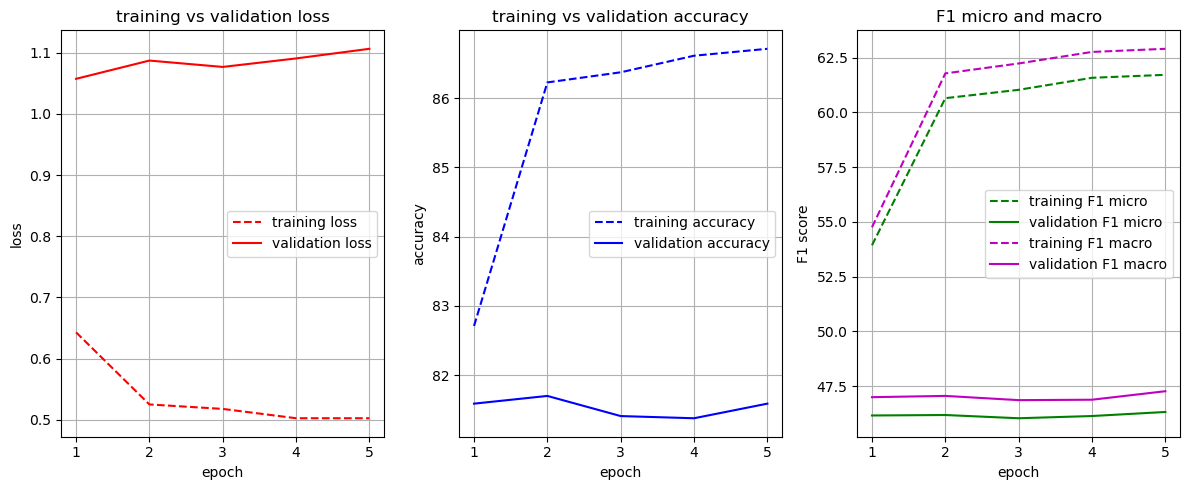

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re

from models.lstm import GenreClassifier
from models.resnet50 import ResNet50MultiLabel
from models.multimodal import MultiModalClassifier
from dataset import MultiModalDataset
from train_multimodal import train_multimodal

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
embedding_matrix = np.load("embedding_matrix.npy")
with open("mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

df = pd.read_csv("data/movies_dataset.csv")
df["genres"] = df["genres"].fillna("").apply(lambda x: [g.strip() for g in str(x).split(",") if g.strip()])
df["overview"] = df["overview"].fillna("").apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", re.sub(r"<.*?>", "", x.lower())))
df["tokens"] = df["overview"].apply(word_tokenize)

def encode_tokens(tokens, vocab, max_len=200):
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    return encoded[:max_len] + [vocab["<PAD>"]] * max(0, max_len - len(encoded))

df["input_ids"] = df["tokens"].apply(lambda x: encode_tokens(x, vocab))
df["multi_hot_labels"] = mlb.transform(df["genres"]).tolist()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
poster_dir = "data/movie_posters"

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

train_ds = MultiModalDataset(train_df, poster_dir, img_transform)
val_ds   = MultiModalDataset(val_df, poster_dir, img_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

vocab_size = len(vocab)
text_model = GenreClassifier(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=256,
    output_dim=len(mlb.classes_),
    embedding_matrix=embedding_matrix
).to(device)
text_model.load_state_dict(torch.load("src/text_model.pt", map_location=device))
text_model.eval()

image_model = ResNet50MultiLabel(num_classes=len(mlb.classes_))
image_model.load_state_dict(torch.load("src/resnet_dp0.3_lr0.0003_wd0.0001_frzTrue.pth", map_location=device))
image_model.eval()

multi_model = MultiModalClassifier(text_model, image_model, num_classes=len(mlb.classes_)).to(device)
params = list(multi_model.text_proj.parameters()) + list(multi_model.image_proj.parameters()) + list(multi_model.classifier.parameters())
optimizer = optim.Adam(params, lr=1e-3)

label_array = np.array(train_df["multi_hot_labels"].tolist())
pos_counts = label_array.sum(axis=0)
neg_counts = len(label_array) - pos_counts
pos_weights = torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

history = train_multimodal(
    model=multi_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    class_names=mlb.classes_
)

from utils import plot_training_curves  

plot_training_curves(
    history['train_losses'], history['val_losses'],
    history['train_accuracies'], history['val_accuracies'],
    history['train_f1_micro'], history['val_f1_micro'],
    history['train_f1_macro'], history['val_f1_macro'],
    save_path="multimodal_training_results.png"
)


In [2]:
torch.save(multi_model.state_dict(), "multimodal_model1.pt")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import re
from nltk.tokenize import word_tokenize
from torchvision import transforms
from PIL import Image

from models.lstm import GenreClassifier
from models.resnet50 import ResNet50MultiLabel
from models.multimodal import MultiModalClassifier

with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
embedding_matrix = np.load("embedding_matrix.npy")
with open("mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

def encode_tokens(tokens, vocab, max_len=200):
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    return encoded[:max_len] + [vocab["<PAD>"]] * (max_len - len(encoded))

def preprocess_image(path):
    transform = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform(Image.open(path).convert("RGB"))

def predict(text, image_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

    text_model = GenreClassifier(
        vocab_size=len(vocab),
        embedding_dim=100,
        hidden_dim=256,
        output_dim=len(mlb.classes_),
        embedding_matrix=embedding_matrix
    )
    image_model = ResNet50MultiLabel(num_classes=len(mlb.classes_))

    fusion_model = MultiModalClassifier(text_model, image_model, num_classes=len(mlb.classes_)).to(device)
    fusion_model.load_state_dict(torch.load("multimodal_model1.pt", map_location=device))
    fusion_model.eval()

    tokens = word_tokenize(clean_text(text))
    ids = encode_tokens(tokens, vocab)
    input_ids = torch.tensor([ids], dtype=torch.long).to(device)

    image_tensor = preprocess_image(image_path).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = fusion_model(input_ids, image_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        preds = (probs > 0.5).astype(int)
        return mlb.inverse_transform(np.array([preds]))[0]

if __name__ == "__main__":
    genres = predict(
        text="When new students can't get onto their college cheerleading team, they form their own squad and prepare for a cheer off.",
        image_path="/Users/rmessenger/School/EAS510/MoviePosterProject/src/data/movie_posters/12540.jpg"  # Replace with your image path
    )
    print("Predicted genres:", genres)


/var/folders/5r/krd8cxq51496mbdz_v_jbjy00000gn/T/ipykernel_5856/3834301393.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model.load_state_dict(torch.load("mult

Predicted genres: ('Comedy', 'Drama', 'Romance')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/5r/krd8cxq51496mbdz_v_jbjy00000gn/T/ipykernel_8405/3833032074.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

epoch 1/5 | train loss: 0.6217, acc: 0.8316, F1 (macro): 0.5594 | val loss: 1.0325, acc: 0.8105, F1 (macro): 0.4719
Per-genre F1 scores:
  Action         : 0.442
  Adventure      : 0.421
  Animation      : 0.779
  Comedy         : 0.483
  Crime          : 0.414
  Documentary    : 0.419
  Drama          : 0.402
  Family         : 0.634
  Fantasy        : 0.408
  Horror         : 0.580
  Mystery        : 0.301
  Romance        : 0.493
  Science Fiction: 0.437
  Thriller       : 0.393



Epoch 2 [Train]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_ids, dtype=torch.long),
/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attention_mask, dtype=torch.long),
Epoch 2 [Val]:   0%|          | 0/93 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

epoch 2/5 | train loss: 0.5231, acc: 0.8612, F1 (macro): 0.6184 | val loss: 1.0844, acc: 0.8162, F1 (macro): 0.4727
Per-genre F1 scores:
  Action         : 0.448
  Adventure      : 0.410
  Animation      : 0.751
  Comedy         : 0.481
  Crime          : 0.427
  Documentary    : 0.420
  Drama          : 0.396
  Family         : 0.628
  Fantasy        : 0.426
  Horror         : 0.574
  Mystery        : 0.302
  Romance        : 0.504
  Science Fiction: 0.466
  Thriller       : 0.386



Epoch 3 [Train]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_ids, dtype=torch.long),
/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attention_mask, dtype=torch.long),
Epoch 3 [Val]:   0%|          | 0/93 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

epoch 3/5 | train loss: 0.5111, acc: 0.8654, F1 (macro): 0.6263 | val loss: 1.0858, acc: 0.8135, F1 (macro): 0.4690
Per-genre F1 scores:
  Action         : 0.449
  Adventure      : 0.411
  Animation      : 0.775
  Comedy         : 0.481
  Crime          : 0.417
  Documentary    : 0.430
  Drama          : 0.399
  Family         : 0.617
  Fantasy        : 0.412
  Horror         : 0.576
  Mystery        : 0.294
  Romance        : 0.493
  Science Fiction: 0.435
  Thriller       : 0.377



Epoch 4 [Train]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_ids, dtype=torch.long),
/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attention_mask, dtype=torch.long),
Epoch 4 [Val]:   0%|          | 0/93 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

epoch 4/5 | train loss: 0.5025, acc: 0.8668, F1 (macro): 0.6300 | val loss: 1.1057, acc: 0.8156, F1 (macro): 0.4741
Per-genre F1 scores:
  Action         : 0.461
  Adventure      : 0.412
  Animation      : 0.783
  Comedy         : 0.485
  Crime          : 0.418
  Documentary    : 0.450
  Drama          : 0.394
  Family         : 0.613
  Fantasy        : 0.423
  Horror         : 0.582
  Mystery        : 0.294
  Romance        : 0.486
  Science Fiction: 0.455
  Thriller       : 0.380



Epoch 5 [Train]:   0%|          | 0/369 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_ids, dtype=torch.long),
/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attention_mask, dtype=torch.long),
Epoch 5 [Val]:   0%|          | 0/93 [00:00<?, ?it/s]/Users/rmessenger/School/EAS510/MoviePosterProject/src/dataset.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

epoch 5/5 | train loss: 0.5054, acc: 0.8646, F1 (macro): 0.6264 | val loss: 1.0731, acc: 0.8076, F1 (macro): 0.4663
Per-genre F1 scores:
  Action         : 0.440
  Adventure      : 0.404
  Animation      : 0.736
  Comedy         : 0.494
  Crime          : 0.419
  Documentary    : 0.429
  Drama          : 0.399
  Family         : 0.608
  Fantasy        : 0.416
  Horror         : 0.562
  Mystery        : 0.290
  Romance        : 0.497
  Science Fiction: 0.447
  Thriller       : 0.386

saving plot to: multimodal_training_results.png


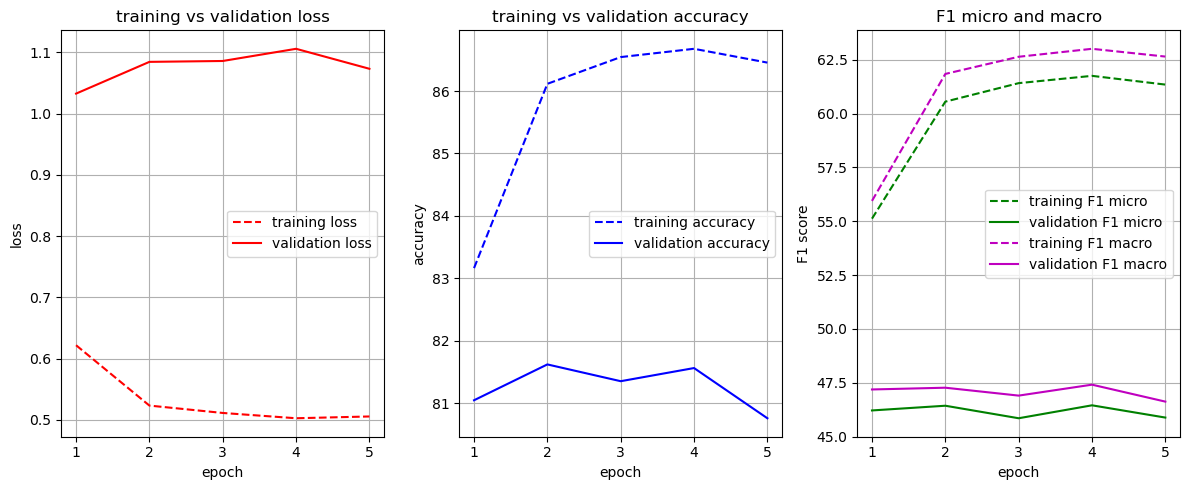

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re

from models.lstm import GenreClassifier
from models.resnet50 import ResNet50MultiLabel
from models.multimodal2 import MultiModalClassifier2
from dataset import MultiModalDataset2
from train_multimodal2 import train_multimodal2
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

with open("bert_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
embedding_matrix = np.load("bert_embedding_matrix.npy")
with open("mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

df = pd.read_csv("/Users/rmessenger/School/EAS510/MoviePosterProject/src/data/movies_dataset.csv")
df["genres"] = df["genres"].fillna("").apply(lambda x: [g.strip() for g in str(x).split(",") if g.strip()])

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_with_bert(text, tokenizer, max_len=256):
    enc = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )
    return enc['input_ids'].squeeze(0), enc['attention_mask'].squeeze(0)

df['input'] = df['overview'].fillna("").apply(lambda x: encode_with_bert(x, tokenizer))
df['input_ids'] = df['input'].apply(lambda x: x[0])
df['attention_mask'] = df['input'].apply(lambda x: x[1])


df["multi_hot_labels"] = mlb.transform(df["genres"]).tolist()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
poster_dir = "/Users/rmessenger/School/EAS510/MoviePosterProject/src/data/movie_posters"

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

train_ds = MultiModalDataset2(train_df, poster_dir, img_transform)
val_ds   = MultiModalDataset2(val_df, poster_dir, img_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

vocab_size = len(vocab)

model_name = "bert-base-uncased"
num_labels = 14
text_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
text_model.eval()

image_model = ResNet50MultiLabel(num_classes=len(mlb.classes_))
image_model.load_state_dict(torch.load("src/resnet_dp0.3_lr0.0003_wd0.0001_frzTrue.pth", map_location=device))
image_model.eval()

multi_model = MultiModalClassifier2(text_model, image_model, num_classes=len(mlb.classes_)).to(device)
params = list(multi_model.text_proj.parameters()) + list(multi_model.image_proj.parameters()) + list(multi_model.classifier.parameters())
optimizer = optim.Adam(params, lr=1e-3)

label_array = np.array(train_df["multi_hot_labels"].tolist())
pos_counts = label_array.sum(axis=0)
neg_counts = len(label_array) - pos_counts
pos_weights = torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

history = train_multimodal2(
    model=multi_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    class_names=mlb.classes_
)

from utils import plot_training_curves  

plot_training_curves(
    history['train_losses'], history['val_losses'],
    history['train_accuracies'], history['val_accuracies'],
    history['train_f1_micro'], history['val_f1_micro'],
    history['train_f1_macro'], history['val_f1_macro'],
    save_path="multimodal_training_results.png"
)
